# `Anisotropy` Tutorial
This tutorial is an introduction to the `anisotropy` module of the pulsar timing array sensitivity curve package `hasasia`. For an introduction to straight forward sensitivity curves see prior tutorials. 

In [1]:
#Import the usual suspects.
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# You'll need these packages to make the skymaps and deal with units. 
import healpy as hp
import astropy.units as u
import astropy.constants as c

import itertools

import hasasia
import hasasia.sensitivity as hsen
import hasasia.sim as hsim
import hasasia.skymap as hsky
import hasasia.anisotropy as haniso

import pickle
import os

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['figure.figsize'] = [5,3]
mpl.rcParams['text.usetex'] = True

In [2]:
savedir = '/Users/oliverda/Documents/NANOGrav/Anisotropy/plots/'
datadir = '/Users/oliverda/Documents/NANOGrav/15yr_data/Hasasia_Spectra/'

In [3]:
number_of_pulsars = 10

In [4]:
#Make a set of random sky positions
phi = np.random.uniform(0, 2*np.pi,size=number_of_pulsars)
cos_theta = np.random.uniform(-1,1,size=number_of_pulsars)
theta = np.arccos(cos_theta)

#Adding one well-placed sky position for plots.
phi = np.append(np.array(np.deg2rad(60)),phi)
theta = np.append(np.array(np.deg2rad(50)),theta)

#Define the timsespans and TOA errors for the pulsars
timespans = np.random.uniform(3.0,15.8,size=number_of_pulsars+1)
Tspan = timespans.max()*365.25*24*3600
sigma = 1e-7 # 100 ns

Here we use the `sim_pta` method in the `hasasia.sim` module to simulate a set of `hasasia.senstivity.Pulsar` objects. This function takes either single values or lists/array as inputs for the set of pulsars. 

In [5]:
#Simulate a set of identical pulsars, with different sky positions. 
psrs = hsim.sim_pta(timespan=15.8, cad=23, sigma=sigma,
                    phi=phi, theta=theta)

Next define the frequency range over which to characterize the spectra for the pulsars and enter each `Pulsar` object into a `hasasia.sensitivity.Spectrum` object. 

In [6]:
freqs = np.logspace(np.log10(1/(5*Tspan)),np.log10(2e-7),500)
spectra = []
for p in psrs:
    sp = hsen.Spectrum(p, freqs=freqs)
    sp.NcalInv
    spectra.append(sp)

Note above that we have called `sp.NcalInv`, which calculates the inverse-noise-weighted tranASMission function for the pulsar along the way. For realistic pulsars with +100k TOAs this step will take the most time.

## Define a Anisotropy Object
Before defining a `hasasia.skymap.Anisotropy` object we will need to choose a set of sky locations. Here we use the `healpy` Python package to give us a healpix pixelation of the sky. 

In [7]:
#Use the healpy functions to get the sky coordinates
NSIDE = 1
NPIX = hp.nside2npix(NSIDE)
IPIX = np.arange(NPIX)
theta_gw, phi_gw = hp.pix2ang(nside=NSIDE,ipix=IPIX)
print('Number of pixels:', NPIX)

Number of pixels: 12


Next enter the list of `Spectrum` objects and the sky coordinates into the `Anisotropy` class.  

In [8]:
ASM=haniso.Anisotropy(spectra,theta_gw, phi_gw, NPIX=NPIX)

In [9]:
print(f'shape of ASM.R_IJ: {ASM.R_IJ.sum(axis=0).shape}')

shape of ASM.R_IJ: (12,)


And the full residual response as `Anisotropy.R_IJ`.

In [10]:
# # Loop over each unique pulsar pair and plot their response
# for idx1, idx2 in itertools.combinations(range(len(ASM.thetas)), 2):
#     if (idx1, idx2) in zip(ASM.first, ASM.second):
#         try:
#             pair_index = next(i for i, (f, s) in enumerate(zip(ASM.first, ASM.second)) if f == idx1 and s == idx2)
#             # print(f"Pair index for ({idx1}, {idx2}): {pair_index}")
#         except StopIteration:
#             # print(f"Pair ({idx1}, {idx2}) not found in ASM.first and ASM.second!")
#             continue  # Skip this pair if not found
#         # print(f"location of pulsar {idx1}: {ASM.phis[idx1], ASM.thetas[idx1]}")
#         # print(f"location of pulsar {idx2}: {ASM.phis[idx2], ASM.thetas[idx2]}")
#         hp.mollview(ASM.R_IJ[pair_index], title=f"Two Pulsar Response $R_{{{idx1},{idx2}}}$")

#     if (idx1, idx2) in zip(ASM.first, ASM.second):
#         pair_index = ASM.first.index(idx1)
        
#     # Highlight the two pulsars on the sky
#     hp.visufunc.projscatter(ASM.thetas[idx1], ASM.phis[idx1], marker='*', color='white', edgecolors='k', s=200)
#     hp.visufunc.projscatter(ASM.thetas[idx2], ASM.phis[idx2], marker='*', color='white', edgecolors='k', s=200)
#     plt.savefig(savedir+f'pair_{idx1}_{idx2}.png')
# #     plt.show()


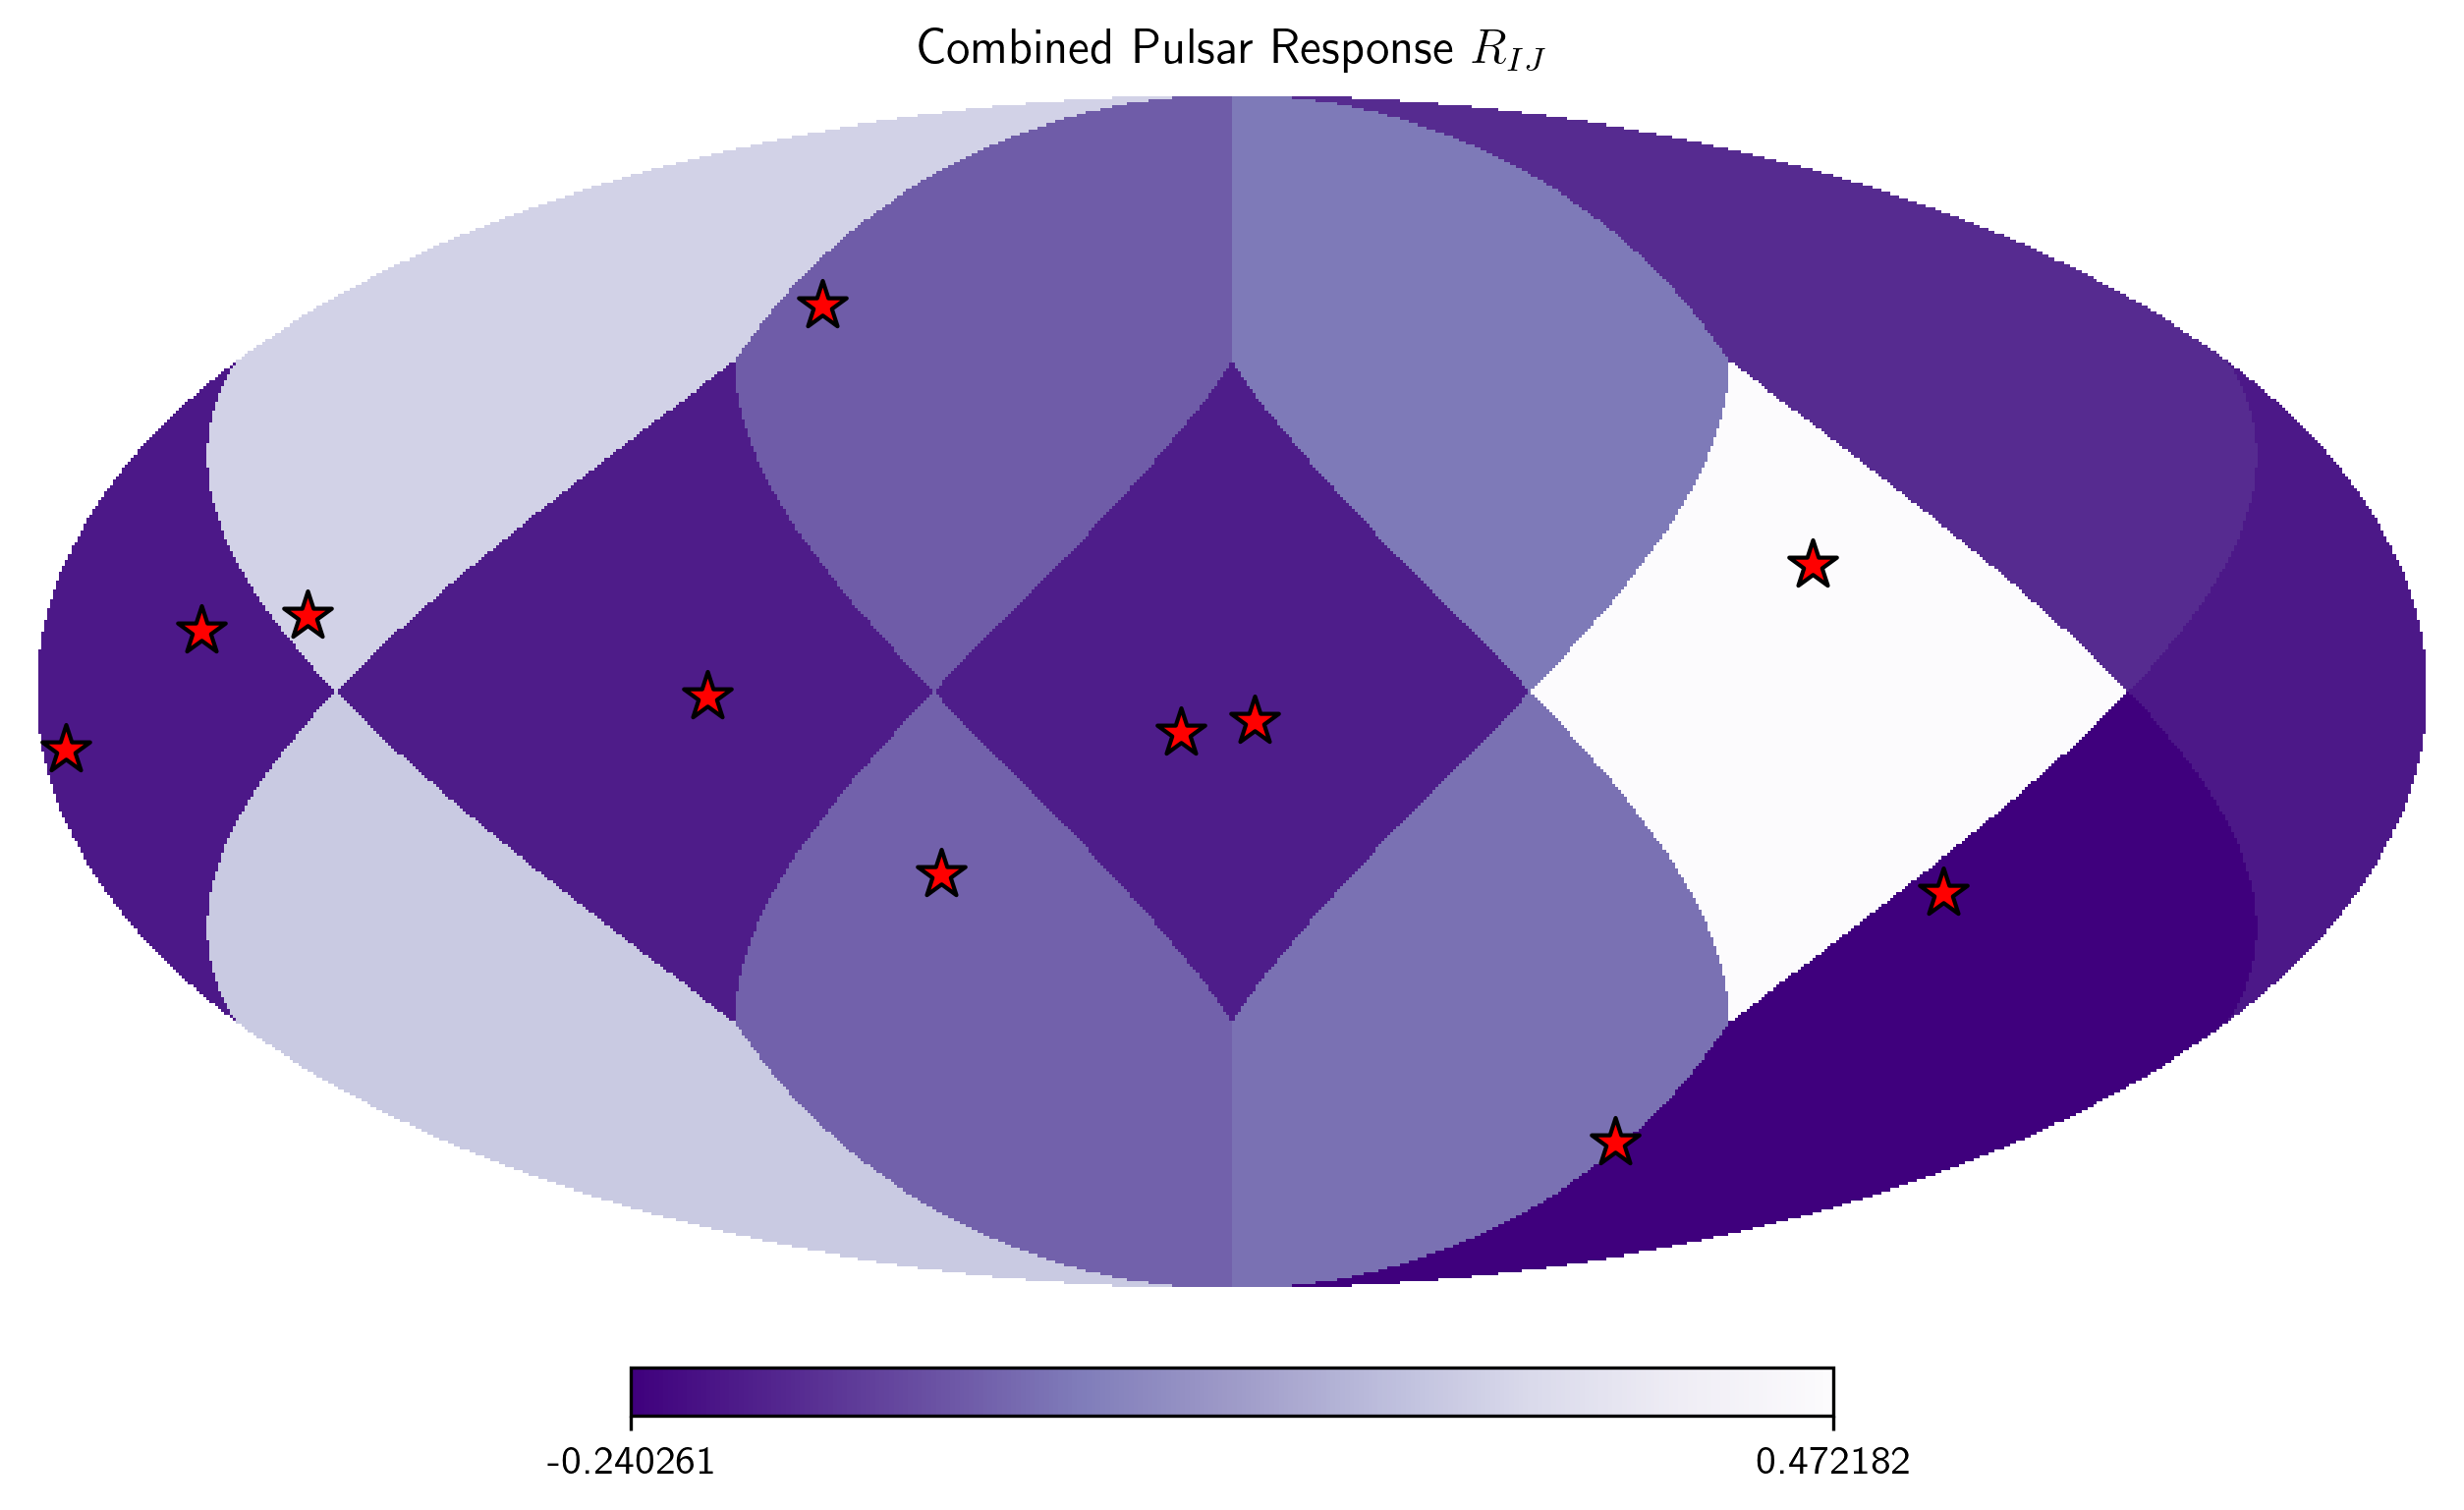

In [11]:
# Summing all pair responses
combined_response = ASM.R_IJ.sum(axis=0)

# Plot the combined response
hp.mollview(combined_response, title="Combined Pulsar Response $R_{IJ}$", cmap='Purples_r', rot=(180,0,0))

# Highlight all pulsar positions
hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
                            edgecolors='black', s=150, rot=(180,0,0))
plt.savefig(savedir+'combined.png')
plt.show()


## Test of S_IJ and M_kk

Shapes
* R: NCC, k
* T: NCC
* S: NCC, f
* Mkk: k, f

In [12]:
print(f'shape of ASM.M_kk: {ASM.M_kk.shape}')
print(f'shape of ASM.M_kkp: {ASM.M_kkp.shape}')
print(f'shape of ASM.S_clean: {ASM.S_clean.shape}')
print(f'shape of ASM.Seff_A_aniso: {ASM.Seff_A_aniso.shape}')
print(f'shape of ASM.S_eff_aniso: {ASM.S_eff_aniso.shape}')
S_eff_aniso = ((ASM.S_eff_aniso**(-1/2))/NPIX)/Tspan
print(f'shape of S_eff_aniso: {S_eff_aniso.shape}')
# print(f'shape of ASM.h_c_aniso: {ASM.h_c_aniso.shape}')
h_c_aniso = np.sqrt(freqs * np.sum(S_eff_aniso, axis=1))
print(f'shape of h_c_aniso: {h_c_aniso.shape}')

shape of ASM.M_kk: (500, 12)
shape of ASM.M_kkp: (500, 12, 12)
shape of ASM.S_clean: (500, 12)
shape of ASM.Seff_A_aniso: (500, 12)
shape of ASM.S_eff_aniso: (500, 12)
shape of S_eff_aniso: (500, 12)
shape of h_c_aniso: (500,)


In [13]:
max_value = np.max(h_c_aniso)
max_index = np.argmax(h_c_aniso)
max_freq = freqs[max_index]  # Corresponding frequency
print(f"Max value: {max_value}, Index: {max_index}, Frequency: {max_freq}")

min_value = np.min(h_c_aniso)
min_index = np.argmin(h_c_aniso)
min_freq = freqs[min_index]  # Corresponding frequency
print(f"Min value: {min_value}, Index: {min_index}, Frequency: {min_freq}")

median_value = np.median(h_c_aniso)
median_index = (np.abs(h_c_aniso - median_value)).argmin()
median_freq = freqs[median_index]  # Corresponding frequency
print(f"Median value: {median_value}, Index: {median_index}, Frequency: {median_freq}")

Max value: 1.1801902663091471e-14, Index: 348, Frequency: 3.177830523915135e-08
Min value: 5.837825243681614e-17, Index: 122, Frequency: 2.0250101244505125e-09
Median value: 1.9492447076907628e-16, Index: 249, Frequency: 9.513692189741665e-09


In [14]:
# final_freqs = [max_freq, min_freq, median_freq]
# final_freqs_idx = [max_index, min_index, median_index]

# for freq, idx in zip(final_freqs, final_freqs_idx):
#     # Compute the map at this frequency
#     h_c_pixel = ASM.h_c_aniso_pixel(idx)
    
#     # Plot the map
#     hp.mollview(h_c_pixel, title=f"f = {freq * 1e9:.2f} nHz", cmap='Purples_r', rot=(180,0,0))

#     # Overlay pulsar positions
#     hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
#                             edgecolors='black', linewidths=0.25, s=150, alpha=1, rot=(180,0,0))
    
#     plt.show()


In [15]:
# M_kk_pixel = np.sqrt(ASM.M_kk[:, max_index])/Tspan

# # Rescale M_kk_pixel such that min = 0 and max = 1
# M_kk_pixel_norm = (M_kk_pixel - np.min(M_kk_pixel)) / (np.max(M_kk_pixel) - np.min(M_kk_pixel))

# # Plot the map with the normalized values
# hp.mollview(M_kk_pixel_norm, title=f"f = {max_freq * 1e9:.2f} nHz", cmap='Purples_r', rot=(180,0,0))

# # Overlay pulsar positions
# hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
#                         edgecolors='black', linewidths=0.25, s=150, alpha=1, rot=(180,0,0))

# plt.show()



In [16]:
# M_kk_pixel = np.sqrt(ASM.M_kk[:, min_index])/Tspan

# # Rescale M_kk_pixel such that min = 0 and max = 1
# M_kk_pixel_norm = (M_kk_pixel - np.min(M_kk_pixel)) / (np.max(M_kk_pixel) - np.min(M_kk_pixel))

# # Plot the map with the normalized values
# hp.mollview(M_kk_pixel_norm, title=f"f = {min_freq * 1e9:.2f} nHz", cmap='Purples_r', rot=(180,0,0))

# print(f"shape of M_kk_pixel: {M_kk_pixel.shape}")

# # Overlay pulsar positions
# hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
#                         edgecolors='black', linewidths=0.25, s=150, alpha=1, rot=(180,0,0))

# plt.show()



In [17]:
# M_kk_pixel = np.sqrt(ASM.M_kk[:, median_index])/Tspan

# # Rescale M_kk_pixel such that min = 0 and max = 1
# M_kk_pixel_norm = (M_kk_pixel - np.min(M_kk_pixel)) / (np.max(M_kk_pixel) - np.min(M_kk_pixel))

# # Plot the map with the normalized values
# hp.mollview(M_kk_pixel_norm, title=f"f = {median_freq * 1e9:.2f} nHz", cmap='Purples_r', rot=(180,0,0))

# # Overlay pulsar positions
# hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
#                         edgecolors='black', linewidths=0.25, s=150, alpha=1, rot=(180,0,0))

# plt.show()



In [18]:
final_freqs = [max_freq, min_freq, median_freq]
final_freqs_idx = [max_index, min_index, median_index]

# for freq, idx in zip(final_freqs, final_freqs_idx):
#     # Compute the map at this frequency
#     M_kk_pixel = np.sqrt(ASM.M_kk[:, idx])/Tspan
    
#     # Plot the map
#     hp.mollview(M_kk_pixel, title=f"f = {freq * 1e9:.2f} nHz", cmap='Purples_r', rot=(180,0,0))

#     # Overlay pulsar positions
#     hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
#                             edgecolors='black', linewidths=0.25, s=150, alpha=1, rot=(180,0,0))
    
#     plt.show()


In [19]:
# # Iterate over frequency indices
# for freq_idx in range(len(freqs)):  # Use range(len(freqs)) to iterate properly
#     # print(f"ASM.M_kk[:, freq_idx] first 5 is {ASM.M_kk[:, freq_idx][:5]}")
#     sqrt_values = np.sqrt(ASM.M_kk[:, freq_idx])
#     # print(f"sqrt_values first 5 is {sqrt_values[:5]}")
#     normalized_sqrt_values = sqrt_values/np.sqrt(ASM.M_kk[:,freq_idx].sum(axis=0))
#     normalized_sqrt_values2 = sqrt_values/normalize
#     # print(f"normalize 2 first 5 is {normalized_sqrt_values2[:5]}")
#     # print(f"shape of ASM.M_kk[:, :] is {np.shape(ASM.M_kk[:, :])}")
#     # print(f"shape of ASM.M_kk[:, freq_idx] is {np.shape(ASM.M_kk[:, freq_idx])}")
#     # print(f"shape of np.sqrt(ASM.M_kk[:,:]) is {np.shape(np.sqrt(ASM.M_kk[:,:]))}")
#     # print(f"shape of np.sqrt(ASM.M_kk[:,freq_idx]) is {np.shape(np.sqrt(ASM.M_kk[:,freq_idx]))}")
#     # print(f"shape of np.sqrt(ASM.M_kk[:,:].sum(axis=0)) is {np.shape(np.sqrt(ASM.M_kk[:,:].sum(axis=0)))}")
#     # print(f"shape of np.sqrt(ASM.M_kk[:,freq_idx].sum(axis=0)) is {np.shape(np.sqrt(ASM.M_kk[:,freq_idx].sum(axis=0)))}")
#     # print(f"np.sqrt(ASM.M_kk[:,freq_idx].sum(axis=0)) is {np.sqrt(ASM.M_kk[:,freq_idx].sum(axis=0))}")
#     # print(f"normalized_sqrt_values first 5 is {normalized_sqrt_values[:5]}")

In [20]:
# # Placeholder for computed values
# averages = []

# # Initialize variables for overall min and max
# global_min = np.inf
# global_max = -np.inf

# # Iterate over frequency indices
# for freq_idx in range(len(freqs)):  # Use range(len(freqs)) to iterate properly
#     sqrt_values = np.sqrt(ASM.M_kk[:, freq_idx])/Tspan
#     avg_value = np.mean(sqrt_values)  # Compute average
#     averages.append(avg_value)  # Append to list

#     # Update global min and max values
#     global_min = min(global_min, np.min(sqrt_values))
#     global_max = max(global_max, np.max(sqrt_values))

# # Compute statistics for frequencies
# max_freq_idx = np.argmax(averages)  # Index of the max average value
# min_freq_idx = np.argmin(averages)  # Index of the min average value
# avg_freq_idx = np.argmin(np.abs(averages - np.mean(averages)))  # Closest to mean

# print(f"max: {max_freq_idx}, min: {min_freq_idx}, avg: {avg_freq_idx}")

# max_freq = freqs[max_freq_idx]
# min_freq = freqs[min_freq_idx]
# avg_freq = freqs[avg_freq_idx]

# # Plot for max frequency
# max_mkk = np.sqrt(ASM.M_kk[:, max_freq_idx])/Tspan

# # Use the global min and max values for consistent scaling
# hp.mollview(max_mkk, title=f"Max f = {max_freq * 1e9:.2f} nHz", 
#             min=global_min, max=global_max, cmap='Purples_r', rot=(180,0,0), hold=False)  # Consistent scale & better contrast

# # Highlight all pulsar positions
# hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
#                         edgecolors='black', linewidths=0.25, s=150, alpha=1, rot=(180,0,0))  # Transparency for clarity

# plt.show()

# # Plot for min frequency
# min_mkk = np.sqrt(ASM.M_kk[:, min_freq_idx])/Tspan

# # Use the global min and max values for consistent scaling
# hp.mollview(min_mkk, title=f"Min f = {min_freq * 1e9:.2f} nHz", 
#             min=global_min, max=global_max, cmap='Purples_r', rot=(180,0,0), hold=False)  # Consistent scale & better contrast

# # Highlight all pulsar positions
# hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
#                         edgecolors='black', linewidths=0.25, s=150, alpha=1, rot=(180,0,0))  # Transparency for clarity

# plt.show()

# # Plot for average frequency
# avg_mkk = np.sqrt(ASM.M_kk[:, avg_freq_idx])/Tspan

# # Use the global min and max values for consistent scaling
# hp.mollview(avg_mkk, title=f"Avg f = {avg_freq * 1e9:.2f} nHz", 
#             min=global_min, max=global_max, cmap='Purples_r', rot=(180,0,0), hold=False)  # Consistent scale & better contrast

# # Highlight all pulsar positions
# hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
#                          edgecolors='black', linewidths=0.25, s=150, alpha=1, rot=(180,0,0))  # Transparency for clarity

# plt.show()


In [21]:
# # Placeholder for computed values
# averages = []

# # Iterate over frequency indices
# for freq_idx in range(len(freqs)):  # Use range(len(freqs)) to iterate properly
#     sqrt_values = np.sqrt(ASM.M_kk[:, freq_idx])
#     normalized_sqrt_values = sqrt_values/np.sqrt(ASM.M_kk[:,freq_idx].sum(axis=0))
#     avg_value = np.mean(sqrt_values)  # Compute average
#     averages.append(avg_value)  # Append to list

# # Compute statistics for frequencies
# max_freq_idx = np.argmax(averages)  # Index of the max average value
# min_freq_idx = np.argmin(averages)  # Index of the min average value
# avg_freq_idx = np.argmin(np.abs(averages - np.mean(averages)))  # Closest to mean

# print(f"max: {max_freq_idx}, min: {min_freq_idx}, avg: {avg_freq_idx}")

# max_freq = freqs[max_freq_idx]
# min_freq = freqs[min_freq_idx]
# avg_freq = freqs[avg_freq_idx]
# # Plot for max frequency
# max_mkk = np.sqrt(ASM.M_kk[:, max_freq_idx])

# vmin, vmax = np.min(max_mkk), np.max(max_mkk)
# print(vmin/np.sqrt(ASM.M_kk[:,max_freq_idx].sum(axis=0)))
# print(vmax/np.sqrt(ASM.M_kk[:,max_freq_idx].sum(axis=0)))
# normalized_max_mkk = max_mkk/np.sqrt(ASM.M_kk[:,max_freq_idx].sum(axis=0))
# print(f"normalized_max_mkk first 5 is {normalized_max_mkk[:5]}")

# hp.mollview(normalized_max_mkk, title=f"Max f = {max_freq * 1e9:.2f} nHz", 
#             min=abs_vmin, max=abs_vmax, cmap='Purples_r', rot=(180,0,0), hold=False)  # Consistent scale & better contrast

# # Highlight all pulsar positions
# hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
#                         edgecolors='black', linewidths=0.25, s=150, alpha=1, rot=(180,0,0))  # Transparency for clarity

# plt.show()

# # Plot for min frequency
# min_mkk = np.sqrt(ASM.M_kk[:, min_freq_idx])

# vmin, vmax = np.min(min_mkk), np.max(min_mkk)
# print(vmin/np.sqrt(ASM.M_kk[:,min_freq_idx].sum(axis=0)))
# print(vmax/np.sqrt(ASM.M_kk[:,min_freq_idx].sum(axis=0)))
# normalized_min_mkk = min_mkk/np.sqrt(ASM.M_kk[:,min_freq_idx].sum(axis=0))
# print(f"normalized_min_mkk first 5 is {normalized_min_mkk[:5]}")


# hp.mollview(normalized_min_mkk, title=f"Min f = {min_freq * 1e9:.2f} nHz", 
#             min=abs_vmin, max=abs_vmax, cmap='Purples_r', rot=(180,0,0), hold=False)  # Consistent scale & better contrast

# # Highlight all pulsar positions
# hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
#                         edgecolors='black', linewidths=0.25, s=150, alpha=1, rot=(180,0,0))  # Transparency for clarity

# plt.show()

# # Plot for average frequency
# avg_mkk = np.sqrt(ASM.M_kk[:, avg_freq_idx])

# vmin, vmax = np.min(avg_mkk), np.max(avg_mkk)
# print(vmin/np.sqrt(ASM.M_kk[:,avg_freq_idx].sum(axis=0)))
# print(vmax/np.sqrt(ASM.M_kk[:,avg_freq_idx].sum(axis=0)))
# normalized_avg_mkk = avg_mkk/np.sqrt(ASM.M_kk[:,avg_freq_idx].sum(axis=0))
# print(f"normalized_avg_mkk first 5 is {normalized_avg_mkk[:5]}")


# hp.mollview(normalized_avg_mkk, title=f"Avg f = {avg_freq * 1e9:.2f} nHz", 
#             min=abs_vmin, max=abs_vmax, cmap='Purples_r', rot=(180,0,0), hold=False)  # Consistent scale & better contrast

# # Highlight all pulsar positions
# hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
#                          edgecolors='black', linewidths=0.25, s=150, alpha=1, rot=(180,0,0))  # Transparency for clarity

# plt.show()

In [22]:
print(f'shape of ASM.S_eff_aniso: {ASM.S_eff_aniso.shape}')
print(f'shape of ASM.S_eff_aniso: {S_eff_aniso.shape}')

shape of ASM.S_eff_aniso: (500, 12)
shape of ASM.S_eff_aniso: (500, 12)


In [23]:
print(f'first 1 of ASM.S_eff_aniso is {ASM.S_eff_aniso[:1]}')
print(f'first 1 of ASM.S_eff_aniso**(-1/2) is {ASM.S_eff_aniso[:1]**(-1/2)}')
print(f'first 1 of (ASM.S_eff_aniso**(-1/2))/Tspan is {(ASM.S_eff_aniso[:1]**(-1/2))/Tspan}')
# print(f'first 1 of h_c_aniso is {np.sqrt(freqs*np.mean(ASM.S_eff_aniso[:1]))}')
# print(f'first 1 of h_c_aniso from ASM.S_eff_aniso**(-1/2) is {np.sqrt(freqs*np.mean(ASM.S_eff_aniso[:1]**(-1/2)))}')
# print(f'first 1 of h_c_aniso from (ASM.S_eff_aniso**(-1/2))/Tspan is {np.sqrt(freqs*(np.mean(ASM.S_eff_aniso[:1]**(-1/2))/Tspan))}')
S_eff_aniso = ((ASM.S_eff_aniso/Tspan)**(-1/2))
print(f'first 1 of S_eff_aniso is {S_eff_aniso[:1]}')
S_eff_aniso_SkyA = S_eff_aniso.mean(axis=1)
print(f'first 1 of S_eff_aniso_SkyA is {S_eff_aniso_SkyA[:1]}')
h_c_aniso_SkyA = np.sqrt(freqs * S_eff_aniso_SkyA)
print(f'first 1 of h_c_aniso_SkyA is {h_c_aniso_SkyA[:1]}')
h_c_aniso_test = np.sqrt(freqs[:, np.newaxis] * S_eff_aniso)
print(f'first 1 of h_c_aniso_test is {h_c_aniso_test[:1]}')

first 1 of ASM.S_eff_aniso is [[1.43083675e+28 6.70849513e+27 2.94492762e+28 6.99963504e+27
  3.46644563e+28 8.06212255e+27 3.45703964e+28 1.42452409e+28
  2.40094137e+28 7.34903730e+27 2.15006808e+28 4.75231537e+27]]
first 1 of ASM.S_eff_aniso**(-1/2) is [[8.35997458e-15 1.22092067e-14 5.82723708e-15 1.19525977e-14
  5.37103279e-15 1.11371816e-14 5.37833464e-15 8.37847736e-15
  6.45370667e-15 1.16650008e-14 6.81983542e-15 1.45059900e-14]]
first 1 of (ASM.S_eff_aniso**(-1/2))/Tspan is [[1.91484613e-23 2.79650996e-23 1.33472444e-23 2.73773385e-23
  1.23023117e-23 2.55096339e-23 1.23190366e-23 1.91908418e-23
  1.47821684e-23 2.67186000e-23 1.56207837e-23 3.32258651e-23]]
first 1 of S_eff_aniso is [[1.74678919e-10 2.55107357e-10 1.21758202e-10 2.49745597e-10
  1.12225963e-10 2.32707746e-10 1.12378533e-10 1.75065528e-10
  1.34848078e-10 2.43736355e-10 1.42498218e-10 3.03097889e-10]]
first 1 of S_eff_aniso_SkyA is [1.88154032e-10]
first 1 of h_c_aniso_SkyA is [2.93586597e-10]
first 1 of h_c

In [24]:
S_eff_aniso = (ASM.S_eff_aniso**(-1/2)/Tspan)
print(f'shape of S_eff_aniso: {S_eff_aniso.shape}')
S_eff_aniso_SkyA = (ASM.S_eff_aniso**(-1/2)/Tspan).mean(axis=1)
print(f'shape of S_eff_aniso_SkyA: {S_eff_aniso_SkyA.shape}')
h_c_aniso = np.sqrt(freqs[:, np.newaxis] * S_eff_aniso)
print(f'shape of h_c_aniso: {h_c_aniso.shape}')
h_c_aniso_SkyA = np.sqrt(freqs*S_eff_aniso_SkyA)
print(f'shape of h_c_aniso_SkyA: {h_c_aniso_SkyA.shape}')


shape of S_eff_aniso: (500, 12)
shape of S_eff_aniso_SkyA: (500,)
shape of h_c_aniso: (500, 12)
shape of h_c_aniso_SkyA: (500,)


In [115]:
# Number of pixels for brightness sorting
num_pixels = NPIX/3

# Flatten S_eff_aniso to work with pixel values
S_eff_aniso_flat = S_eff_aniso[1]

# Sort the indices based on pixel brightness
sorted_indices = np.argsort(S_eff_aniso_flat)

# Get the indices for the 5 brightest, 5 dimmest, and 5 middle pixels
brightest_indices = sorted_indices[:num_pixels]
dimmest_indices = sorted_indices[-num_pixels:]
# middle_indices = sorted_indices[len(sorted_indices) // 2 - 2:len(sorted_indices) // 2 + 3]
middle_start = len(sorted_indices) // 2 - num_pixels // 2
middle_end = middle_start + num_pixels
middle_indices = sorted_indices[middle_start:middle_end]

# Retrieve the corresponding pixel values
brightest_pixels = S_eff_aniso_flat[brightest_indices]
dimmest_pixels = S_eff_aniso_flat[dimmest_indices]
middle_pixels = S_eff_aniso_flat[middle_indices]

# brightest_brightest = np.max(S_eff_aniso_flat[brightest_indices])
# brightest_brightest_indices = np.argmax(S_eff_aniso_flat[brightest_indices])
# dimmest_brightest = np.min(S_eff_aniso_flat[brightest_indices])
# dimmest_brightest_indices = np.argmin(S_eff_aniso_flat[brightest_indices])

# brightest_dimmest = np.max(S_eff_aniso_flat[dimmest_indices])
# brightest_dimmest_indices = np.argmax(S_eff_aniso_flat[dimmest_indices])
# dimmest_dimmest = np.min(S_eff_aniso_flat[dimmest_indices])
# dimmest_dimmest_indices = np.argmin(S_eff_aniso_flat[dimmest_indices])

# brightest_middle = np.max(S_eff_aniso_flat[middle_indices])
# brightest_middle_indices = np.argmax(S_eff_aniso_flat[middle_indices])
# dimmest_middle = np.min(S_eff_aniso_flat[middle_indices])
# dimmest_middle_indices = np.argmin(S_eff_aniso_flat[middle_indices])

# print(f'Brightest indices: {brightest_indices}')
# print(f'index of brightest pixel: {brightest_brightest_indices}')
# print(f'index of dimmest pixel: {dimmest_brightest_indices}')
# print(f'Dimmest indices: {dimmest_indices}')
# print(f'index of brightest pixel: {brightest_dimmest_indices}')
# print(f'index of dimmest pixel: {dimmest_dimmest_indices}')
# print(f'Middle indices: {middle_indices}')
# print(f'index of brightest pixel: {brightest_middle_indices}')
# print(f'index of dimmest pixel: {dimmest_middle_indices}')





TypeError: slice indices must be integers or None or have an __index__ method

Brightest group: [4 6 2], brightest_brightest_idx: 2, brightest_dimmest_idx: 4
Middle group: [0 7 5], middle_brightest_idx: 5, middle_dimmest_idx: 0
Dimmest group: [ 3  1 11], dimmest_brightest_idx: 11, dimmest_dimmest_idx: 3


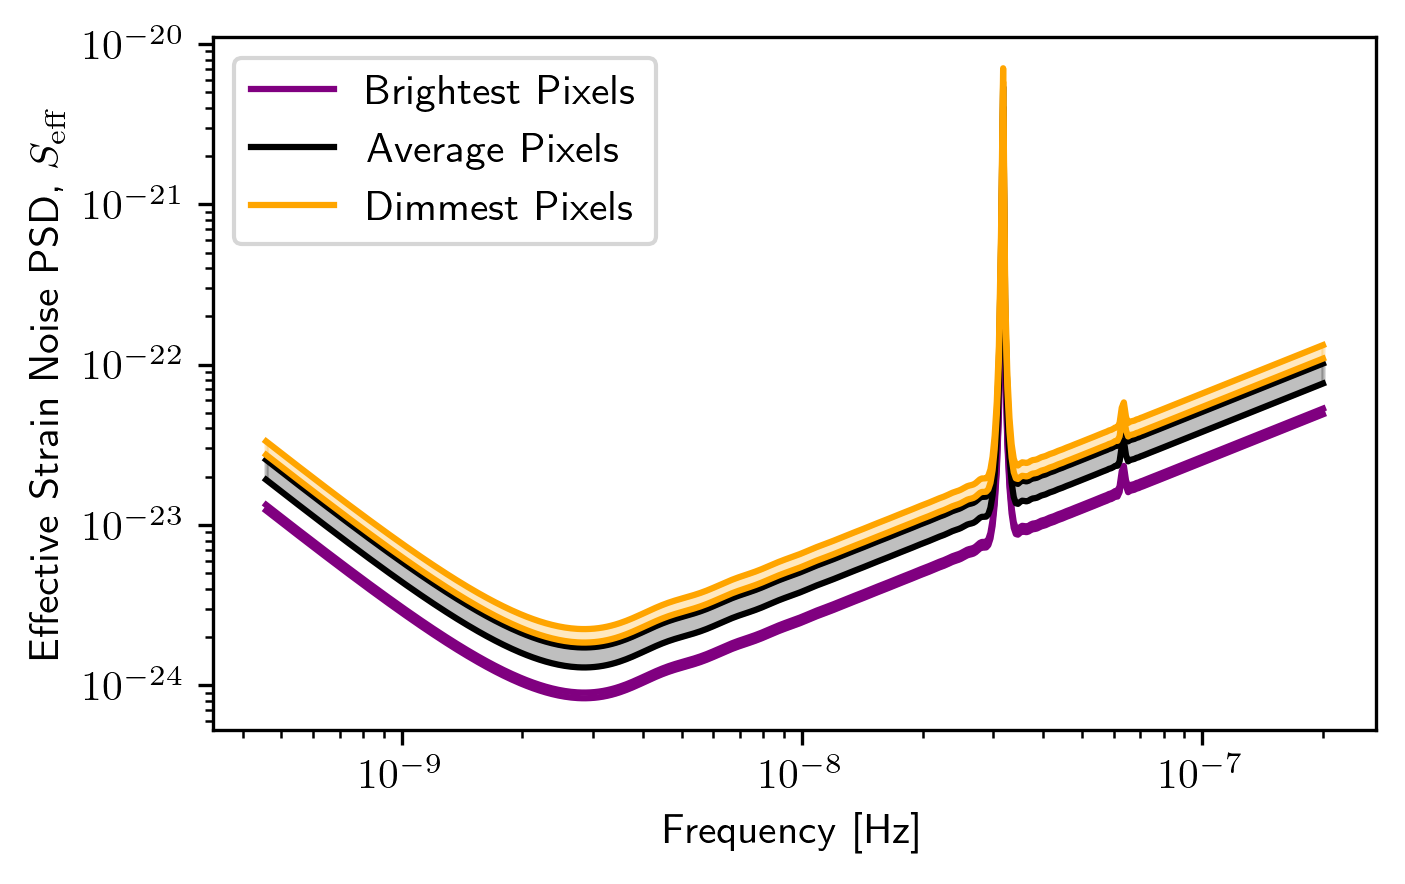

In [121]:
# Extract the brightest and dimmest indices for each group
brightest_brightest_idx = np.argmax(S_eff_aniso_flat[brightest_indices])
brightest_dimmest_idx = np.argmin(S_eff_aniso_flat[brightest_indices])

middle_brightest_idx = np.argmax(S_eff_aniso_flat[middle_indices])
middle_dimmest_idx = np.argmin(S_eff_aniso_flat[middle_indices])

dimmest_brightest_idx = np.argmax(S_eff_aniso_flat[dimmest_indices])
dimmest_dimmest_idx = np.argmin(S_eff_aniso_flat[dimmest_indices])

print(f'Brightest group: {brightest_indices}, brightest_brightest_idx: {brightest_indices[brightest_brightest_idx]}, brightest_dimmest_idx: {brightest_indices[brightest_dimmest_idx]}')
print(f'Middle group: {middle_indices}, middle_brightest_idx: {middle_indices[middle_brightest_idx]}, middle_dimmest_idx: {middle_indices[middle_dimmest_idx]}')
print(f'Dimmest group: {dimmest_indices}, dimmest_brightest_idx: {dimmest_indices[dimmest_brightest_idx]}, dimmest_dimmest_idx: {dimmest_indices[dimmest_dimmest_idx]}')

# Brightest group
plt.fill_between(freqs, 
                 S_eff_aniso[:, brightest_indices[brightest_dimmest_idx]], 
                 S_eff_aniso[:, brightest_indices[brightest_brightest_idx]], 
                 color='purple', alpha=0.25)
plt.loglog(freqs, S_eff_aniso[:, brightest_indices[brightest_brightest_idx]], color='purple', label='Brightest Pixels')
plt.loglog(freqs, S_eff_aniso[:, brightest_indices[brightest_dimmest_idx]], color='purple')

# Middle group
plt.fill_between(freqs, 
                 S_eff_aniso[:, middle_indices[middle_dimmest_idx]], 
                 S_eff_aniso[:, middle_indices[middle_brightest_idx]], 
                 color='black', alpha=0.25)
plt.loglog(freqs, S_eff_aniso[:, middle_indices[middle_brightest_idx]], color='black', label='Average Pixels')
plt.loglog(freqs, S_eff_aniso[:, middle_indices[middle_dimmest_idx]], color='black')

# Dimmest group
plt.fill_between(freqs, 
                 S_eff_aniso[:, dimmest_indices[dimmest_dimmest_idx]], 
                 S_eff_aniso[:, dimmest_indices[dimmest_brightest_idx]], 
                 color='orange', alpha=0.25)
plt.loglog(freqs, S_eff_aniso[:, dimmest_indices[dimmest_brightest_idx]], color='orange', label='Dimmest Pixels')
plt.loglog(freqs, S_eff_aniso[:, dimmest_indices[dimmest_dimmest_idx]], color='orange')

# Sky average
# plt.loglog(freqs, S_eff_aniso_SkyA, color='black', linewidth=2.0, label='Sky Average')

# Add labels and legend
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'Effective Strain Noise PSD, $S_{\rm eff}$')
# plt.ylim([1e-24,1e-23])
plt.legend()
plt.show()

Brightest group: [4 6 2], brightest_brightest_idx: 2, brightest_dimmest_idx: 4
Middle group: [0 7 5], middle_brightest_idx: 5, middle_dimmest_idx: 0
Dimmest group: [ 3  1 11], dimmest_brightest_idx: 11, dimmest_dimmest_idx: 3


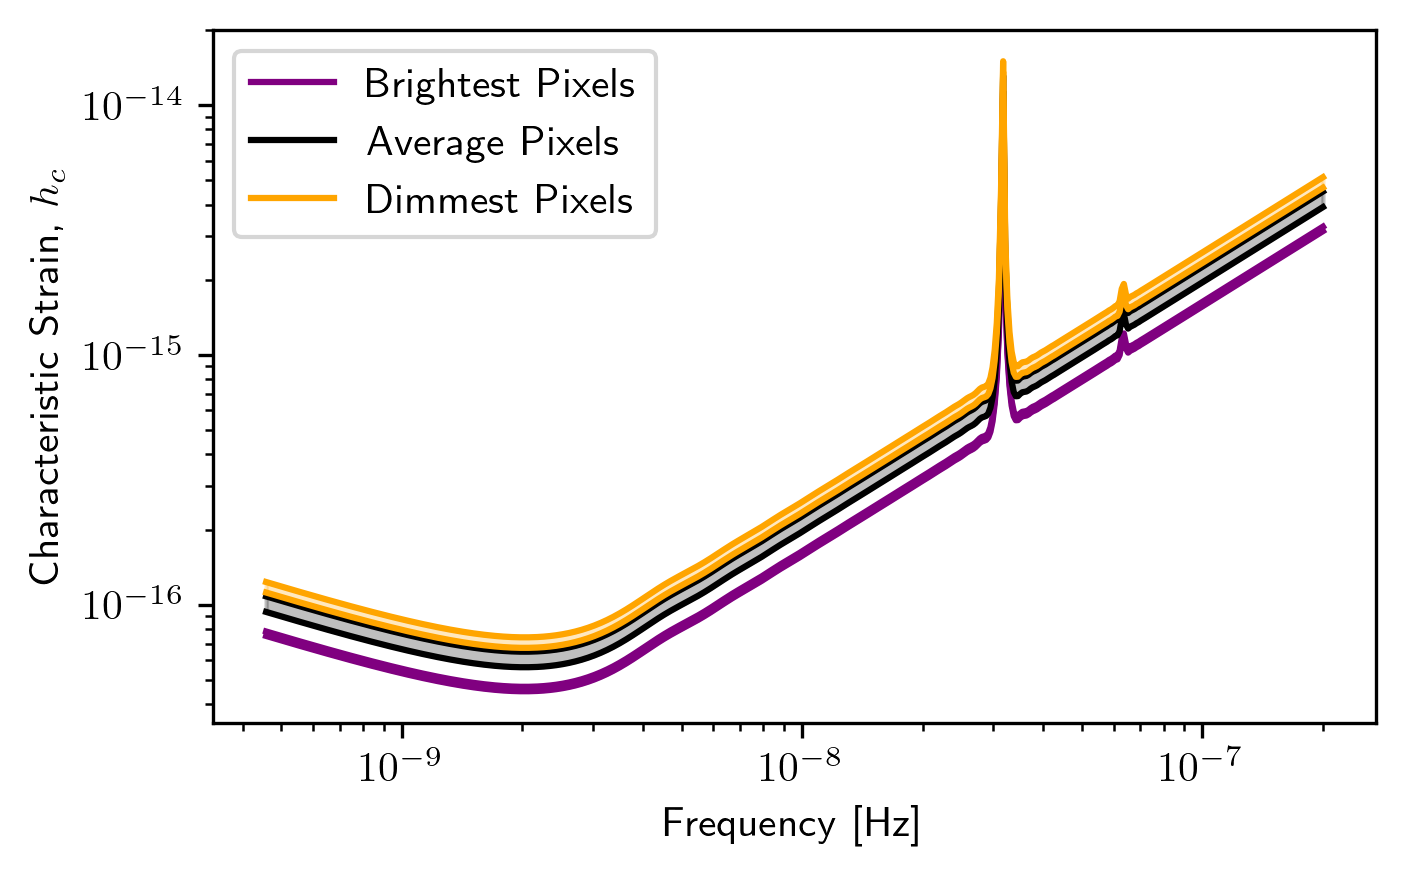

In [120]:
# Extract the brightest and dimmest indices for each group
brightest_brightest_idx = np.argmax(S_eff_aniso_flat[brightest_indices])
brightest_dimmest_idx = np.argmin(S_eff_aniso_flat[brightest_indices])

middle_brightest_idx = np.argmax(S_eff_aniso_flat[middle_indices])
middle_dimmest_idx = np.argmin(S_eff_aniso_flat[middle_indices])

dimmest_brightest_idx = np.argmax(S_eff_aniso_flat[dimmest_indices])
dimmest_dimmest_idx = np.argmin(S_eff_aniso_flat[dimmest_indices])

print(f'Brightest group: {brightest_indices}, brightest_brightest_idx: {brightest_indices[brightest_brightest_idx]}, brightest_dimmest_idx: {brightest_indices[brightest_dimmest_idx]}')
print(f'Middle group: {middle_indices}, middle_brightest_idx: {middle_indices[middle_brightest_idx]}, middle_dimmest_idx: {middle_indices[middle_dimmest_idx]}')
print(f'Dimmest group: {dimmest_indices}, dimmest_brightest_idx: {dimmest_indices[dimmest_brightest_idx]}, dimmest_dimmest_idx: {dimmest_indices[dimmest_dimmest_idx]}')

# Brightest group
plt.fill_between(freqs, 
                 h_c_aniso[:, brightest_indices[brightest_dimmest_idx]], 
                 h_c_aniso[:, brightest_indices[brightest_brightest_idx]], 
                 color='purple', alpha=0.25)
plt.loglog(freqs, h_c_aniso[:, brightest_indices[brightest_brightest_idx]], color='purple', label='Brightest Pixels')
plt.loglog(freqs, h_c_aniso[:, brightest_indices[brightest_dimmest_idx]], color='purple')

# Middle group
plt.fill_between(freqs, 
                 h_c_aniso[:, middle_indices[middle_dimmest_idx]], 
                 h_c_aniso[:, middle_indices[middle_brightest_idx]], 
                 color='black', alpha=0.25)
plt.loglog(freqs, h_c_aniso[:, middle_indices[middle_brightest_idx]], color='black', label='Average Pixels')
plt.loglog(freqs, h_c_aniso[:, middle_indices[middle_dimmest_idx]], color='black')

# Dimmest group
plt.fill_between(freqs, 
                 h_c_aniso[:, dimmest_indices[dimmest_dimmest_idx]], 
                 h_c_aniso[:, dimmest_indices[dimmest_brightest_idx]], 
                 color='orange', alpha=0.25)
plt.loglog(freqs, h_c_aniso[:, dimmest_indices[dimmest_brightest_idx]], color='orange', label='Dimmest Pixels')
plt.loglog(freqs, h_c_aniso[:, dimmest_indices[dimmest_dimmest_idx]], color='orange')

# Sky average
# plt.loglog(freqs, h_c_aniso_SkyA, color='black', linewidth=2.0, label='Sky Average')

# Add labels and legend
plt.xlabel('Frequency [Hz]')
plt.ylabel('Characteristic Strain, $h_c$')
plt.legend()
plt.show()

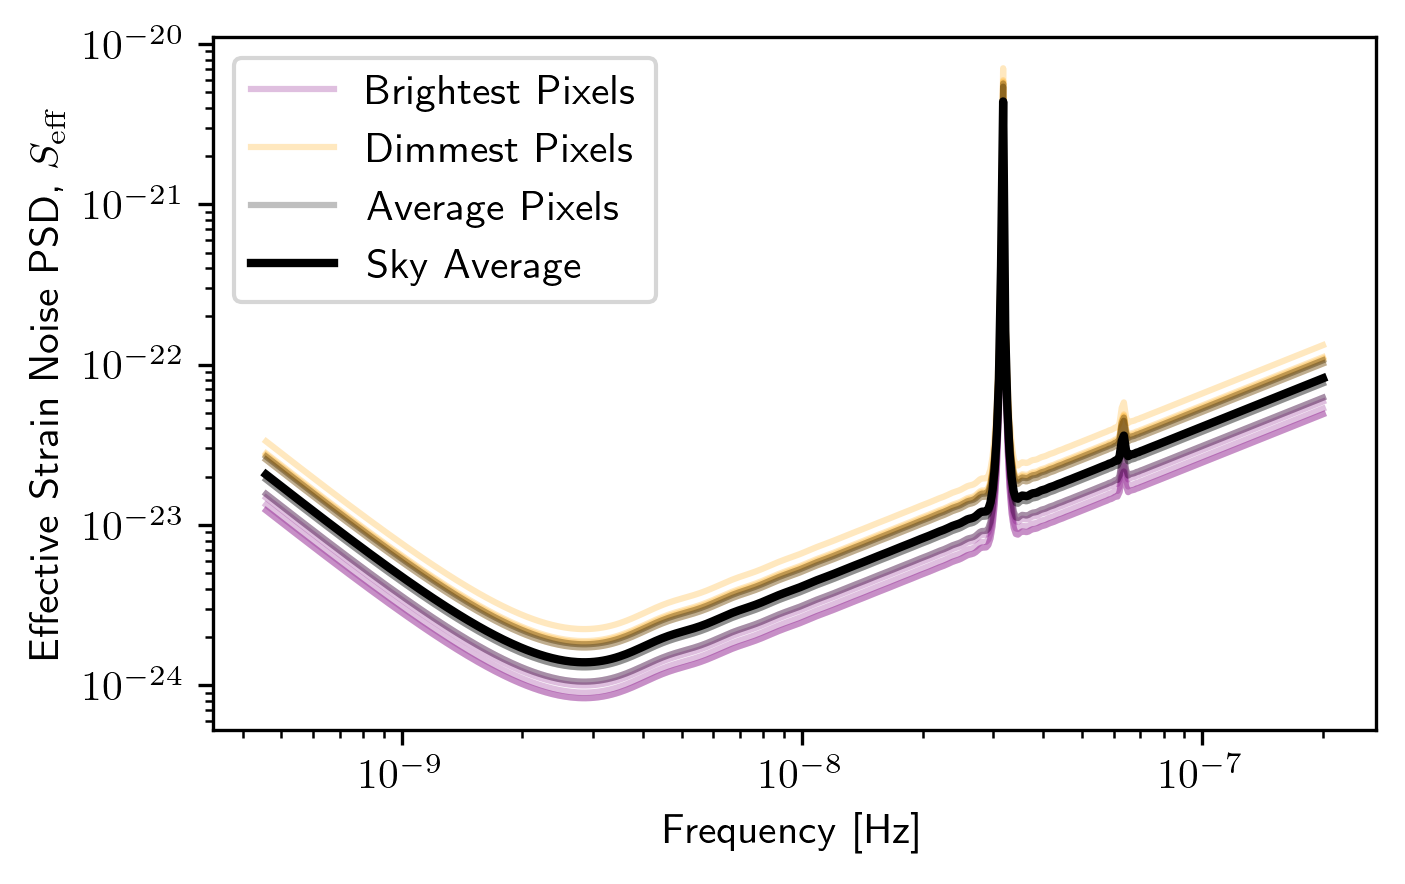

In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib.lines as mlines

# # Create custom legend handles
# brightest_handle = mlines.Line2D([], [], color='purple', alpha=0.25, label='Brightest Pixels')
# dimmest_handle = mlines.Line2D([], [], color='orange', alpha=0.25, label='Dimmest Pixels')
# middle_handle = mlines.Line2D([], [], color='black', alpha=0.25, label='Average Pixels')
# sky_avg_handle = mlines.Line2D([], [], color='black', linewidth=2.0, label='Sky Average')

# # Plot the data
# plt.loglog(freqs, S_eff_aniso[:, brightest_indices], alpha=0.25, color='purple')
# plt.loglog(freqs, S_eff_aniso[:, dimmest_indices], alpha=0.25, color='orange')
# plt.loglog(freqs, S_eff_aniso[:, middle_indices], alpha=0.25, color='black')
# plt.loglog(freqs, S_eff_aniso_SkyA, color='black', linewidth=2.0)

# # Add custom legend
# plt.legend(handles=[brightest_handle, dimmest_handle, middle_handle, sky_avg_handle])

# # Add labels
# plt.xlabel('Frequency [Hz]')
# plt.ylabel(r'Effective Strain Noise PSD, $S_{\rm eff}$')

# # Show the plot
# plt.show()

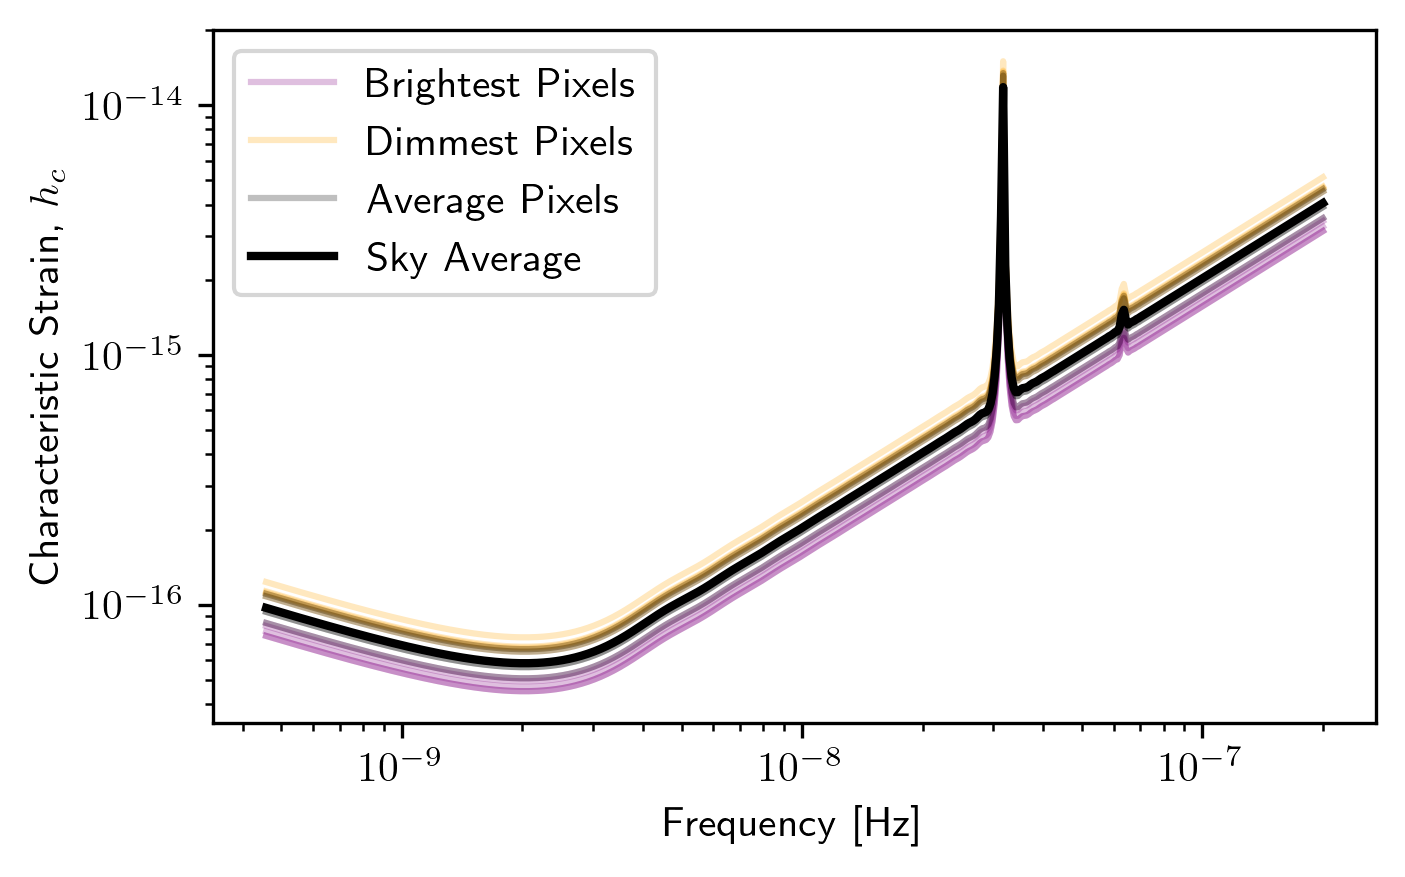

In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib.lines as mlines

# # Create custom legend handles
# brightest_handle = mlines.Line2D([], [], color='purple', alpha=0.25, label='Brightest Pixels')
# dimmest_handle = mlines.Line2D([], [], color='orange', alpha=0.25, label='Dimmest Pixels')
# middle_handle = mlines.Line2D([], [], color='black', alpha=0.25, label='Average Pixels')
# sky_avg_handle = mlines.Line2D([], [], color='black', linewidth=2.0, label='Sky Average')

# # Plot the data
# plt.loglog(freqs, h_c_aniso[:, brightest_indices], alpha=0.25, color='purple')
# plt.loglog(freqs, h_c_aniso[:, dimmest_indices], alpha=0.25, color='orange')
# plt.loglog(freqs, h_c_aniso[:, middle_indices], alpha=0.25, color='black')
# plt.loglog(freqs, h_c_aniso_SkyA, color='black', linewidth=2.0)

# # Add custom legend
# plt.legend(handles=[brightest_handle, dimmest_handle, middle_handle, sky_avg_handle])

# # Add labels
# plt.xlabel('Frequency [Hz]')
# plt.ylabel('Characteristic Strain, $h_c$')

# # Show the plot
# plt.show()

In [69]:
# plt.loglog(freqs,S_eff_aniso_SkyA, color='purple')
# plt.loglog(freqs,S_eff_aniso, alpha=0.25)
# plt.xlabel('Frequency [Hz]')
# plt.ylabel(r'Effective Strain Noise PSD, $S_{\rm eff}$')
# plt.show()

In [70]:
# plt.loglog(freqs,h_c_aniso, alpha=0.25, linewidth=1)
# plt.loglog(freqs,h_c_aniso_SkyA, color='purple')
# plt.xlabel('Frequency [Hz]')
# plt.ylabel('Characteristic Strain, $h_c$')
# plt.show()

In [27]:
;aslkdjf;a a;ksldj;askd

NameError: name 'aslkdjf' is not defined

In [ ]:
# plt.loglog(freqs,h_c_aniso)
# plt.xlabel('Frequency [Hz]')
# plt.ylabel('Characteristic Strain, $h_c$')
# plt.show()

### Test for Amplitude of GWB from real_data_tutorial.ipynb

In [ ]:
# #First for alpha=-2/3 (the default value).
# SNR=1 
# hgw=hsen.Agwb_from_Seff_plaw(ng11yr_sc.freqs,
#                              Tspan=Tspan,
#                              SNR=SNR,
#                              S_eff=ng11yr_sc.S_eff)
# plaw_h = hgw*(ng11yr_sc.freqs/fyr)**(-2/3)

# #And for an array of alpha values. 
# alpha = np.linspace(-7/4,5/4,30)
# h=hsen.Agwb_from_Seff_plaw(freqs=ng11yr_sc.freqs,Tspan=Tspan,SNR=SNR,
#                            S_eff=ng11yr_sc.S_eff,alpha=alpha)

# plaw = np.dot((ng11yr_sc.freqs[:,np.newaxis]/fyr)**alpha,
#               h[:,np.newaxis]*np.eye(30))

In [ ]:
# for ii in range(len(h)):
#     plt.loglog(ng11yr_sc.freqs,plaw[:,ii],
#                color='gray',lw=0.5)
# plt.loglog(ng11yr_sc.freqs,plaw_h,color='C1',lw=2,
#            label='SNR={0}, '.format(SNR)+r'$\alpha=-2/3$')  
# plt.loglog(ng11yr_sc.freqs,ng11yr_sc.h_c, label='NG 11yr Sensitivity')
# plt.xlabel('Frequency [Hz]')
# plt.ylabel('Characteristic Strain, $h_c$')
# plt.axvline(fyr,linestyle=':')
# plt.rc('text', usetex=True)
# plt.title('NANOGrav 11-year Data Set\nPower-Law Interated Sensitivity Curve')
# plt.ylim(hgw*0.75,2e-11)
# plt.text(x=4e-8,y=3e-15,
#          s=r'$A_{\rm GWB}$='+'{0:1.2e}'.format(hgw),
#          bbox=dict(facecolor='white', alpha=0.6))
# plt.legend(loc='upper left')
# plt.show()

### Other plots

In [ ]:
# import numpy as np
# import healpy as hp
# import matplotlib.pyplot as plt

# search_freq = [2e-9, 4e-9, 5.9e-9, 7.9e-9, 9.9e-9]
# final_freqs = []
# final_idxs = []

# # Use the first pulsar to find the closest frequency indices
# for freq in search_freq:
#     fl_idx = np.argmin(np.abs(freqs - freq))  # Use the first pulsar
#     fl = freqs[fl_idx]  # Access the freqs from the first pulsar
#     final_freqs.append(fl)
#     final_idxs.append(fl_idx)

# print(f"Search frequencies: {search_freq}")
# print(f"Final frequencies: {final_freqs}")
# print(f"Final indices: {final_idxs}")

# # Create figure with a 2-column layout
# fig = plt.figure(figsize=(14, 12))

# # Define subplot positions
# positions = [(0, 0), (0, 1), (1, 0), (1, 1)]  # First 4 plots in a 2x2 grid

# for i, (freq, fl_idx) in enumerate(zip(final_freqs, final_idxs)):    
#     if i < 4:  # First 4 plots in 2x2 grid
#         ax = plt.subplot2grid((3, 2), positions[i], colspan=1)
#     else:  # Last plot spans both columns
#         ax = plt.subplot2grid((3, 2), (2, 0), colspan=2)

#     plt.sca(ax)  # Set the current axis
#     vmin, vmax = np.min(ASM.M_kk[:, fl_idx]), np.max(ASM.M_kk[:, fl_idx])
#     hp.mollview(ASM.M_kk[:, fl_idx], title=f"f = {freq:.2e} Hz", 
#                 min=0, max=1, cmap='Purples_r', rot=(180,0,0), hold=False)  # Consistent scale & better contrast

#     # Highlight all pulsar positions
#     hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='white', 
#                              edgecolors='black', s=200, alpha=0.8, rot=(180,0,0))  # Transparency for clarity

#     # Annotate each plot with frequency
#     plt.text(0, -1.2, f"{freq:.2e} Hz", fontsize=14, ha='center', color='white', fontweight='bold')

# plt.show()


## Test of Sclean

For the test of Sclean we need to include an S_h(f) for a gravitational wave signal. An example of this implementation in Hasasia exists in skymap.py, and usecase in skymap_tutorial.ipynb

In [ ]:
print(ASM.S_clean)
print(Tspan)

[[8.82002524e+13 5.91048931e+13 7.78171956e+13 ... 1.04030283e+14
  5.28753358e+13 8.25936676e+13]
 [9.03710136e+13 6.05595671e+13 7.97324117e+13 ... 1.06590649e+14
  5.41766896e+13 8.46264410e+13]
 [9.25940437e+13 6.20492675e+13 8.16937436e+13 ... 1.09212664e+14
  5.55093781e+13 8.67081607e+13]
 ...
 [2.82125087e+13 1.89058111e+13 2.48912928e+13 ... 3.32760416e+13
  1.69131701e+13 2.64191372e+13]
 [2.78645908e+13 1.86726638e+13 2.45843323e+13 ... 3.28656800e+13
  1.67045962e+13 2.60933352e+13]
 [2.75210101e+13 1.84424230e+13 2.42811984e+13 ... 3.24604340e+13
  1.64986223e+13 2.57715947e+13]]
487942723.90530014


In [ ]:
# # Summing all pair responses
# sclean = (ASM.S_clean[min_index, :]/(Tspan))

# # Plot the combined response
# hp.mollview((sclean*Tspan)**(-1), title="Sclean with **(-1) and without /Tspan", cmap='Purples_r', rot=(180,0,0))

# # Highlight all pulsar positions
# hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
#                             edgecolors='black', s=150, rot=(180,0,0))

# plt.show()

# # Plot the combined response
# hp.mollview(sclean*Tspan, title="Sclean without **(-1) and without /Tspan", cmap='Purples_r', rot=(180,0,0))

# # Highlight all pulsar positions
# hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
#                             edgecolors='black', s=150, rot=(180,0,0))

# plt.show()

# # Plot the combined response
# hp.mollview(sclean, title="Sclean without **(-1)", cmap='Purples_r', rot=(180,0,0))

# # Highlight all pulsar positions
# hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
#                             edgecolors='black', s=150, rot=(180,0,0))

# plt.show()
# # plt.savefig(savedir+'sclean.png')

# # Plot the combined response
# hp.mollview(sclean**(-1), title="Sclean using the **(-1)", cmap='Purples_r', rot=(180,0,0))

# # Highlight all pulsar positions
# hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
#                             edgecolors='black', s=150, rot=(180,0,0))

# plt.show()

# # Plot the combined response
# hp.mollview((sclean**(-1))/Tspan, title="Sclean using **(-1) and then dividing by Tspan again for units", cmap='Purples_r', rot=(180,0,0))

# # Highlight all pulsar positions
# hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
#                             edgecolors='black', s=150, rot=(180,0,0))

# plt.show()

# # Plot the combined response
# hp.mollview((sclean**(-1/2)), title="Sclean using **(-1/2)", cmap='Purples_r', rot=(180,0,0))

# # Highlight all pulsar positions
# hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
#                             edgecolors='black', s=150, rot=(180,0,0))

# plt.show()


# # Plot the combined response
# hp.mollview((sclean**(-1/2))/Tspan**(1/2), title="Sclean using **(-1/2) and then dividing by Tspan**1/2", cmap='Purples_r', rot=(180,0,0))

# # Highlight all pulsar positions
# hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
#                             edgecolors='black', s=150, rot=(180,0,0))

# plt.show()

# # Plot the combined response
# hp.mollview(sclean/Tspan, title="Sclean /Tspan again without the -1 or -1/2", cmap='Purples_r', rot=(180,0,0))

# # Highlight all pulsar positions
# hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
#                             edgecolors='black', s=150, rot=(180,0,0))

# plt.show()

## Test of M_kkp

In [ ]:
# Summing all pair responses
sclean = (ASM.S_clean[min_index, :]/(Tspan))
print(f"sclean shape: {np.shape(sclean)}")

sclean shape: (12,)


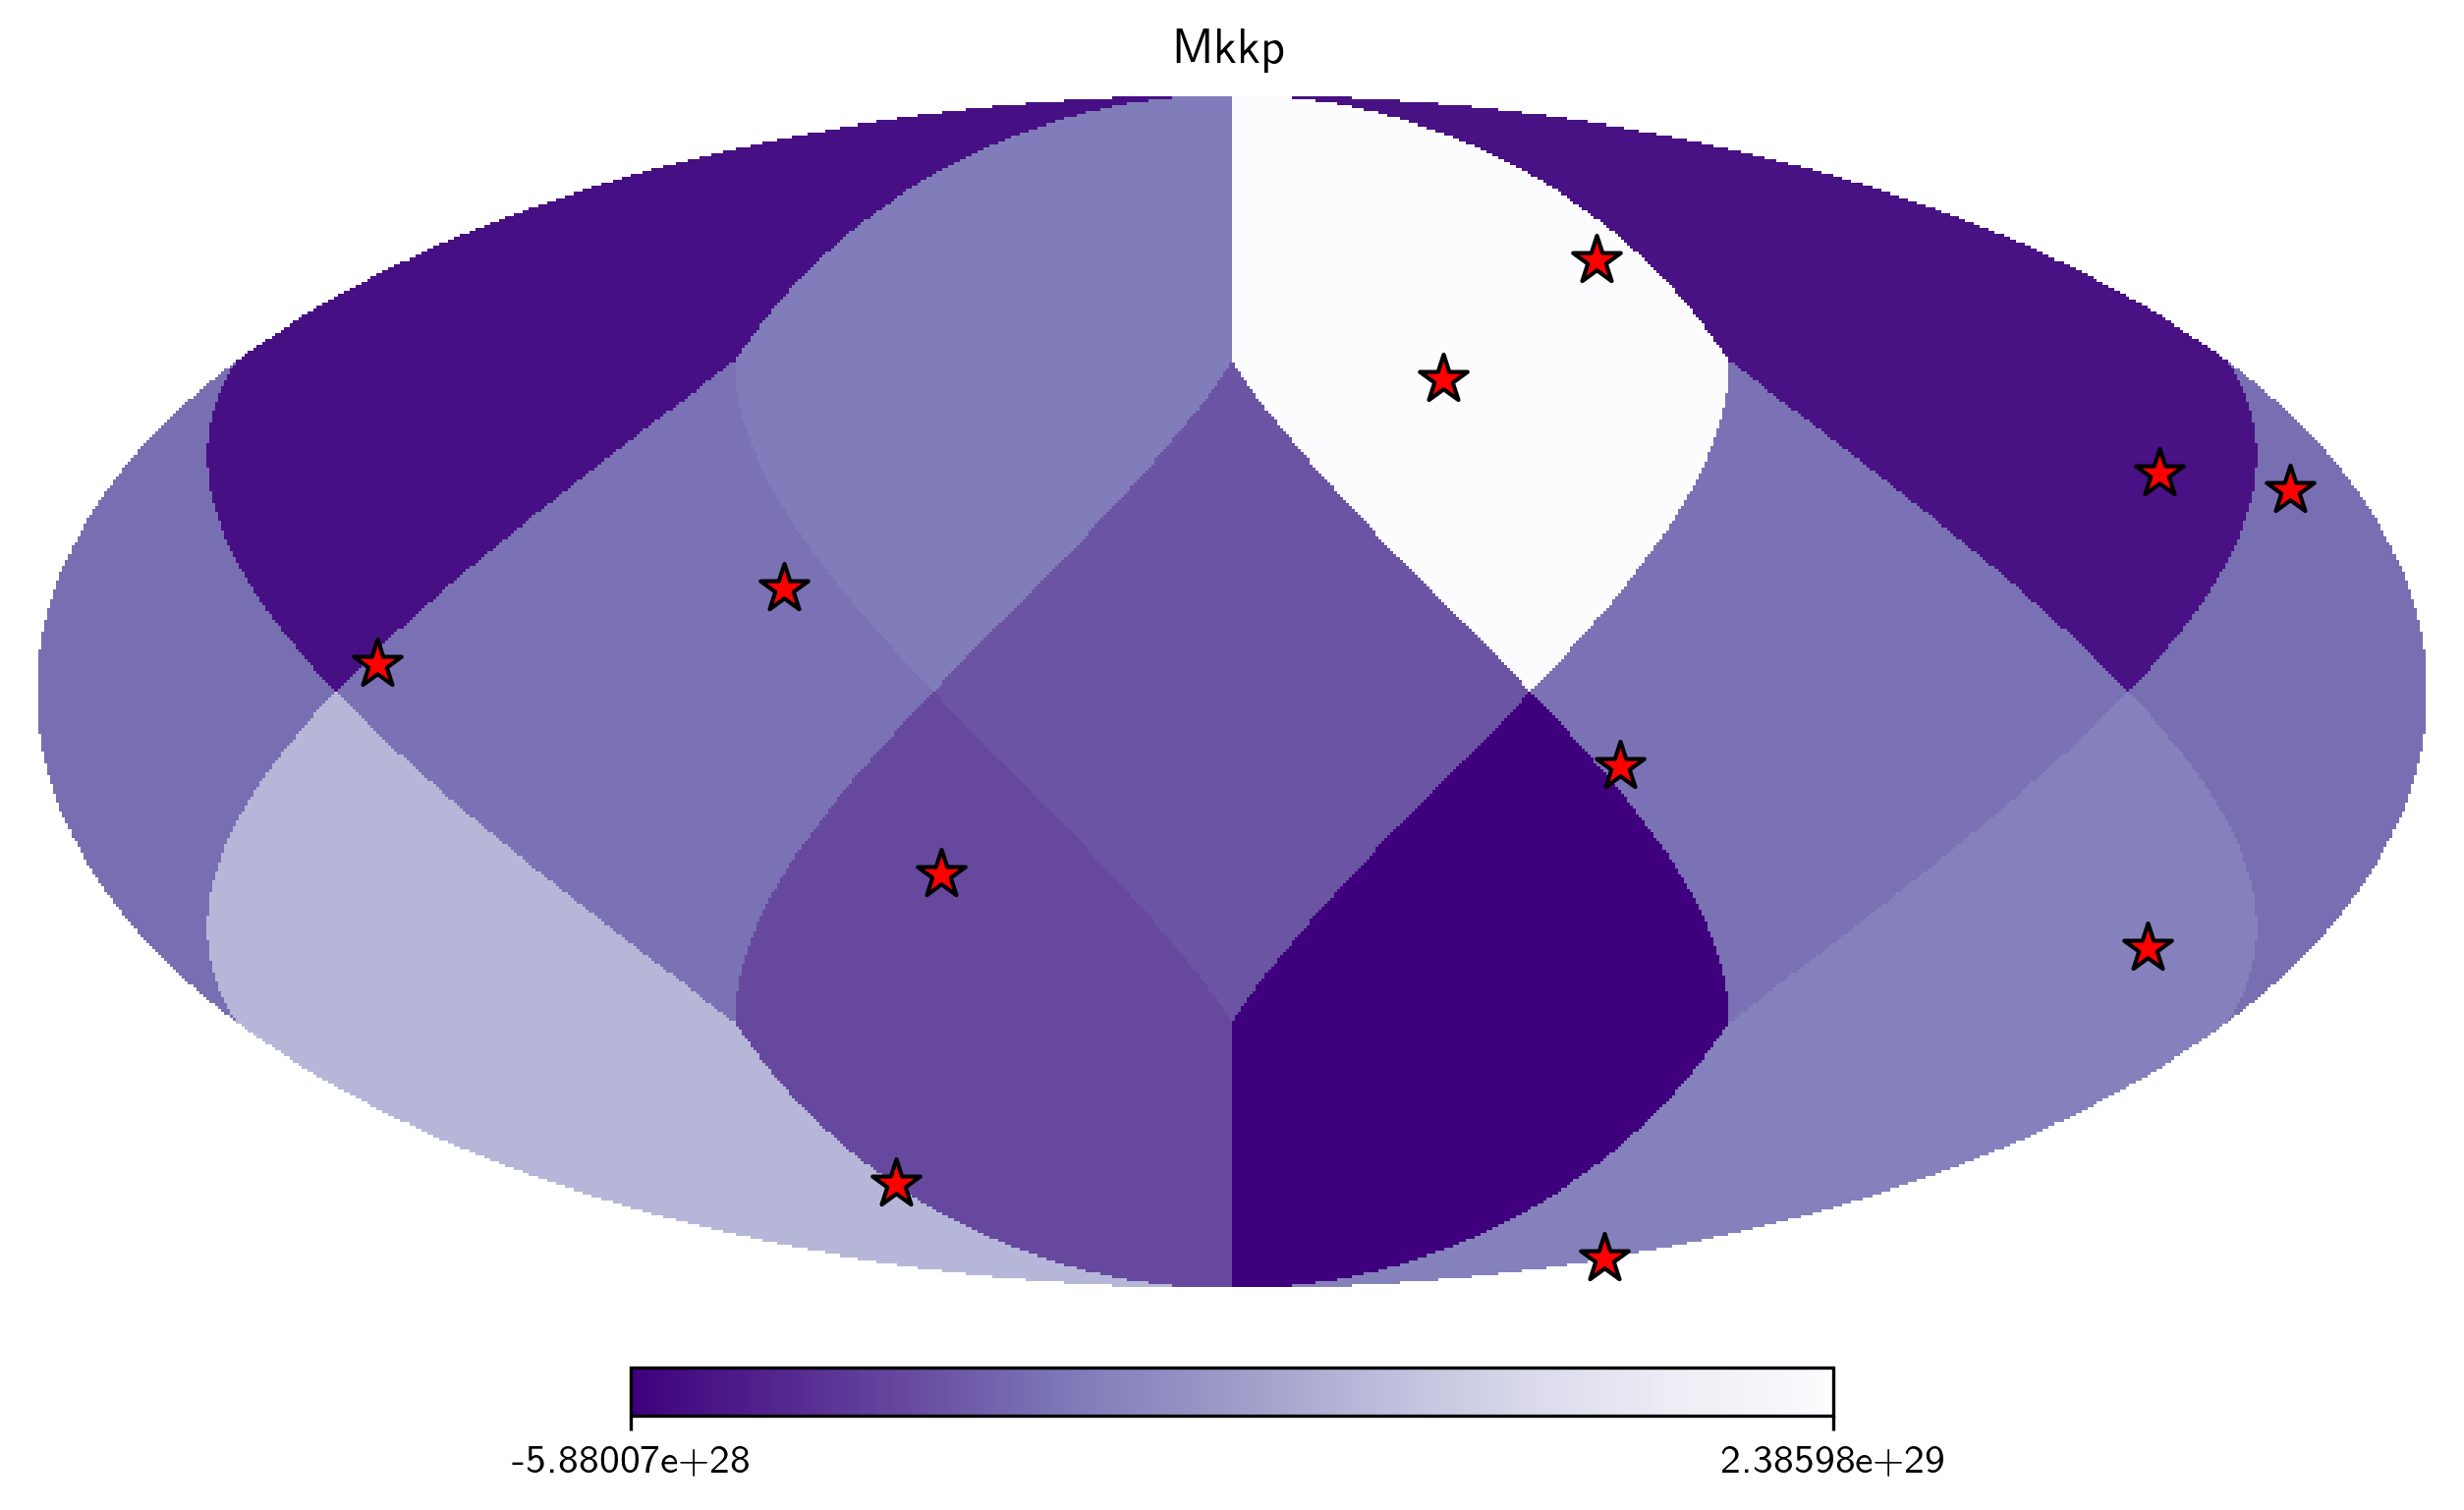

In [ ]:
Mkkp = ASM.M_kkp 
Mkkp_theta = Mkkp[min_index][1]-Mkkp[min_index][0]

hp.mollview(Mkkp[min_index][1], title="Mkkp", cmap='Purples_r', rot=(180,0,0))

hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
                            edgecolors='black', s=150, rot=(180,0,0))

fi: 129, fixed_kp: 0, fixed_k: 0
theta_kp: 0.06805451385130692, phi_kp: 0.7853981633974483
theta_k: 0.06805451385130692, phi_k: 0.7853981633974483


/var/folders/0_/5g1f83z542548054df5gwwpr0000gq/T/ipykernel_35483/3824828295.py:59: RuntimeWarning: invalid value encountered in sqrt
  M_kk_scale = np.sqrt(Mkkp[fi, :, fixed_kp]) / Tspan
/var/folders/0_/5g1f83z542548054df5gwwpr0000gq/T/ipykernel_35483/3824828295.py:60: RuntimeWarning: invalid value encountered in sqrt
  M_kkp_scale = np.sqrt(Mkkp[fi, fixed_k, :]) / Tspan


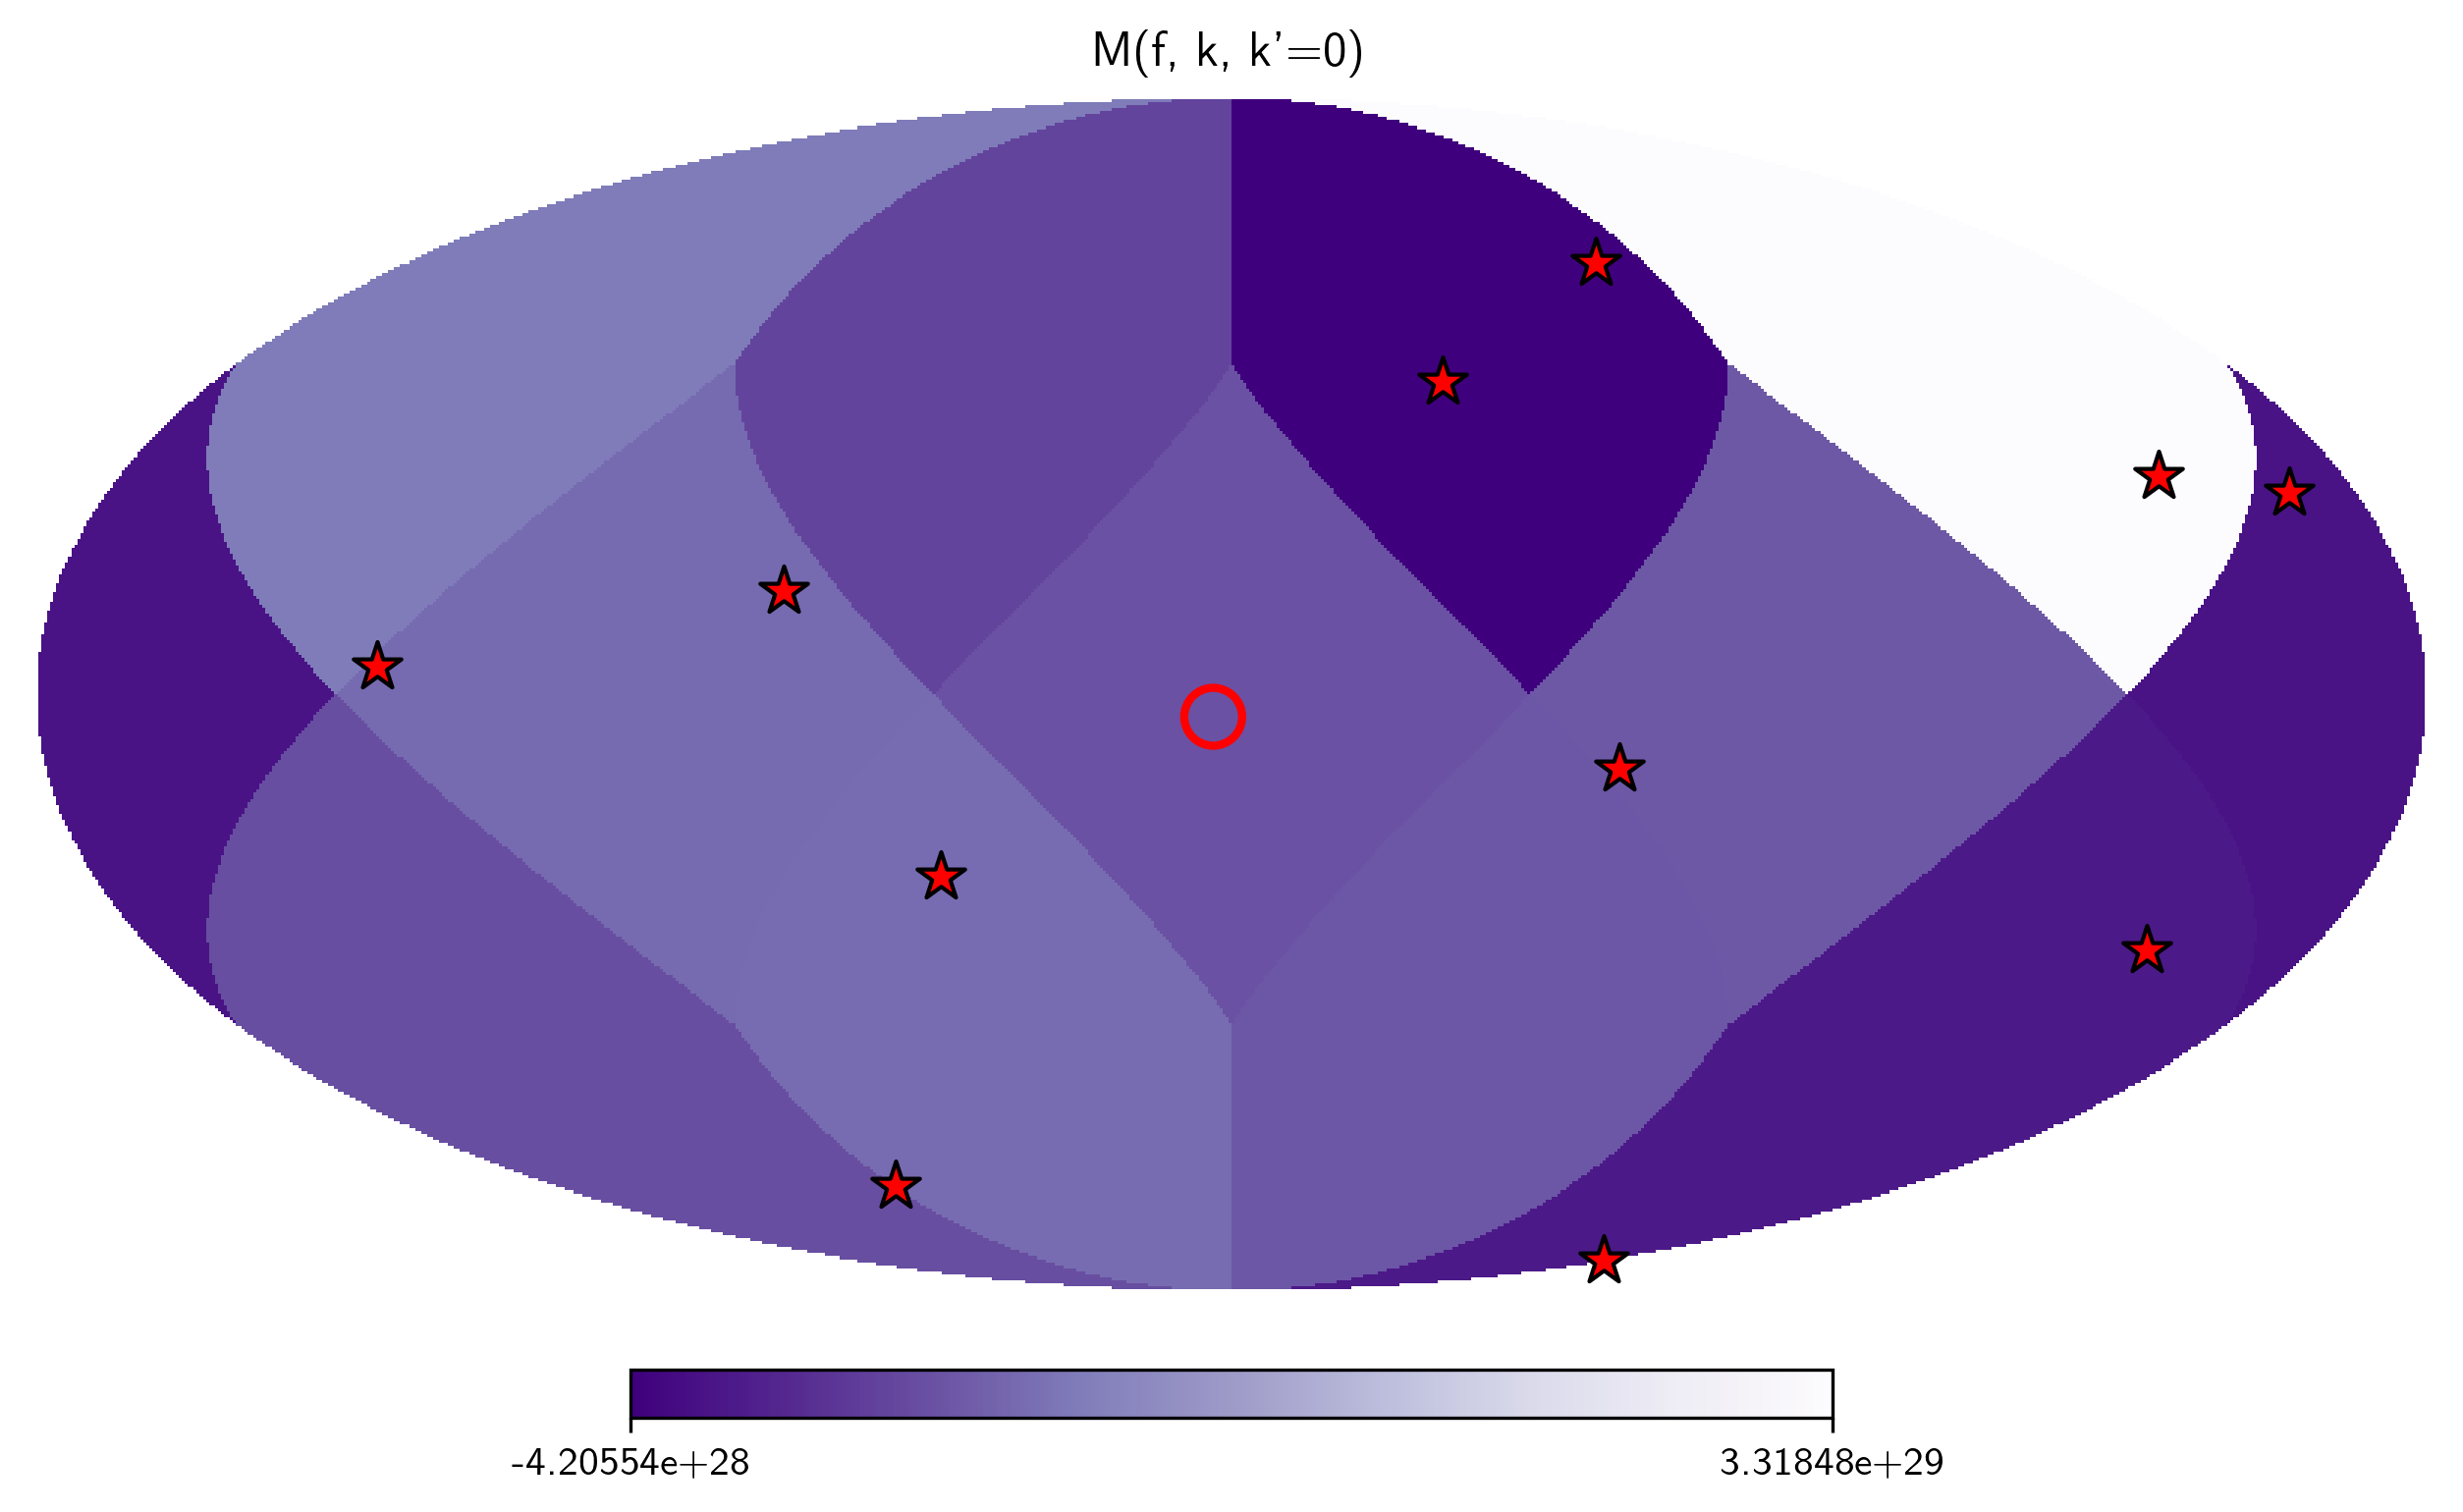

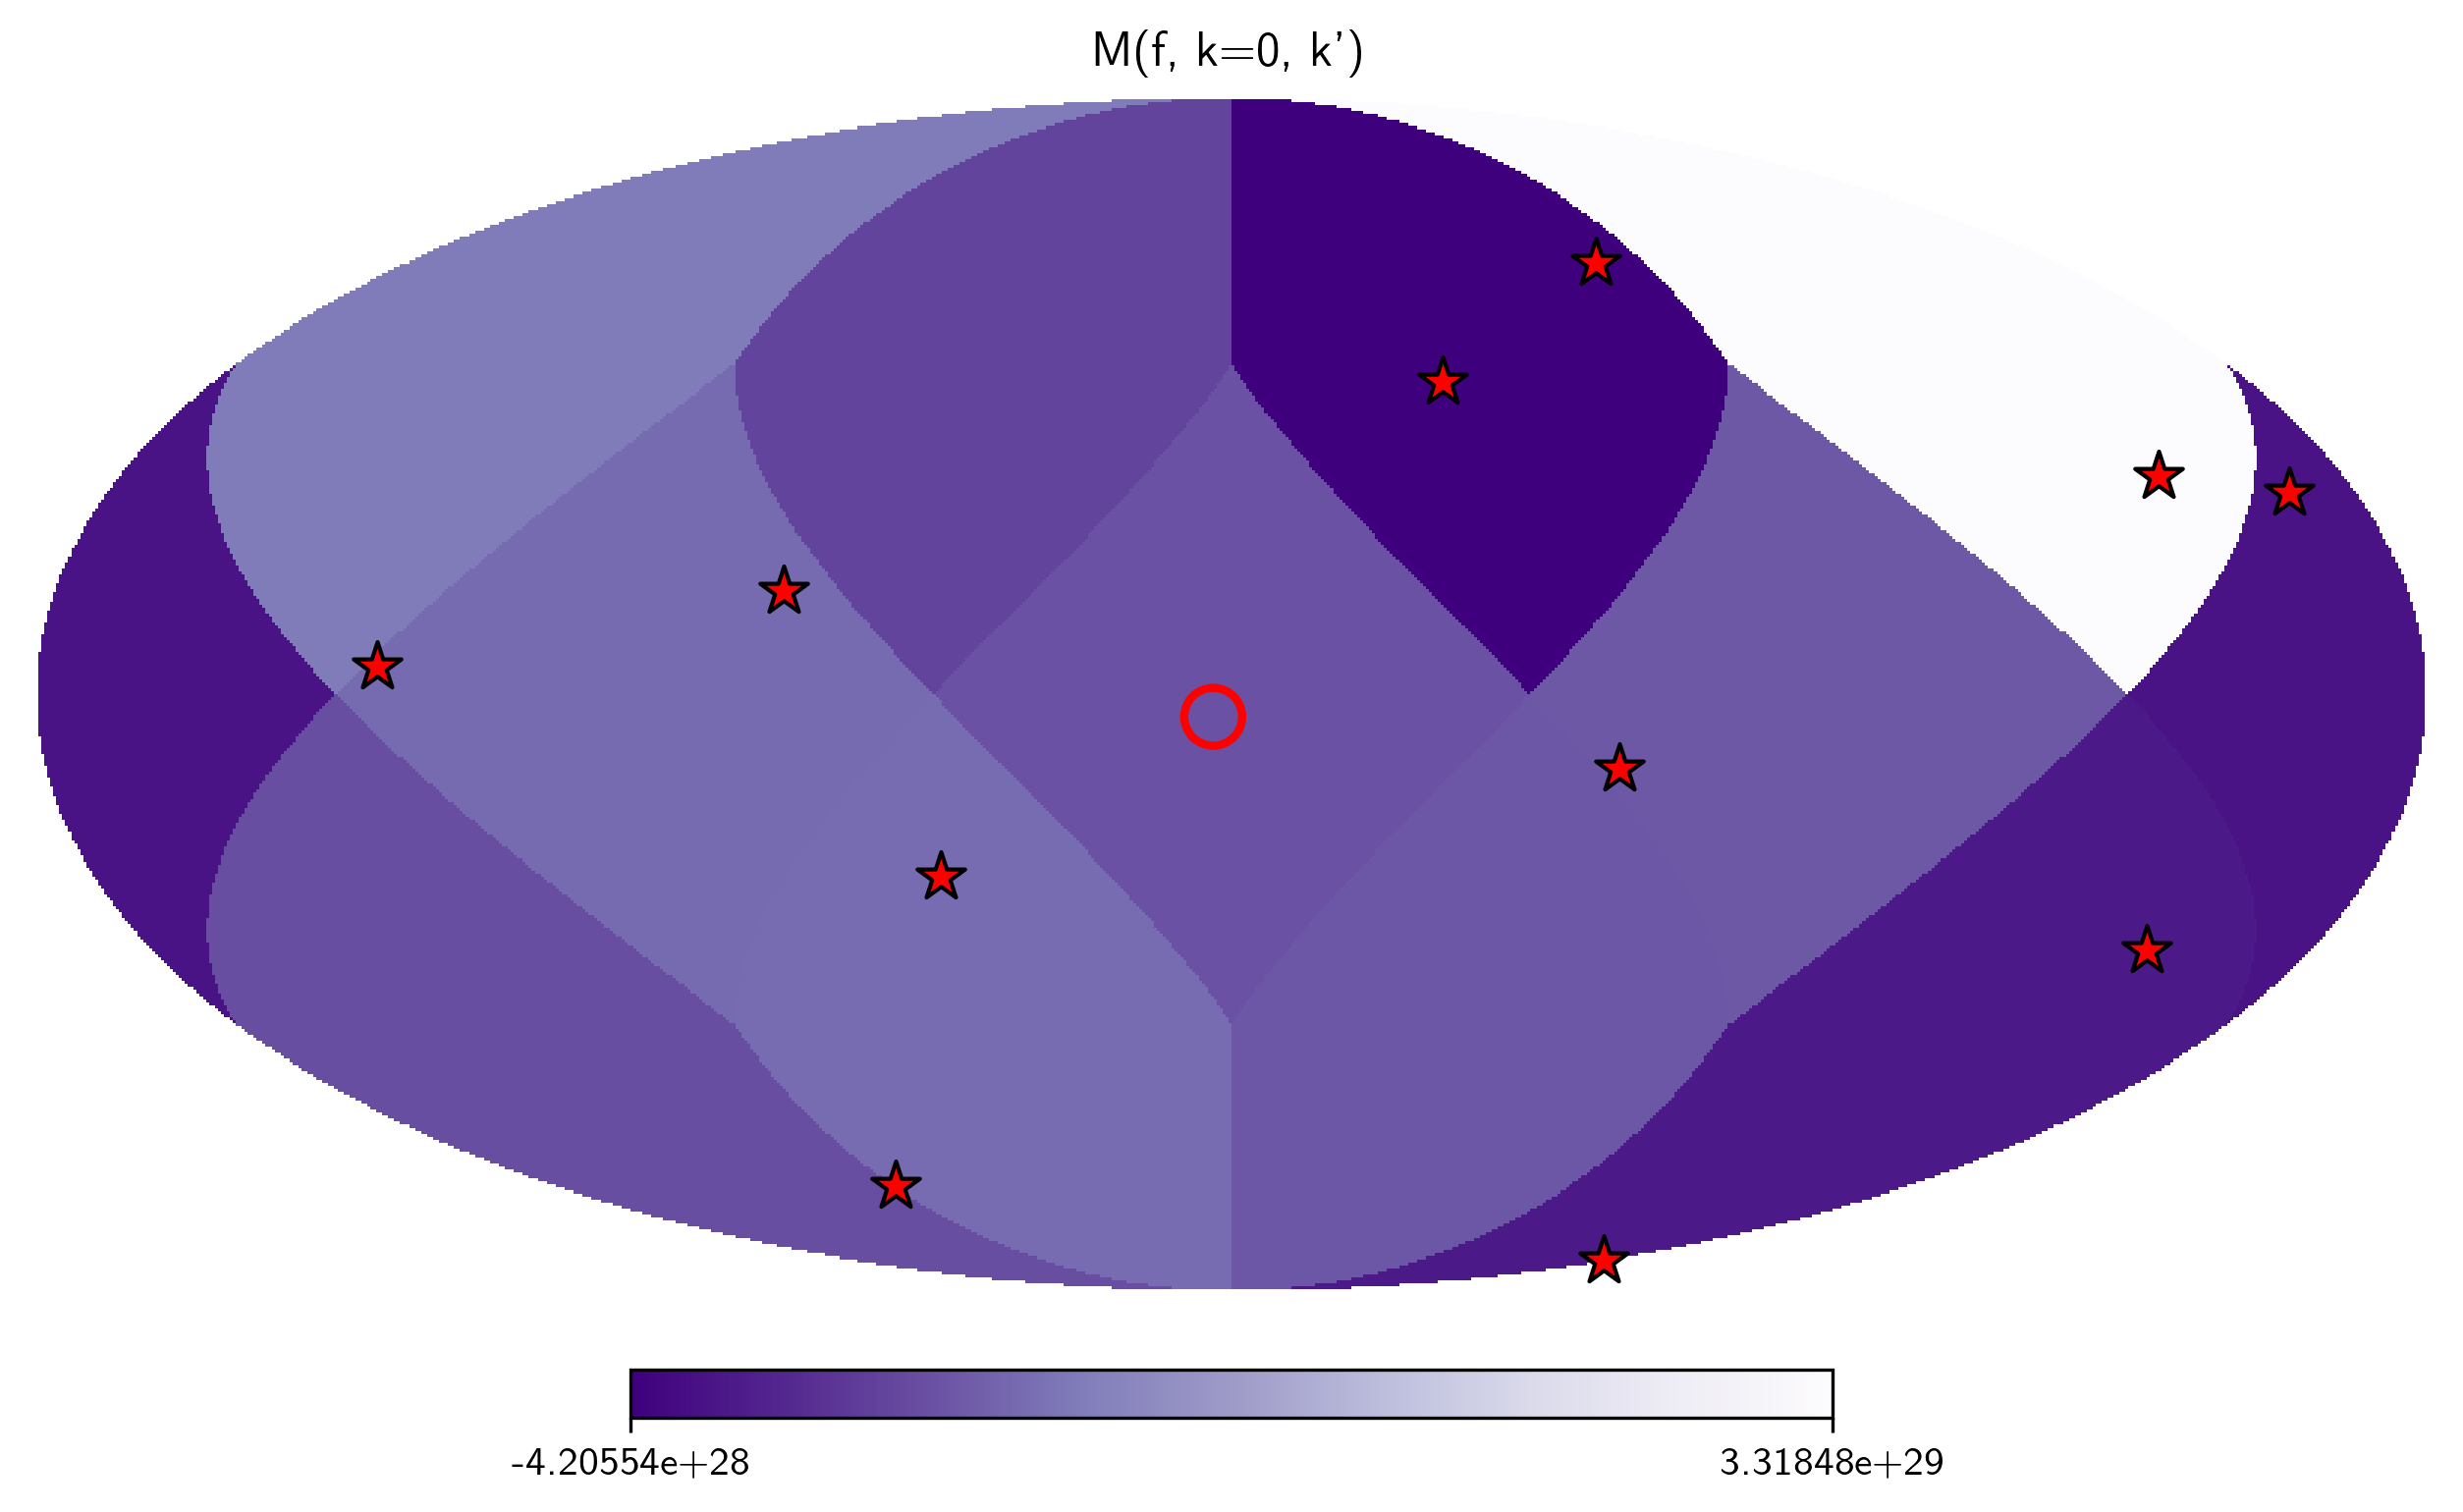

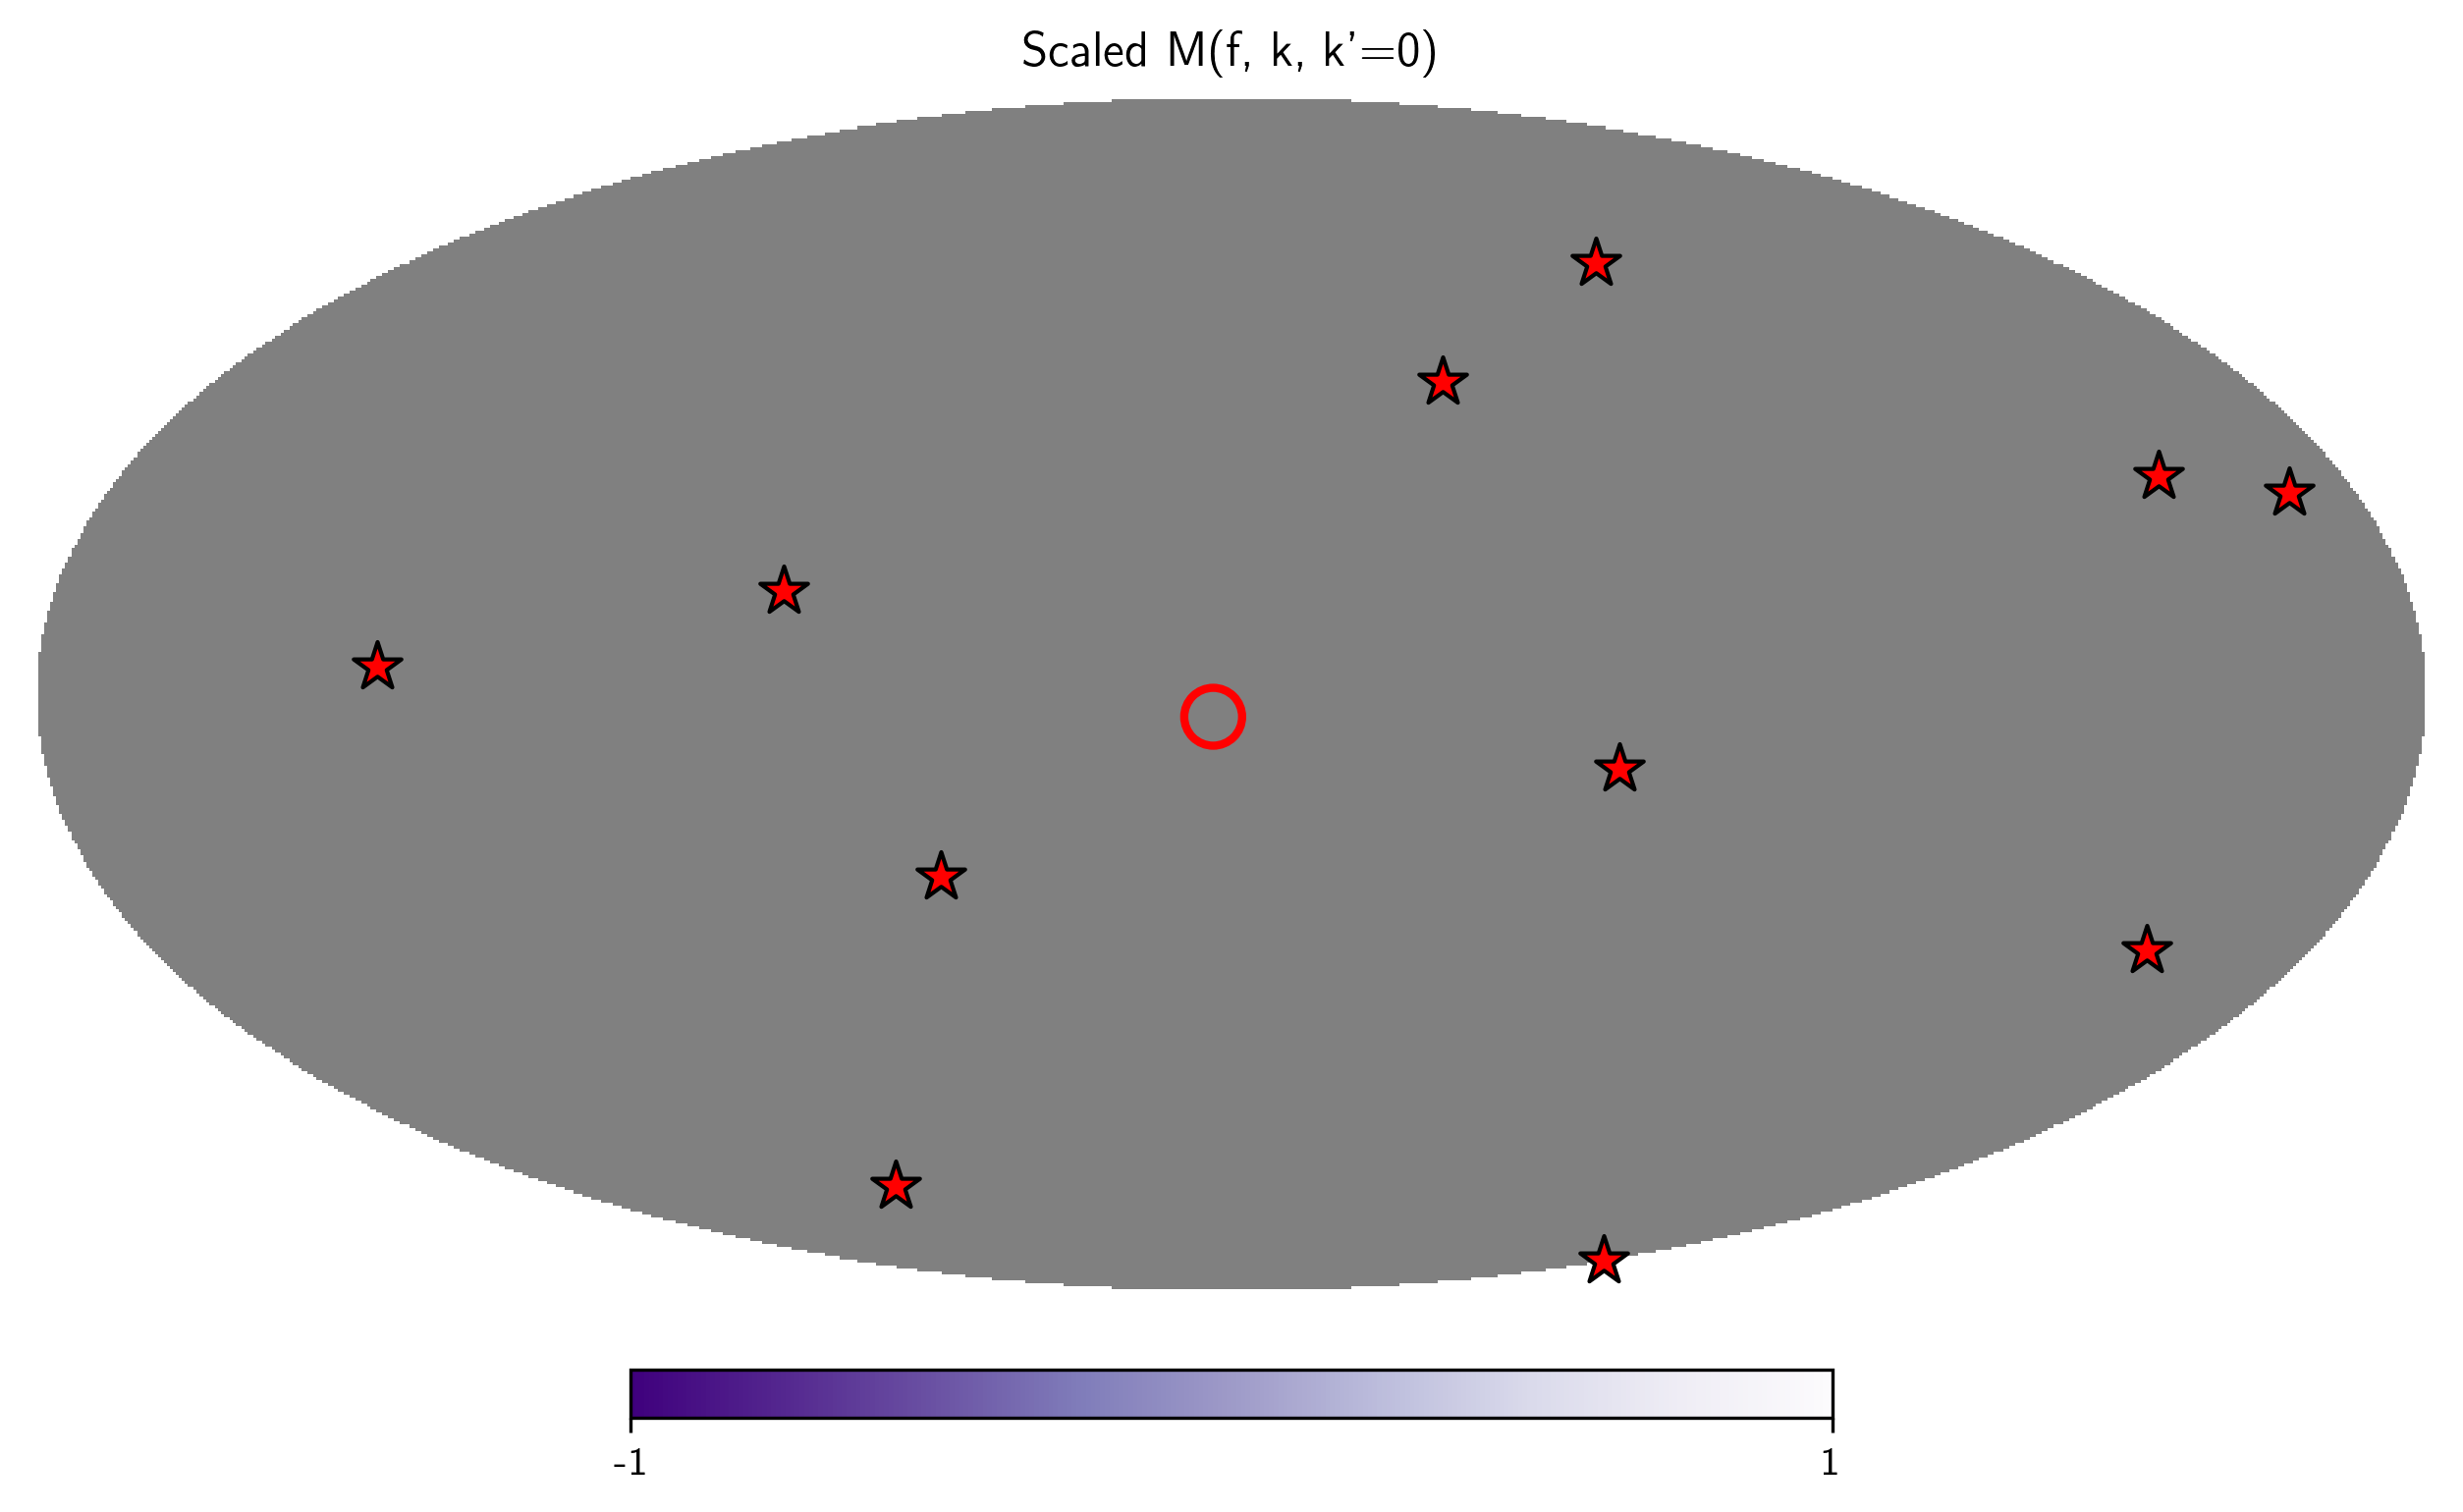

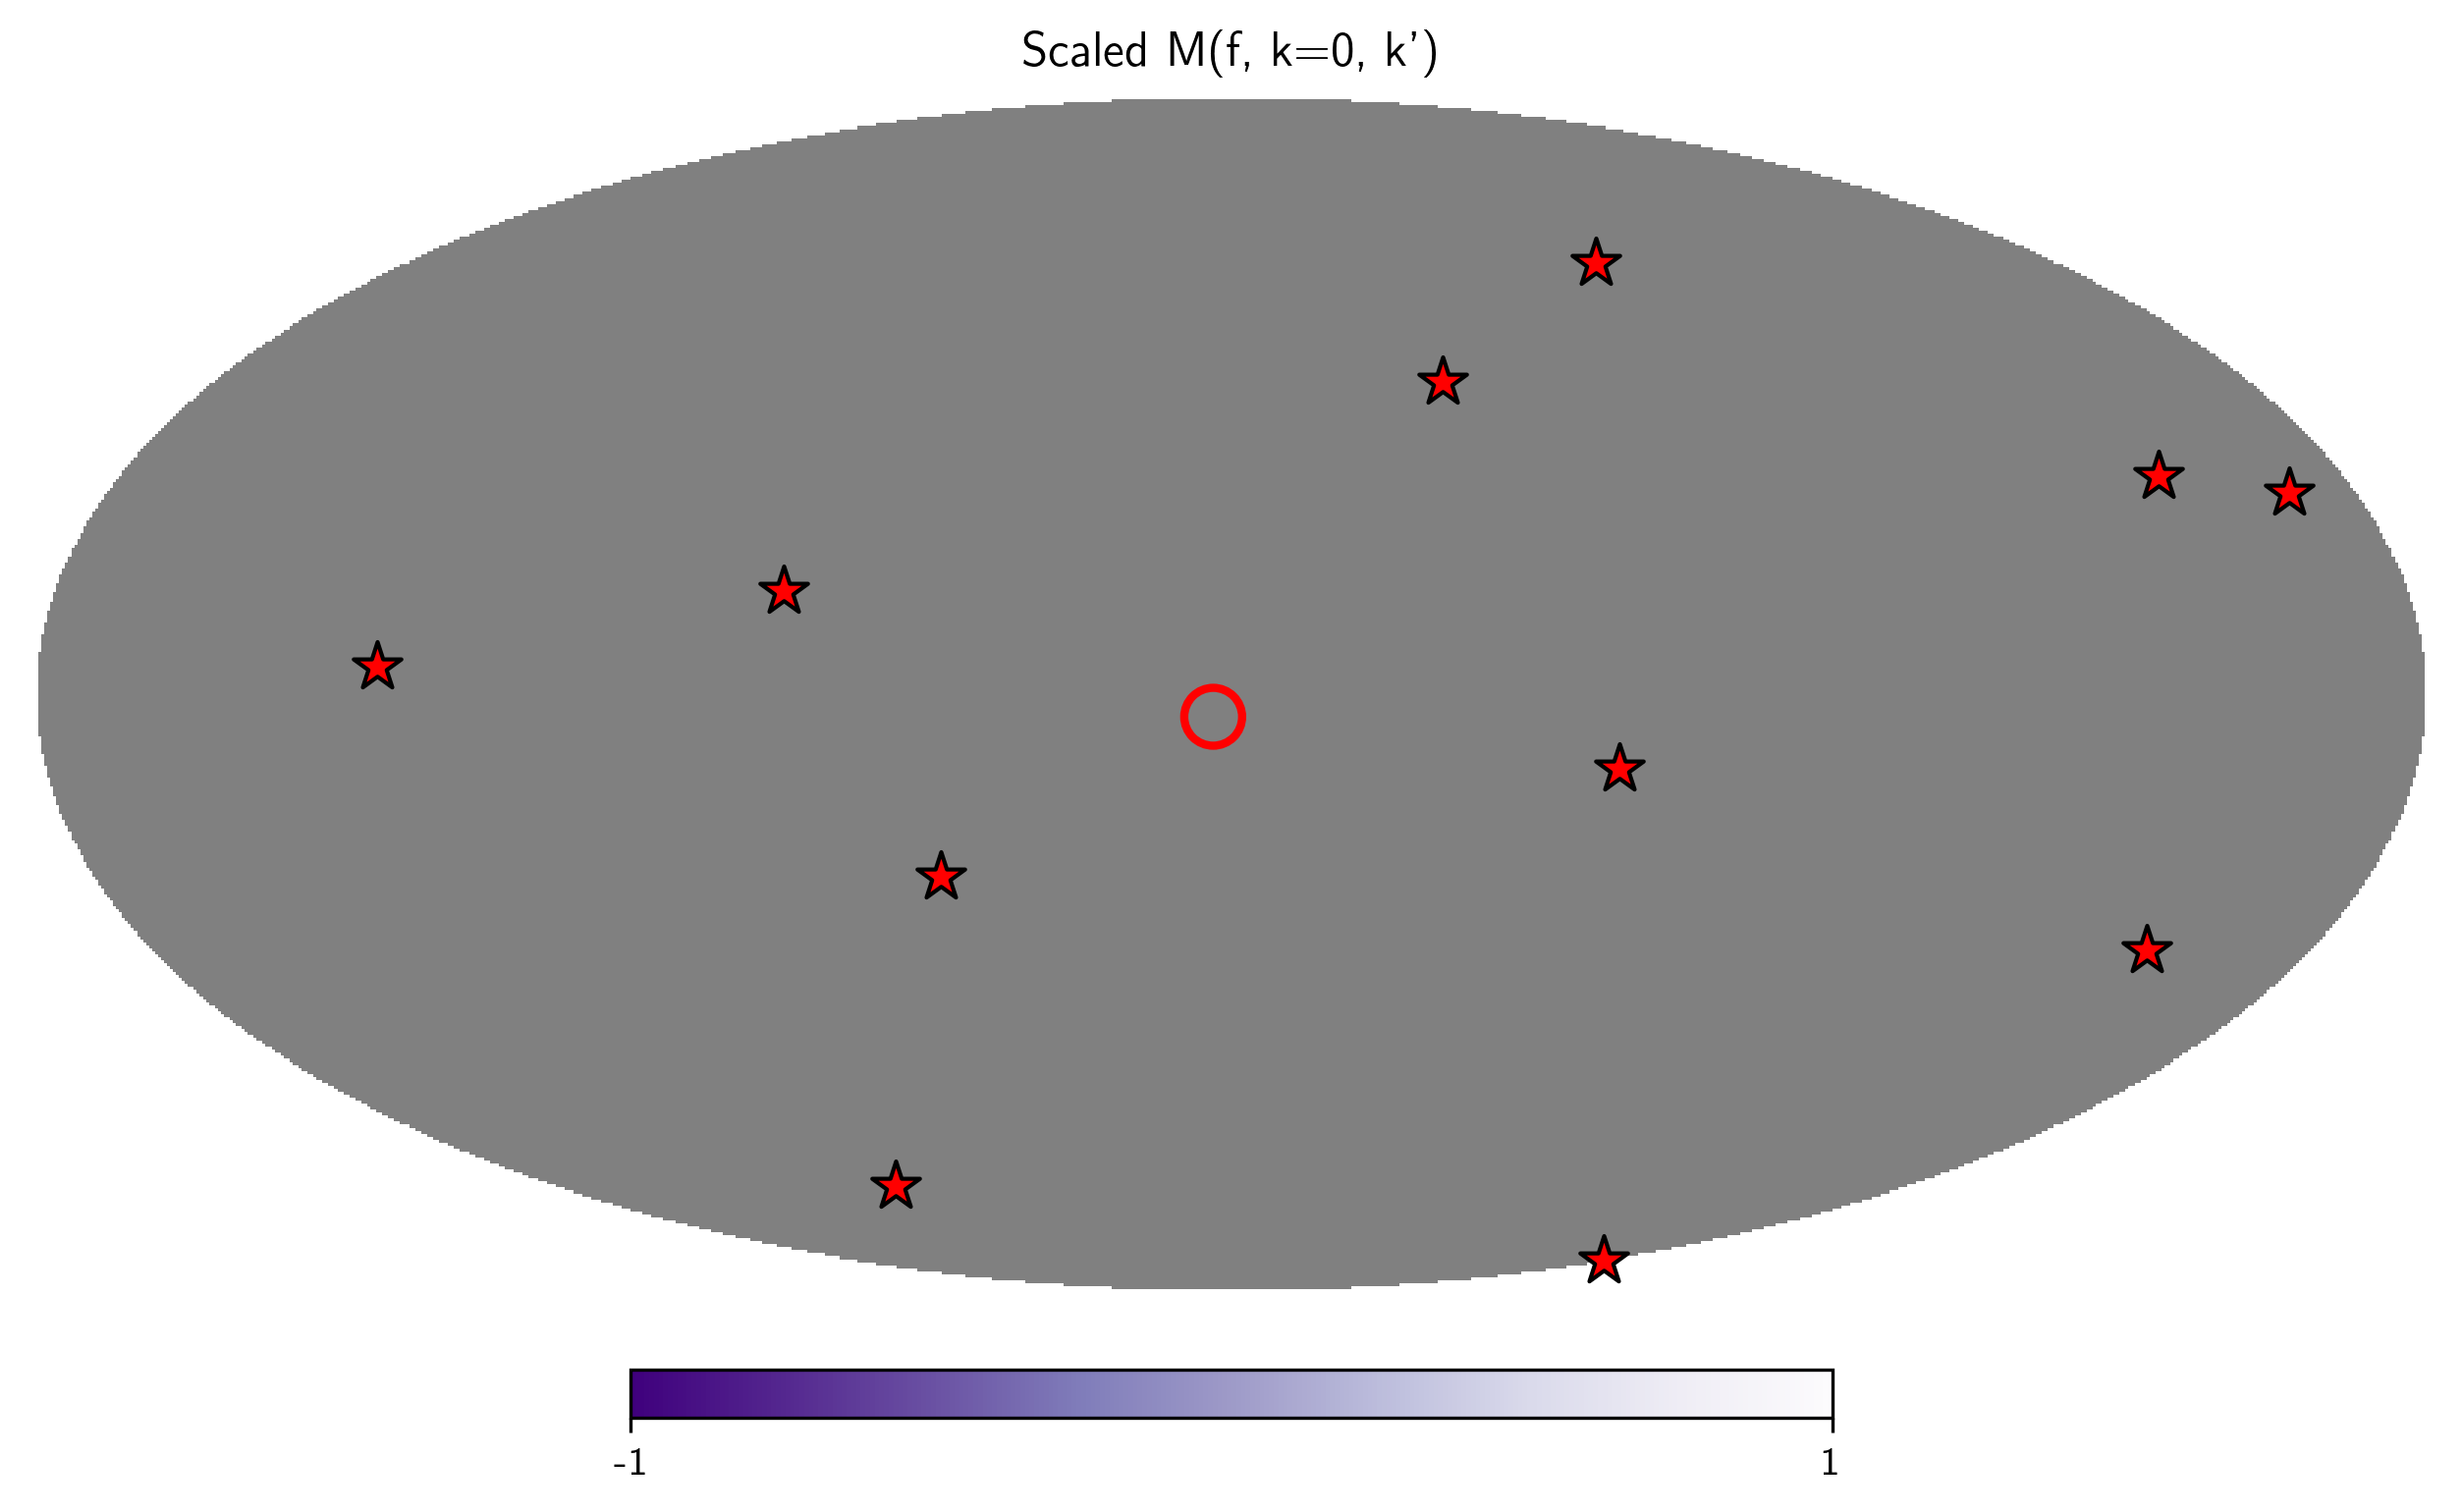

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

# Assume these are already defined or passed earlier
# ASM = haniso.Anisotropy(spectra, theta_gw, phi_gw, NPIX=NPIX)
# Mkkp = ASM.M_kkp  # Shape: (N_freqs, N_pix, N_pix)

fi = min_index  # Frequency index
fixed_kp = np.random.randint(0, Mkkp.shape[2])  # Fixed pixel k'
fixed_k = np.random.randint(0, Mkkp.shape[1])   # Fixed pixel k
fixed_kp = 0
fixed_k = 0
print(f"fi: {fi}, fixed_kp: {fixed_kp}, fixed_k: {fixed_k}")

# Angular coordinates of fixed pixels
theta_kp, phi_kp = hp.pix2ang(ASM.NPIX, fixed_kp)
theta_k, phi_k = hp.pix2ang(ASM.NPIX, fixed_k)
print(f"theta_kp: {theta_kp}, phi_kp: {phi_kp}")
print(f"theta_k: {theta_k}, phi_k: {phi_k}")

# Map slices
map_k  = Mkkp[fi, :, fixed_kp]   # M(f, k, k'=fixed)
map_kp = Mkkp[fi, fixed_k, :]    # M(f, k=fixed, k')

# First plot: fixed k'
hp.mollview(map_k, title=f"M(f, k, k'={fixed_kp})", cmap='Purples_r',
            rot=(180, 0, 0))

# Highlight fixed_kp with red outline
hp.visufunc.projscatter([theta_kp], [phi_kp],
                        marker='o', color='none', edgecolors='red',
                        linewidths=2, s=200, rot=(180, 0, 0))

# Optional: overlay GW sources
hp.visufunc.projscatter(ASM.thetas, ASM.phis,
                        marker='*', color='red', edgecolors='black',
                        s=150, rot=(180, 0, 0))

# plt.savefig('40yr_Mkkp_fixed_kp.pdf', dpi=300, bbox_inches='tight', facecolor='w')

# Second plot: fixed k
hp.mollview(map_kp, title=f"M(f, k={fixed_k}, k')", cmap='Purples_r',
            rot=(180, 0, 0))

# Highlight fixed_k with red outline
hp.visufunc.projscatter([theta_k], [phi_k],
                        marker='o', color='none', edgecolors='red',
                        linewidths=2, s=200, rot=(180, 0, 0))

hp.visufunc.projscatter(ASM.thetas, ASM.phis,
                        marker='*', color='red', edgecolors='black',
                        s=150, rot=(180, 0, 0))

# plt.savefig('40yr_Mkkp_fixed_k.pdf', dpi=300, bbox_inches='tight', facecolor='w')

# Normalize and scale

M_kk_scale = np.sqrt(Mkkp[fi, :, fixed_kp]) / Tspan
M_kkp_scale = np.sqrt(Mkkp[fi, fixed_k, :]) / Tspan

M_kk_norm = (M_kk_scale - np.min(M_kk_scale)) / (np.max(M_kk_scale) - np.min(M_kk_scale))
M_kkp_norm = (M_kkp_scale - np.min(M_kkp_scale)) / (np.max(M_kkp_scale) - np.min(M_kkp_scale))

# Scaled plot: fixed k'
hp.mollview(M_kk_norm, title=f"Scaled M(f, k, k'={fixed_kp})", cmap='Purples_r',
            rot=(180, 0, 0))

hp.visufunc.projscatter([theta_kp], [phi_kp],
                        marker='o', color='none', edgecolors='red',
                        linewidths=2, s=200, rot=(180, 0, 0))

hp.visufunc.projscatter(ASM.thetas, ASM.phis,
                        marker='*', color='red', edgecolors='black',
                        s=150, rot=(180, 0, 0))

# plt.savefig('40yr_Mkkp_scaled_fixed_kp.pdf', dpi=300, bbox_inches='tight', facecolor='w')

# Scaled plot: fixed k
hp.mollview(M_kkp_norm, title=f"Scaled M(f, k={fixed_k}, k')", cmap='Purples_r',
            rot=(180, 0, 0))

hp.visufunc.projscatter([theta_k], [phi_k],
                        marker='o', color='none', edgecolors='red',
                        linewidths=2, s=200, rot=(180, 0, 0))

hp.visufunc.projscatter(ASM.thetas, ASM.phis,
                        marker='*', color='red', edgecolors='black',
                        s=150, rot=(180, 0, 0))

# plt.savefig('40yr_Mkkp_scaled_fixed_k.pdf', dpi=300, bbox_inches='tight', facecolor='w')
plt.show()


theta_b: [0.         0.84106867 1.57079633 0.84106867], phi_b: [ 0.         -1.57079633 -0.78539816  0.        ]


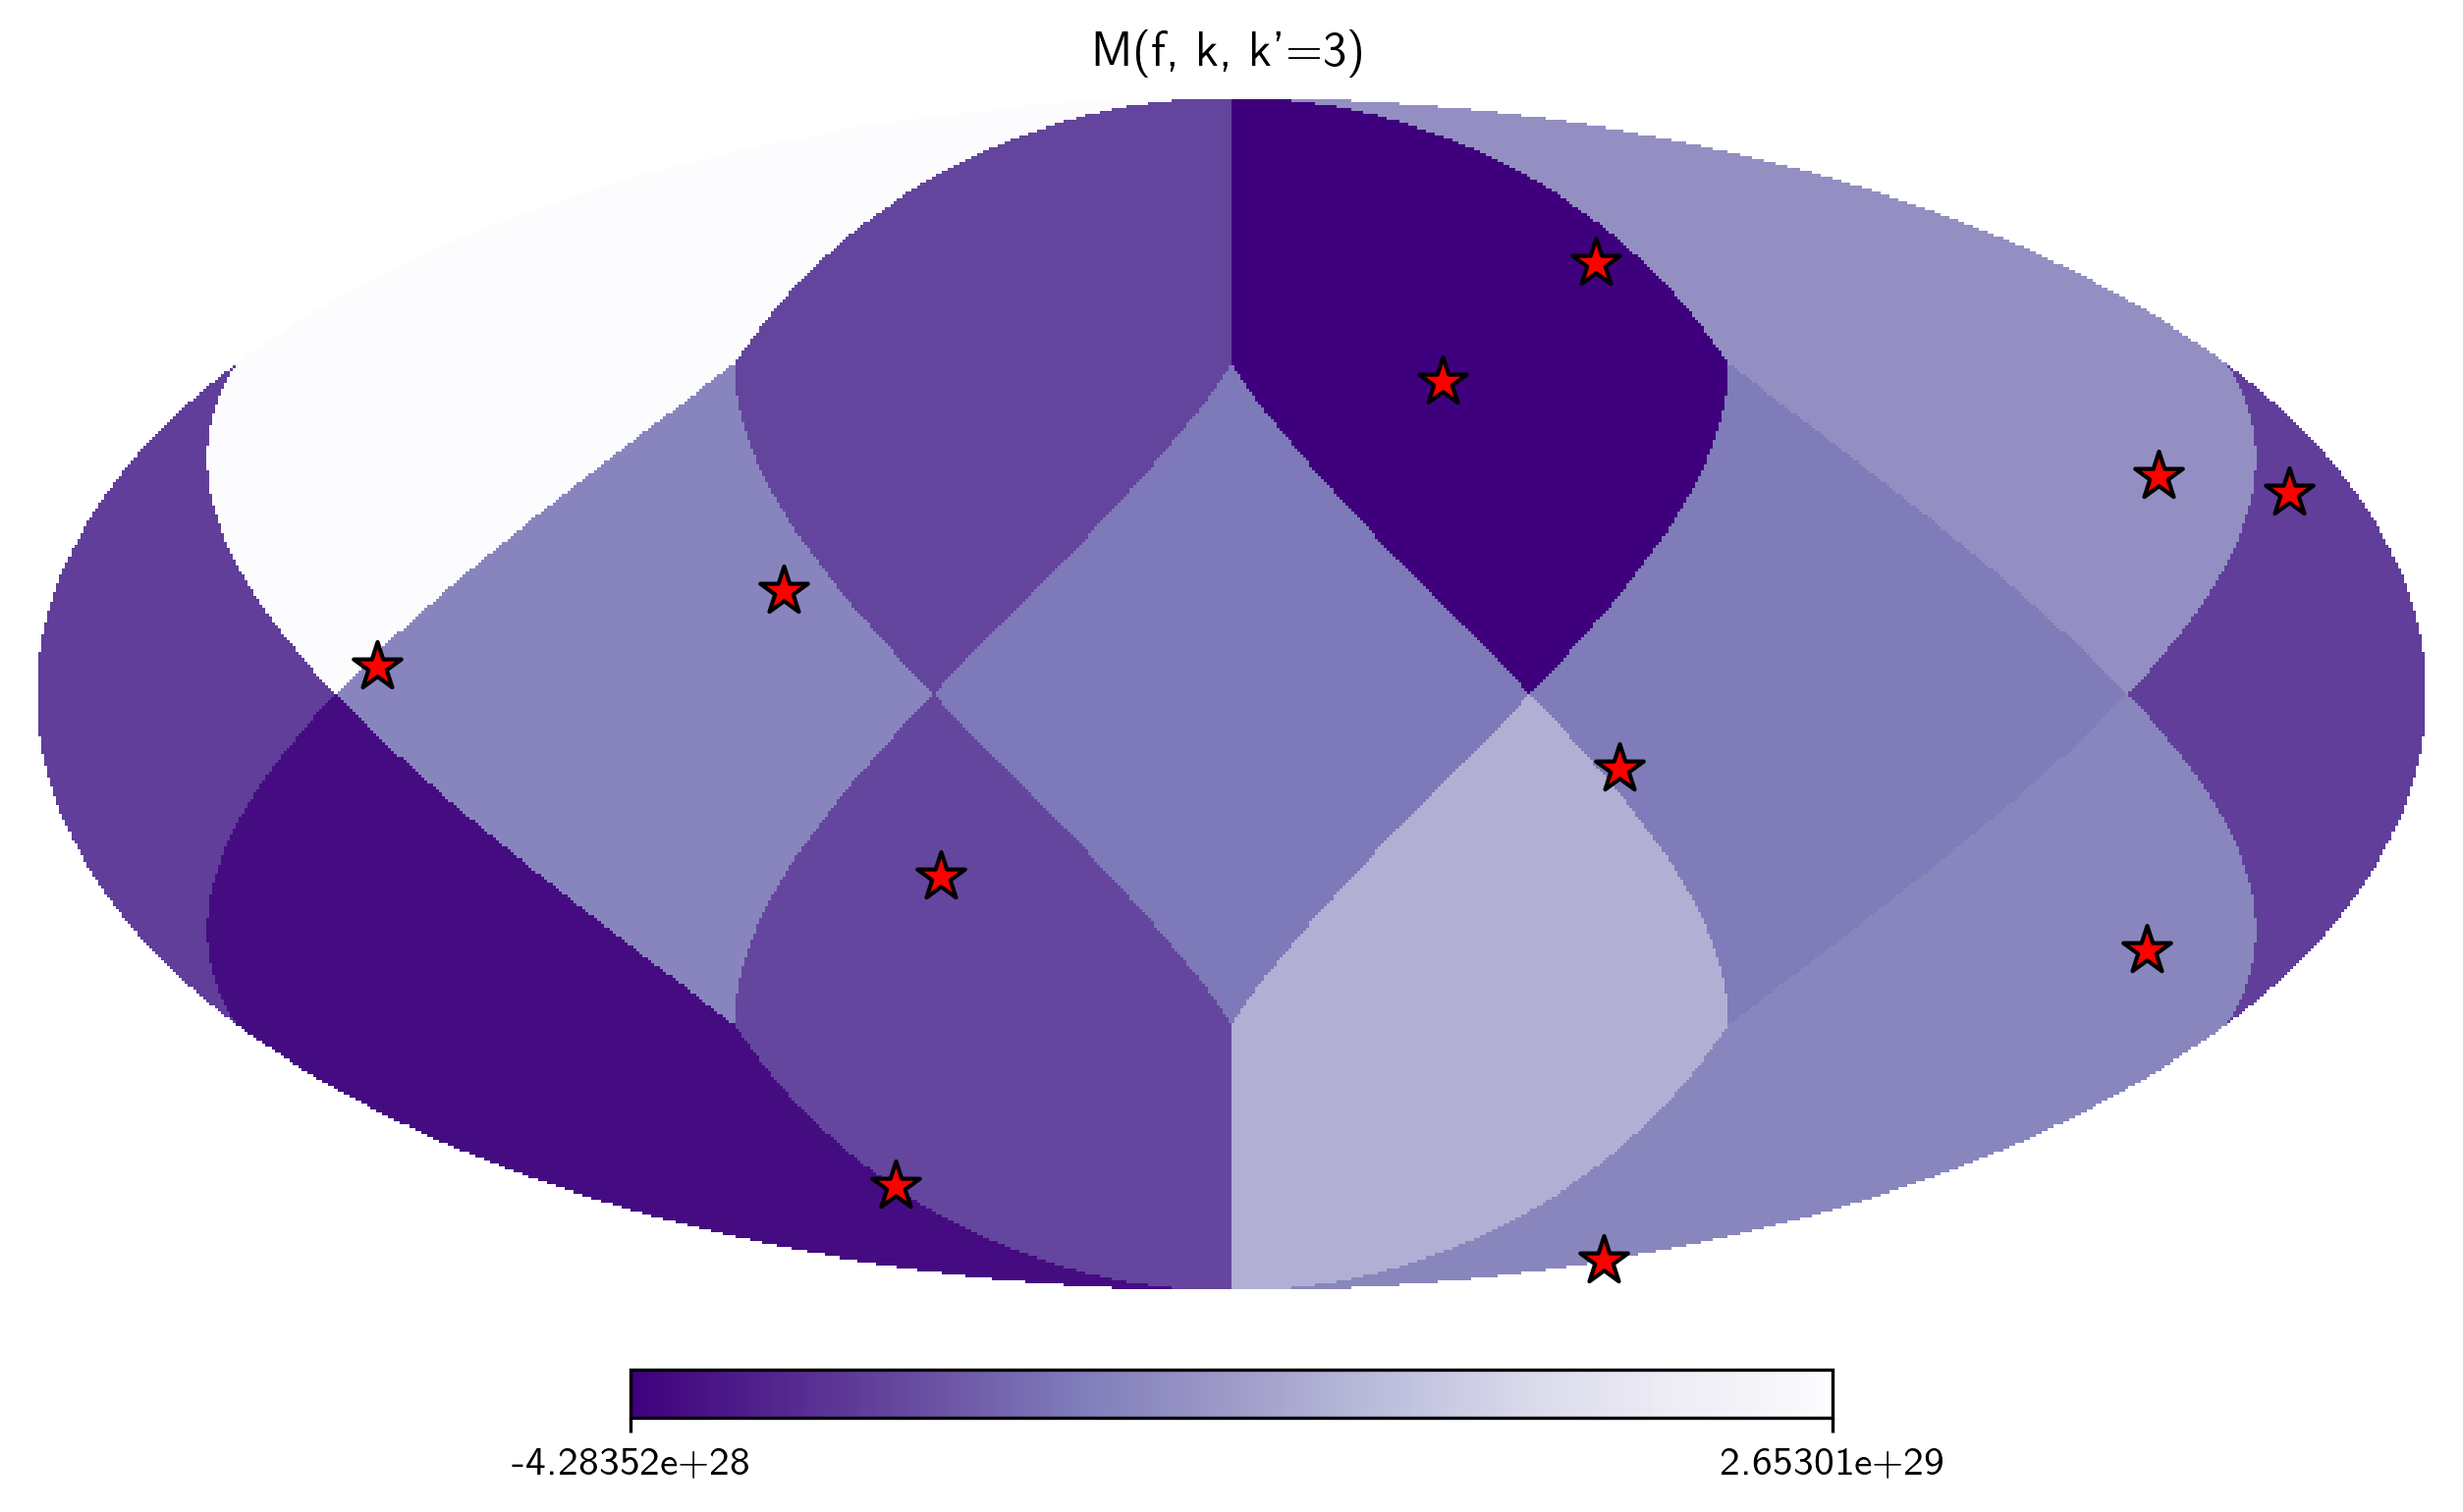

theta_b: [0.84106867 1.57079633 2.30052398 1.57079633], phi_b: [ 3.14159265  2.35619449  3.14159265 -2.35619449]


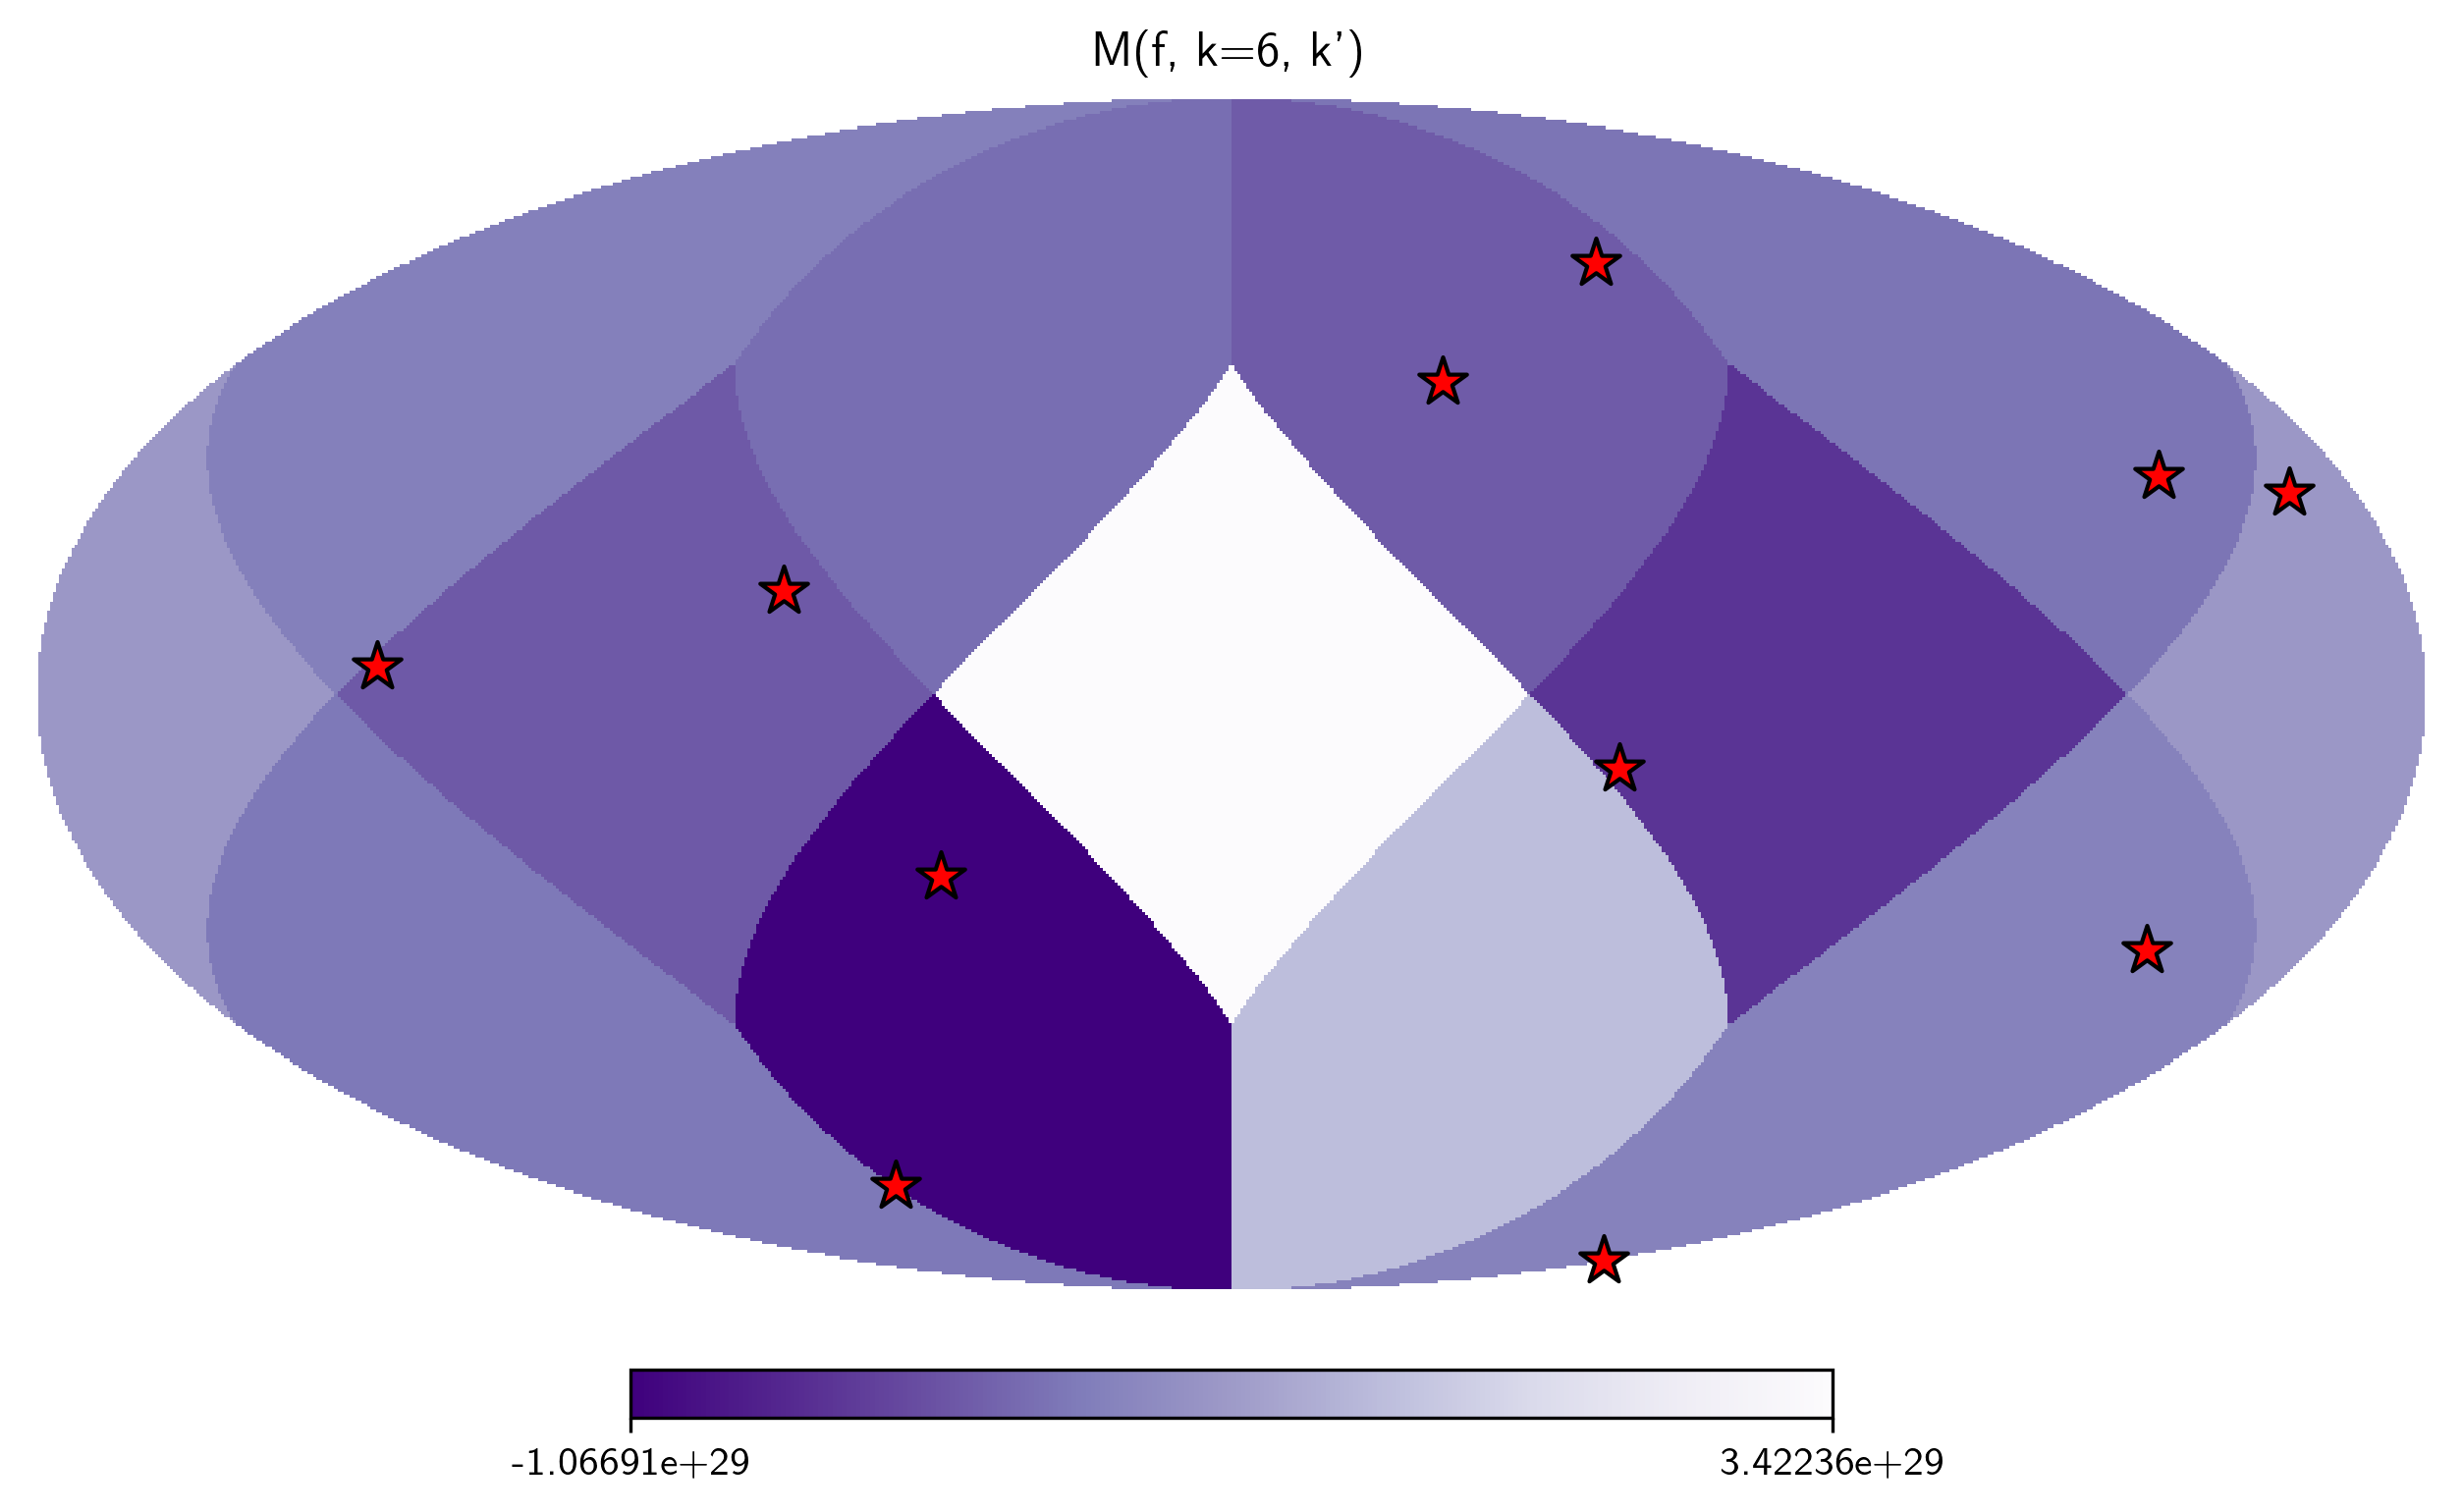

/var/folders/0_/5g1f83z542548054df5gwwpr0000gq/T/ipykernel_35483/1120300511.py:51: RuntimeWarning: invalid value encountered in sqrt
  M_kk_scale = np.sqrt(Mkkp[fi, :, fixed_kp]) / Tspan
/var/folders/0_/5g1f83z542548054df5gwwpr0000gq/T/ipykernel_35483/1120300511.py:52: RuntimeWarning: invalid value encountered in sqrt
  M_kkp_scale = np.sqrt(Mkkp[fi, fixed_k, :]) / Tspan


theta_b: [0.         0.84106867 1.57079633 0.84106867], phi_b: [ 0.         -1.57079633 -0.78539816  0.        ]


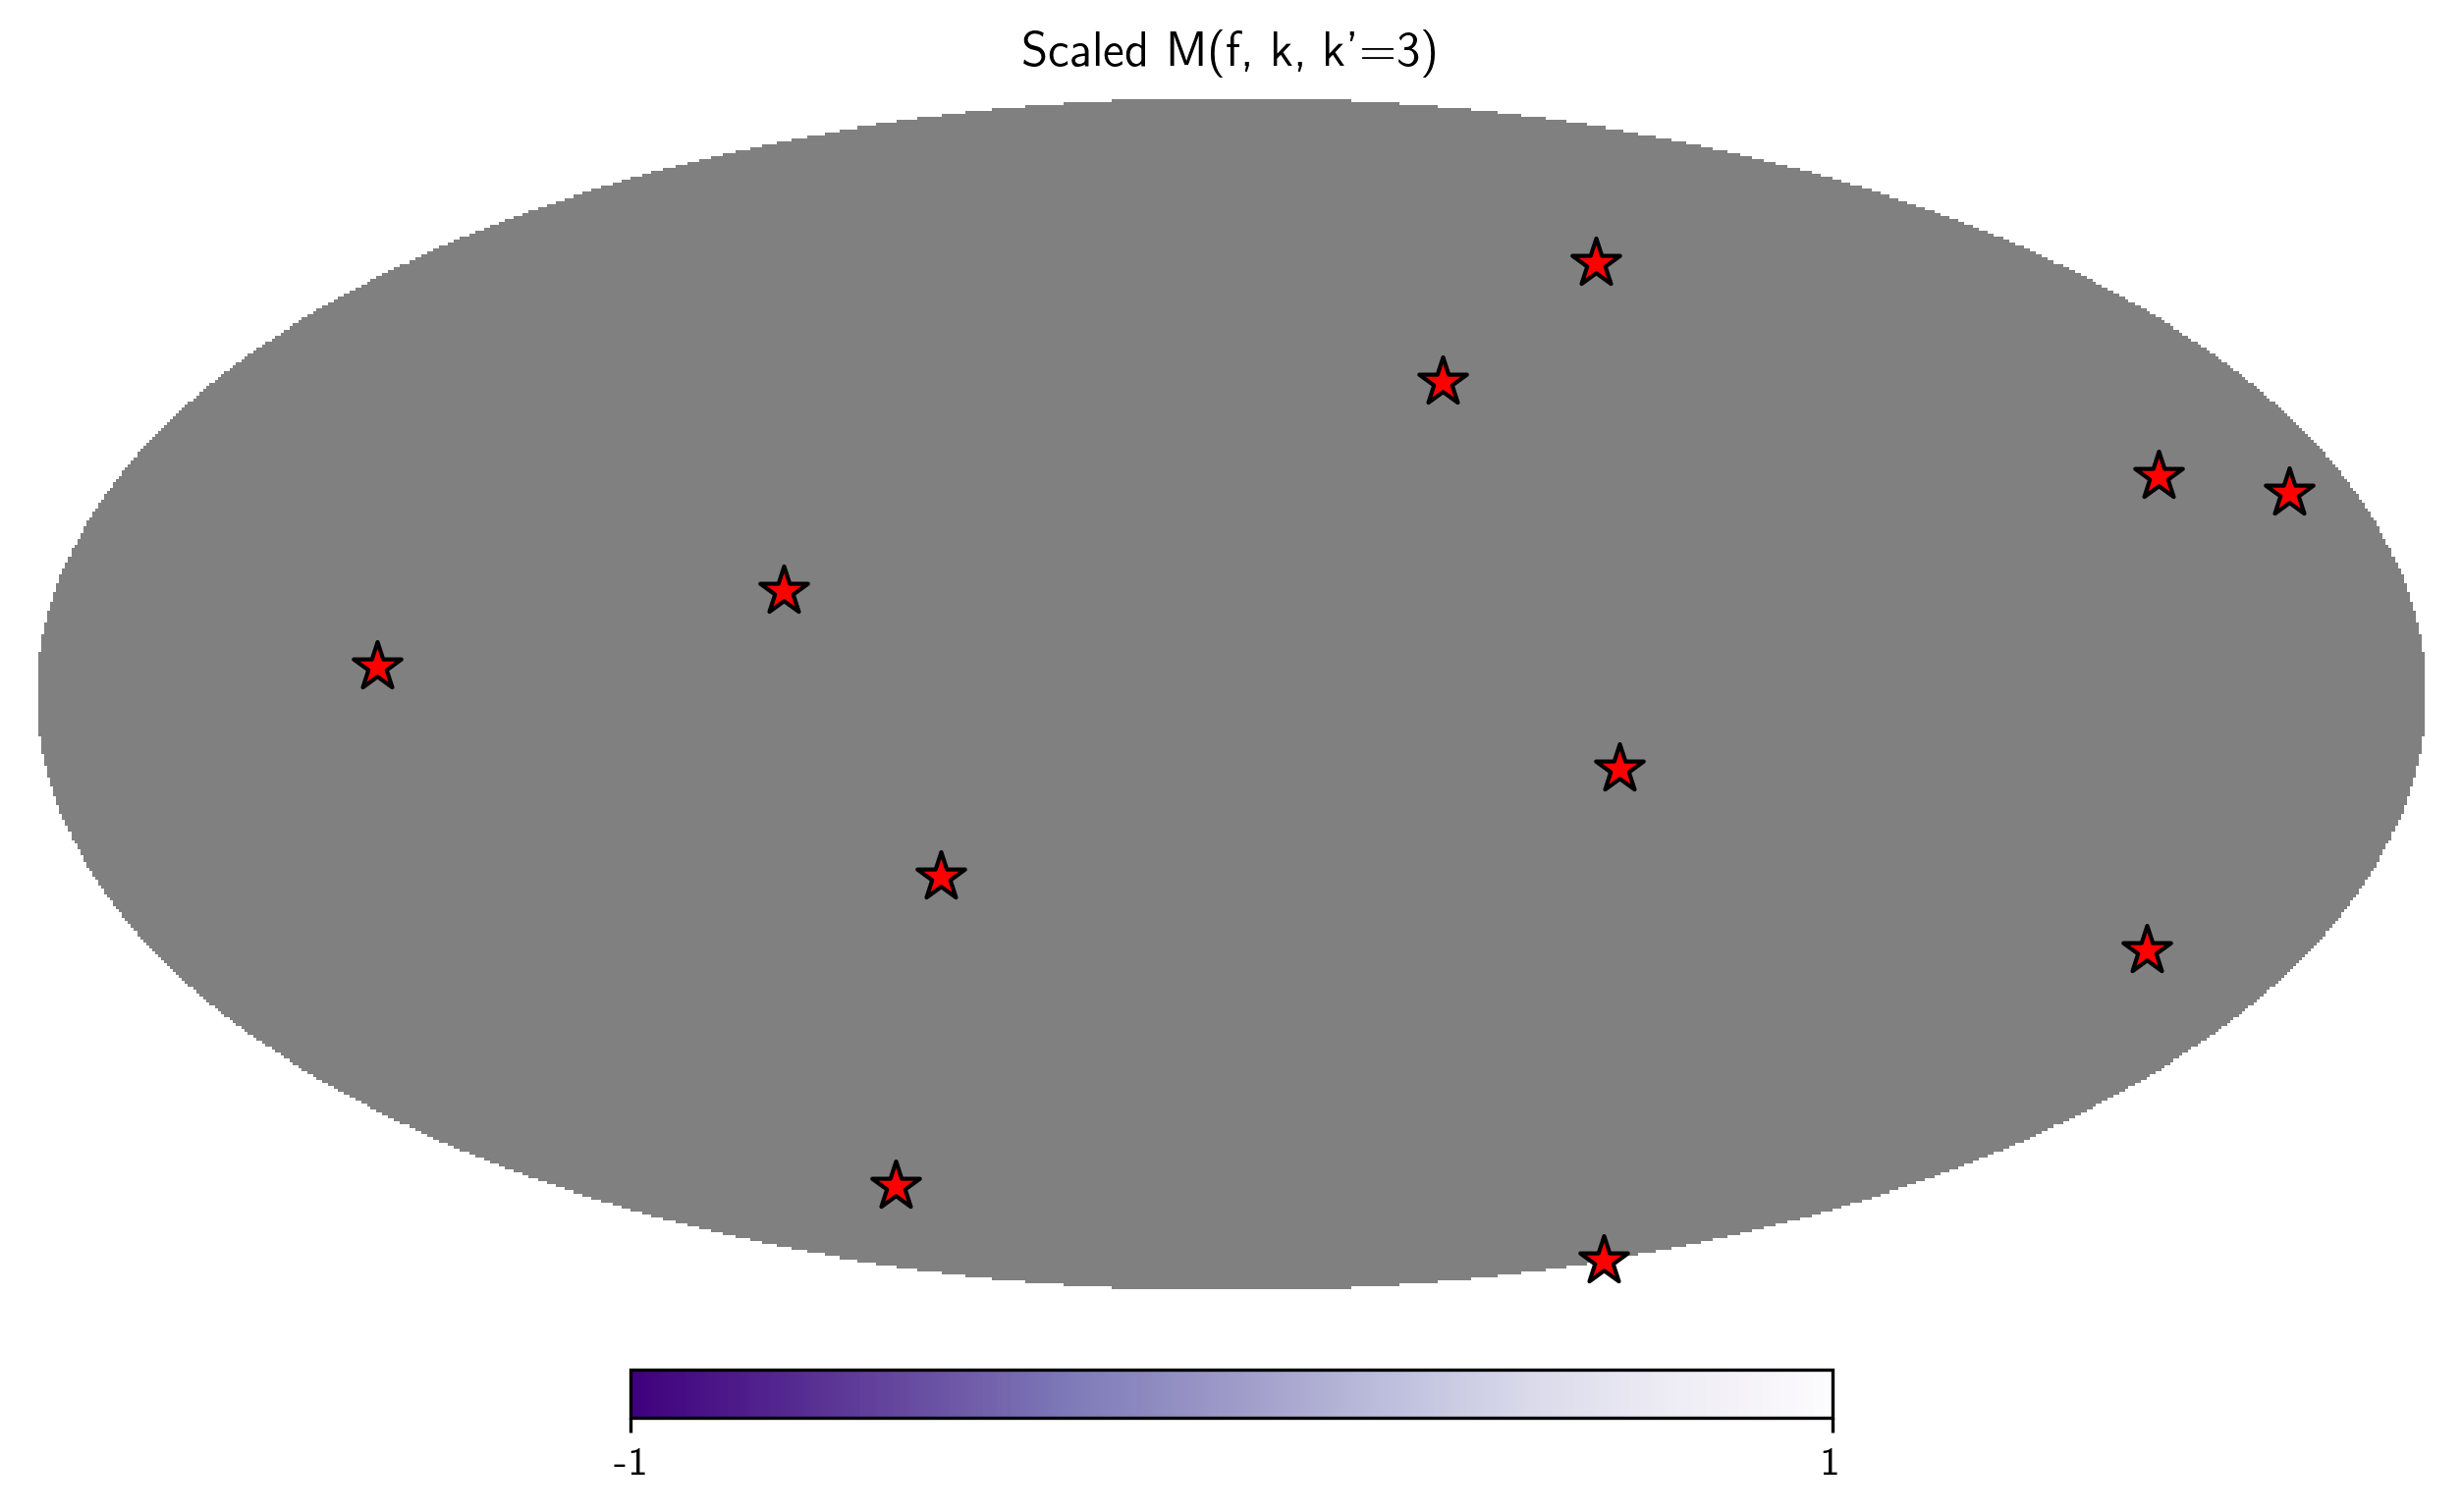

theta_b: [0.84106867 1.57079633 2.30052398 1.57079633], phi_b: [ 3.14159265  2.35619449  3.14159265 -2.35619449]


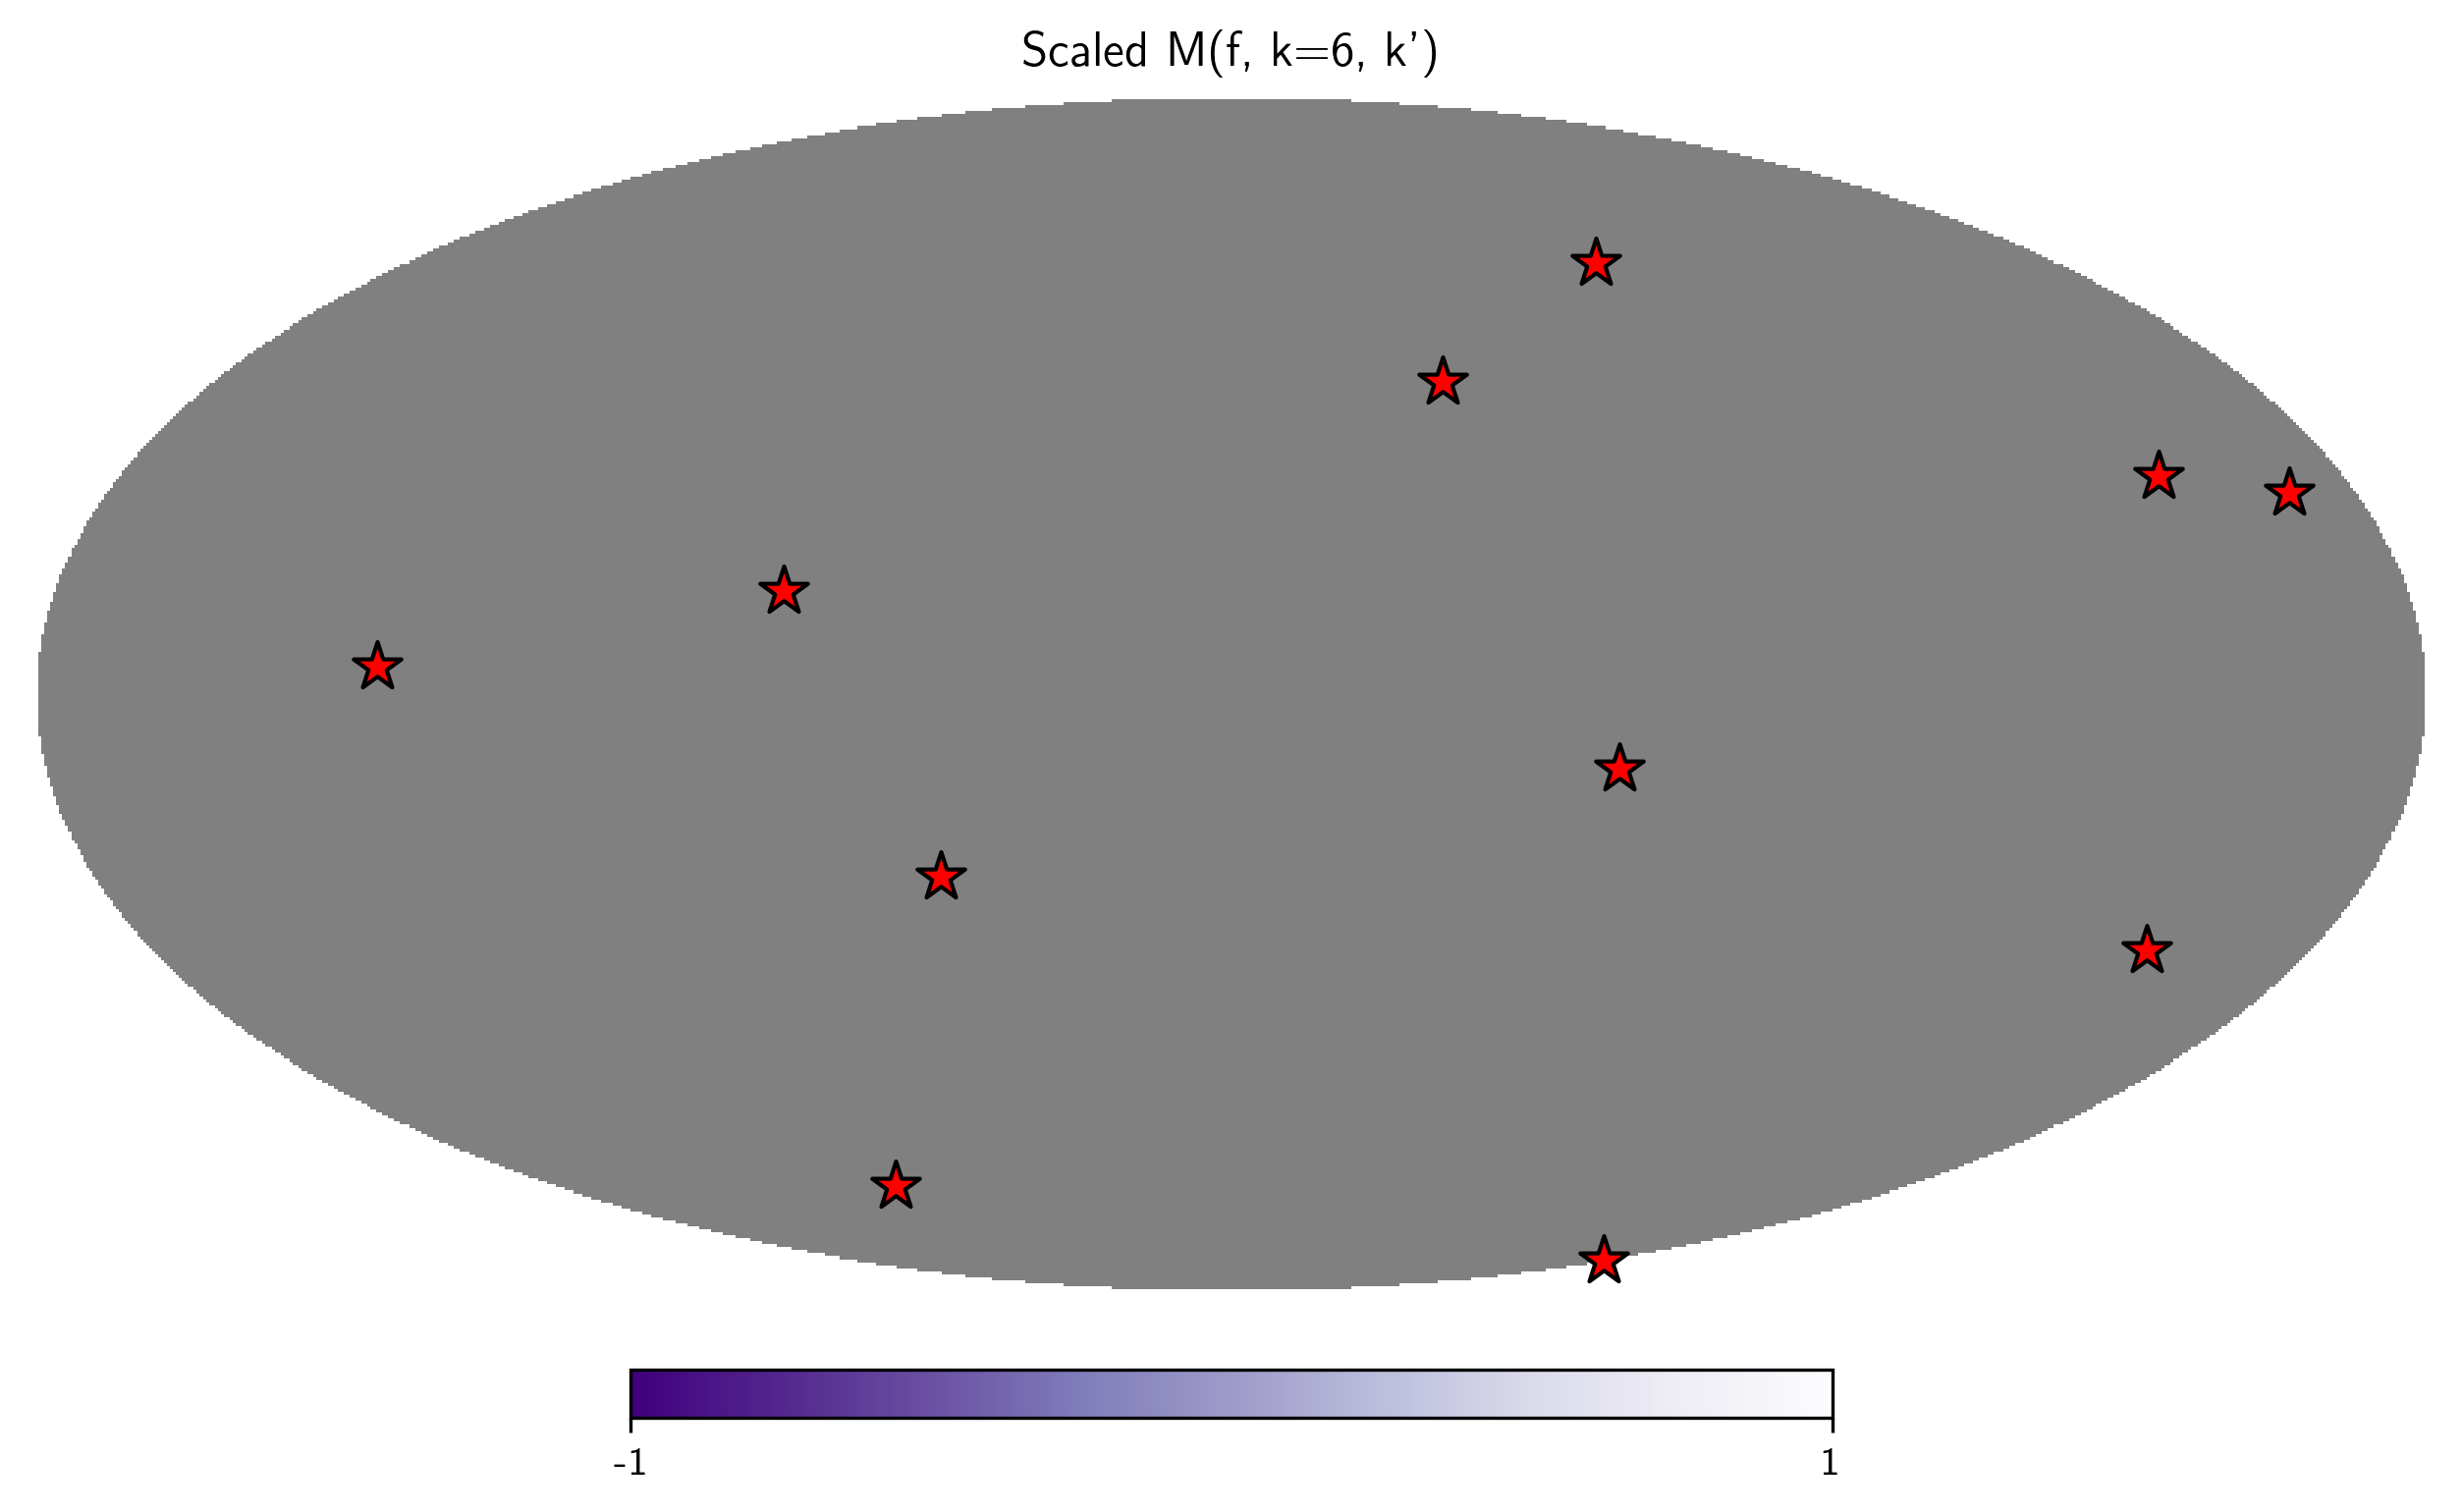

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

# --- Assume ASM is initialized like this ---
# ASM = haniso.Anisotropy(spectra, theta_gw, phi_gw, NPIX=NPIX)

NSIDE = 1
NPIX = hp.nside2npix(NSIDE)
IPIX = np.arange(NPIX)

Mkkp = ASM.M_kkp  # Shape: (N_freqs, N_pix, N_pix)

fi = min_index  # Frequency index
fixed_kp = 3    # Example fixed pixel index for k'
fixed_k = 6     # Example fixed pixel index for k

# For full pixel outlines
def draw_pixel_outline(ipix, color='red', lw=20):
    """Draws the full boundary of the HEALPix pixel."""
    verts = hp.boundaries(NSIDE, ipix, step=1)
    theta_b = np.arccos(verts[2])
    phi_b = np.arctan2(verts[1], verts[0])
    print(f"theta_b: {theta_b}, phi_b: {phi_b}")
    hp.visufunc.projplot(theta_b, phi_b, color=color, linewidth=lw, rot=(180, 0, 0))

# Plot M(f, k, k'=fixed_kp)
map_k = Mkkp[fi, :, fixed_kp]
hp.mollview(map_k, title=f"M(f, k, k'={fixed_kp})", cmap='Purples_r', rot=(180, 0, 0))

draw_pixel_outline(fixed_kp)  # Draw red outline for fixed_kp

# GW sources (if desired)
hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red',
                        edgecolors='black', s=150, rot=(180, 0, 0))

plt.show()

# Plot M(f, k=fixed_k, k')
map_kp = Mkkp[fi, fixed_k, :]
hp.mollview(map_kp, title=f"M(f, k={fixed_k}, k')", cmap='Purples_r', rot=(180, 0, 0))

draw_pixel_outline(fixed_k)  # Draw red outline for fixed_k

hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red',
                        edgecolors='black', s=150, rot=(180, 0, 0))

plt.show()


M_kk_scale = np.sqrt(Mkkp[fi, :, fixed_kp]) / Tspan
M_kkp_scale = np.sqrt(Mkkp[fi, fixed_k, :]) / Tspan

M_kk_norm = (M_kk_scale - np.min(M_kk_scale)) / (np.max(M_kk_scale) - np.min(M_kk_scale))
M_kkp_norm = (M_kkp_scale - np.min(M_kkp_scale)) / (np.max(M_kkp_scale) - np.min(M_kkp_scale))

# Scaled plot: fixed k'
hp.mollview(M_kk_norm, title=f"Scaled M(f, k, k'={fixed_kp})", cmap='Purples_r', rot=(180, 0, 0))

draw_pixel_outline(fixed_kp)

hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red',
                        edgecolors='black', s=150, rot=(180, 0, 0))

plt.show()

# Scaled plot: fixed k
hp.mollview(M_kkp_norm, title=f"Scaled M(f, k={fixed_k}, k')", cmap='Purples_r', rot=(180, 0, 0))

draw_pixel_outline(fixed_k)

hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red',
                        edgecolors='black', s=150, rot=(180, 0, 0))

plt.show()


/var/folders/0_/5g1f83z542548054df5gwwpr0000gq/T/ipykernel_35483/1072911018.py:22: RuntimeWarning: Mean of empty slice.
  M_binned = np.array([M_flat[bin_indices == i].mean() for i in range(1, len(bins_deg))])
/Users/oliverda/miniforge3/envs/hasasia_aniso/lib/python3.10/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


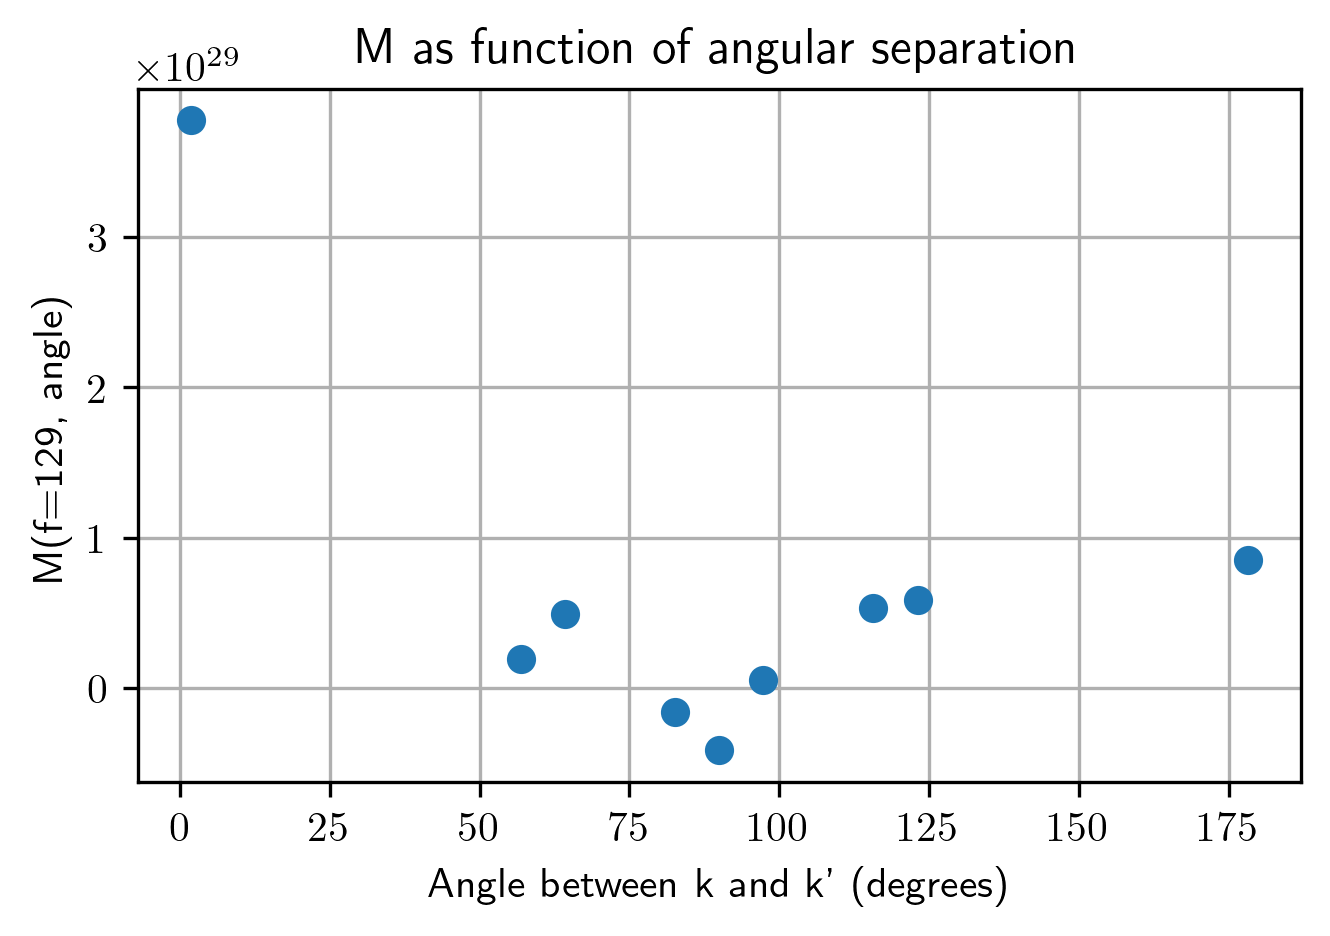

In [ ]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

fi = min_index  # frequency index
Npix = Mkkp.shape[1]
nside = hp.npix2nside(Npix)

vecs = np.array(hp.pix2vec(nside, np.arange(Npix)))

cos_angles = np.dot(vecs.T, vecs)
cos_angles = np.clip(cos_angles, -1, 1)
angles_rad = np.arccos(cos_angles)
angles_deg = np.degrees(angles_rad)

angles_flat = angles_deg.flatten()
M_flat = Mkkp[fi].flatten()

bins_deg = np.linspace(0, 180, 50)
bin_indices = np.digitize(angles_flat, bins_deg)

M_binned = np.array([M_flat[bin_indices == i].mean() for i in range(1, len(bins_deg))])
bin_centers_deg = 0.5 * (bins_deg[:-1] + bins_deg[1:])

plt.figure()
plt.plot(bin_centers_deg, M_binned, marker='o')
plt.xlabel('Angle between k and k\' (degrees)')
plt.ylabel(f'M(f={fi}, angle)')
plt.title('M as function of angular separation')
plt.grid()
plt.show()

/Users/oliverda/miniforge3/envs/hasasia_aniso/lib/python3.10/site-packages/healpy/pixelfunc.py:656: RuntimeWarning: divide by zero encountered in _vec2pix_ring
  return pixlib._vec2pix_ring(nside, x, y, z)
/Users/oliverda/miniforge3/envs/hasasia_aniso/lib/python3.10/site-packages/healpy/pixelfunc.py:656: RuntimeWarning: invalid value encountered in _vec2pix_ring
  return pixlib._vec2pix_ring(nside, x, y, z)


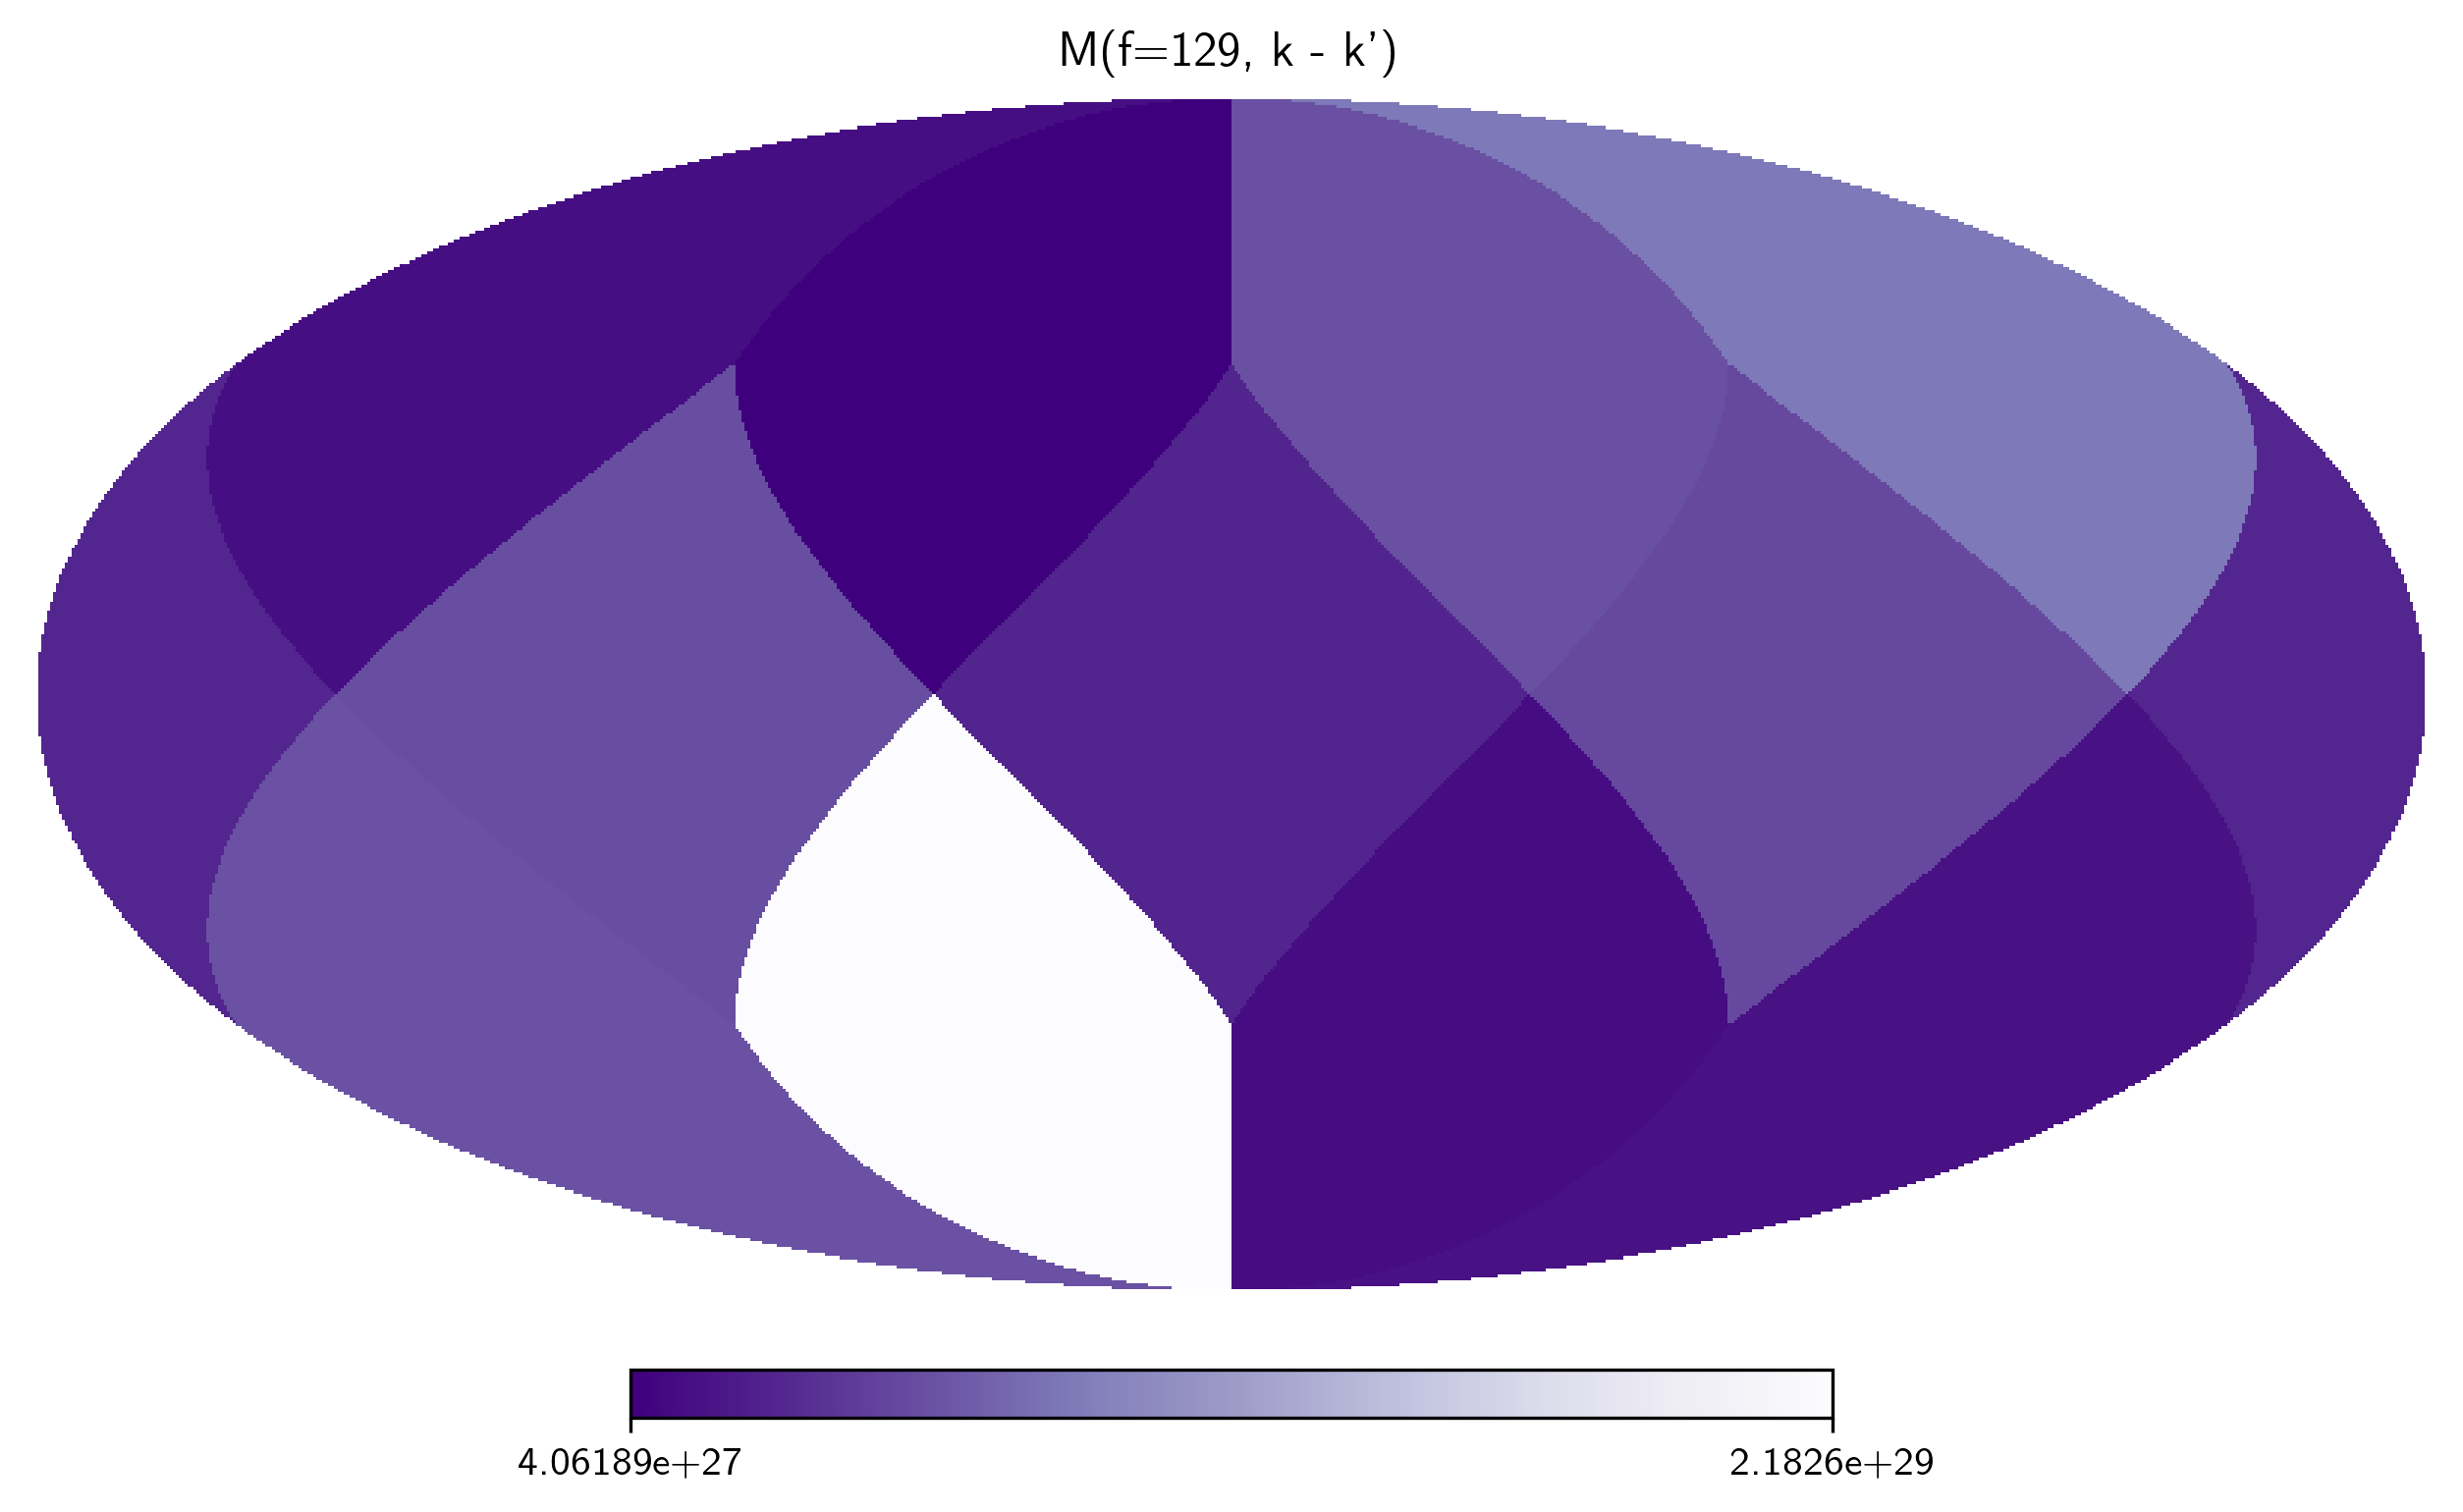

In [ ]:
import numpy as np
import healpy as hp

fi = min_index
Npix = Mkkp.shape[1]
nside = hp.npix2nside(Npix)

# Step 1: get directions for all pixels k and k'
vecs = np.array(hp.pix2vec(nside, np.arange(Npix)))  # shape (3, Npix)

# Step 2: compute difference vectors for all pairs (k, k')
# vecs[:, k] - vecs[:, k'] for all k,k'
# We'll create two big arrays for broadcasting
vecs_k = vecs[:, :, np.newaxis]     # shape (3, Npix, 1)
vecs_kp = vecs[:, np.newaxis, :]    # shape (3, 1, Npix)

diff_vecs = vecs_k - vecs_kp        # shape (3, Npix, Npix)

# Step 3: normalize difference vectors
norms = np.linalg.norm(diff_vecs, axis=0)  # shape (Npix, Npix)
# Avoid division by zero (when k == k')
norms[norms == 0] = 1
normed_diff_vecs = diff_vecs / norms      # shape (3, Npix, Npix)

# Step 4: get pixel indices for each difference vector
diff_pix = hp.vec2pix(nside, 
                      normed_diff_vecs[0].flatten(), 
                      normed_diff_vecs[1].flatten(), 
                      normed_diff_vecs[2].flatten())

# Step 5: accumulate M values into difference pixels
M_flat = Mkkp[fi].flatten()

# Create arrays for sum and counts per pixel on sphere of difference directions
map_diff_sum = np.zeros(hp.nside2npix(nside))
map_diff_counts = np.zeros_like(map_diff_sum)

# Accumulate sums and counts
np.add.at(map_diff_sum, diff_pix, M_flat)
np.add.at(map_diff_counts, diff_pix, 1)

# Avoid division by zero
map_diff_counts[map_diff_counts == 0] = 1

# Step 6: average map
map_diff_avg = map_diff_sum / map_diff_counts

# Now plot
import matplotlib.pyplot as plt
hp.mollview(map_diff_avg, title=f"M(f={fi}, k - k')", cmap='Purples_r')
plt.show()


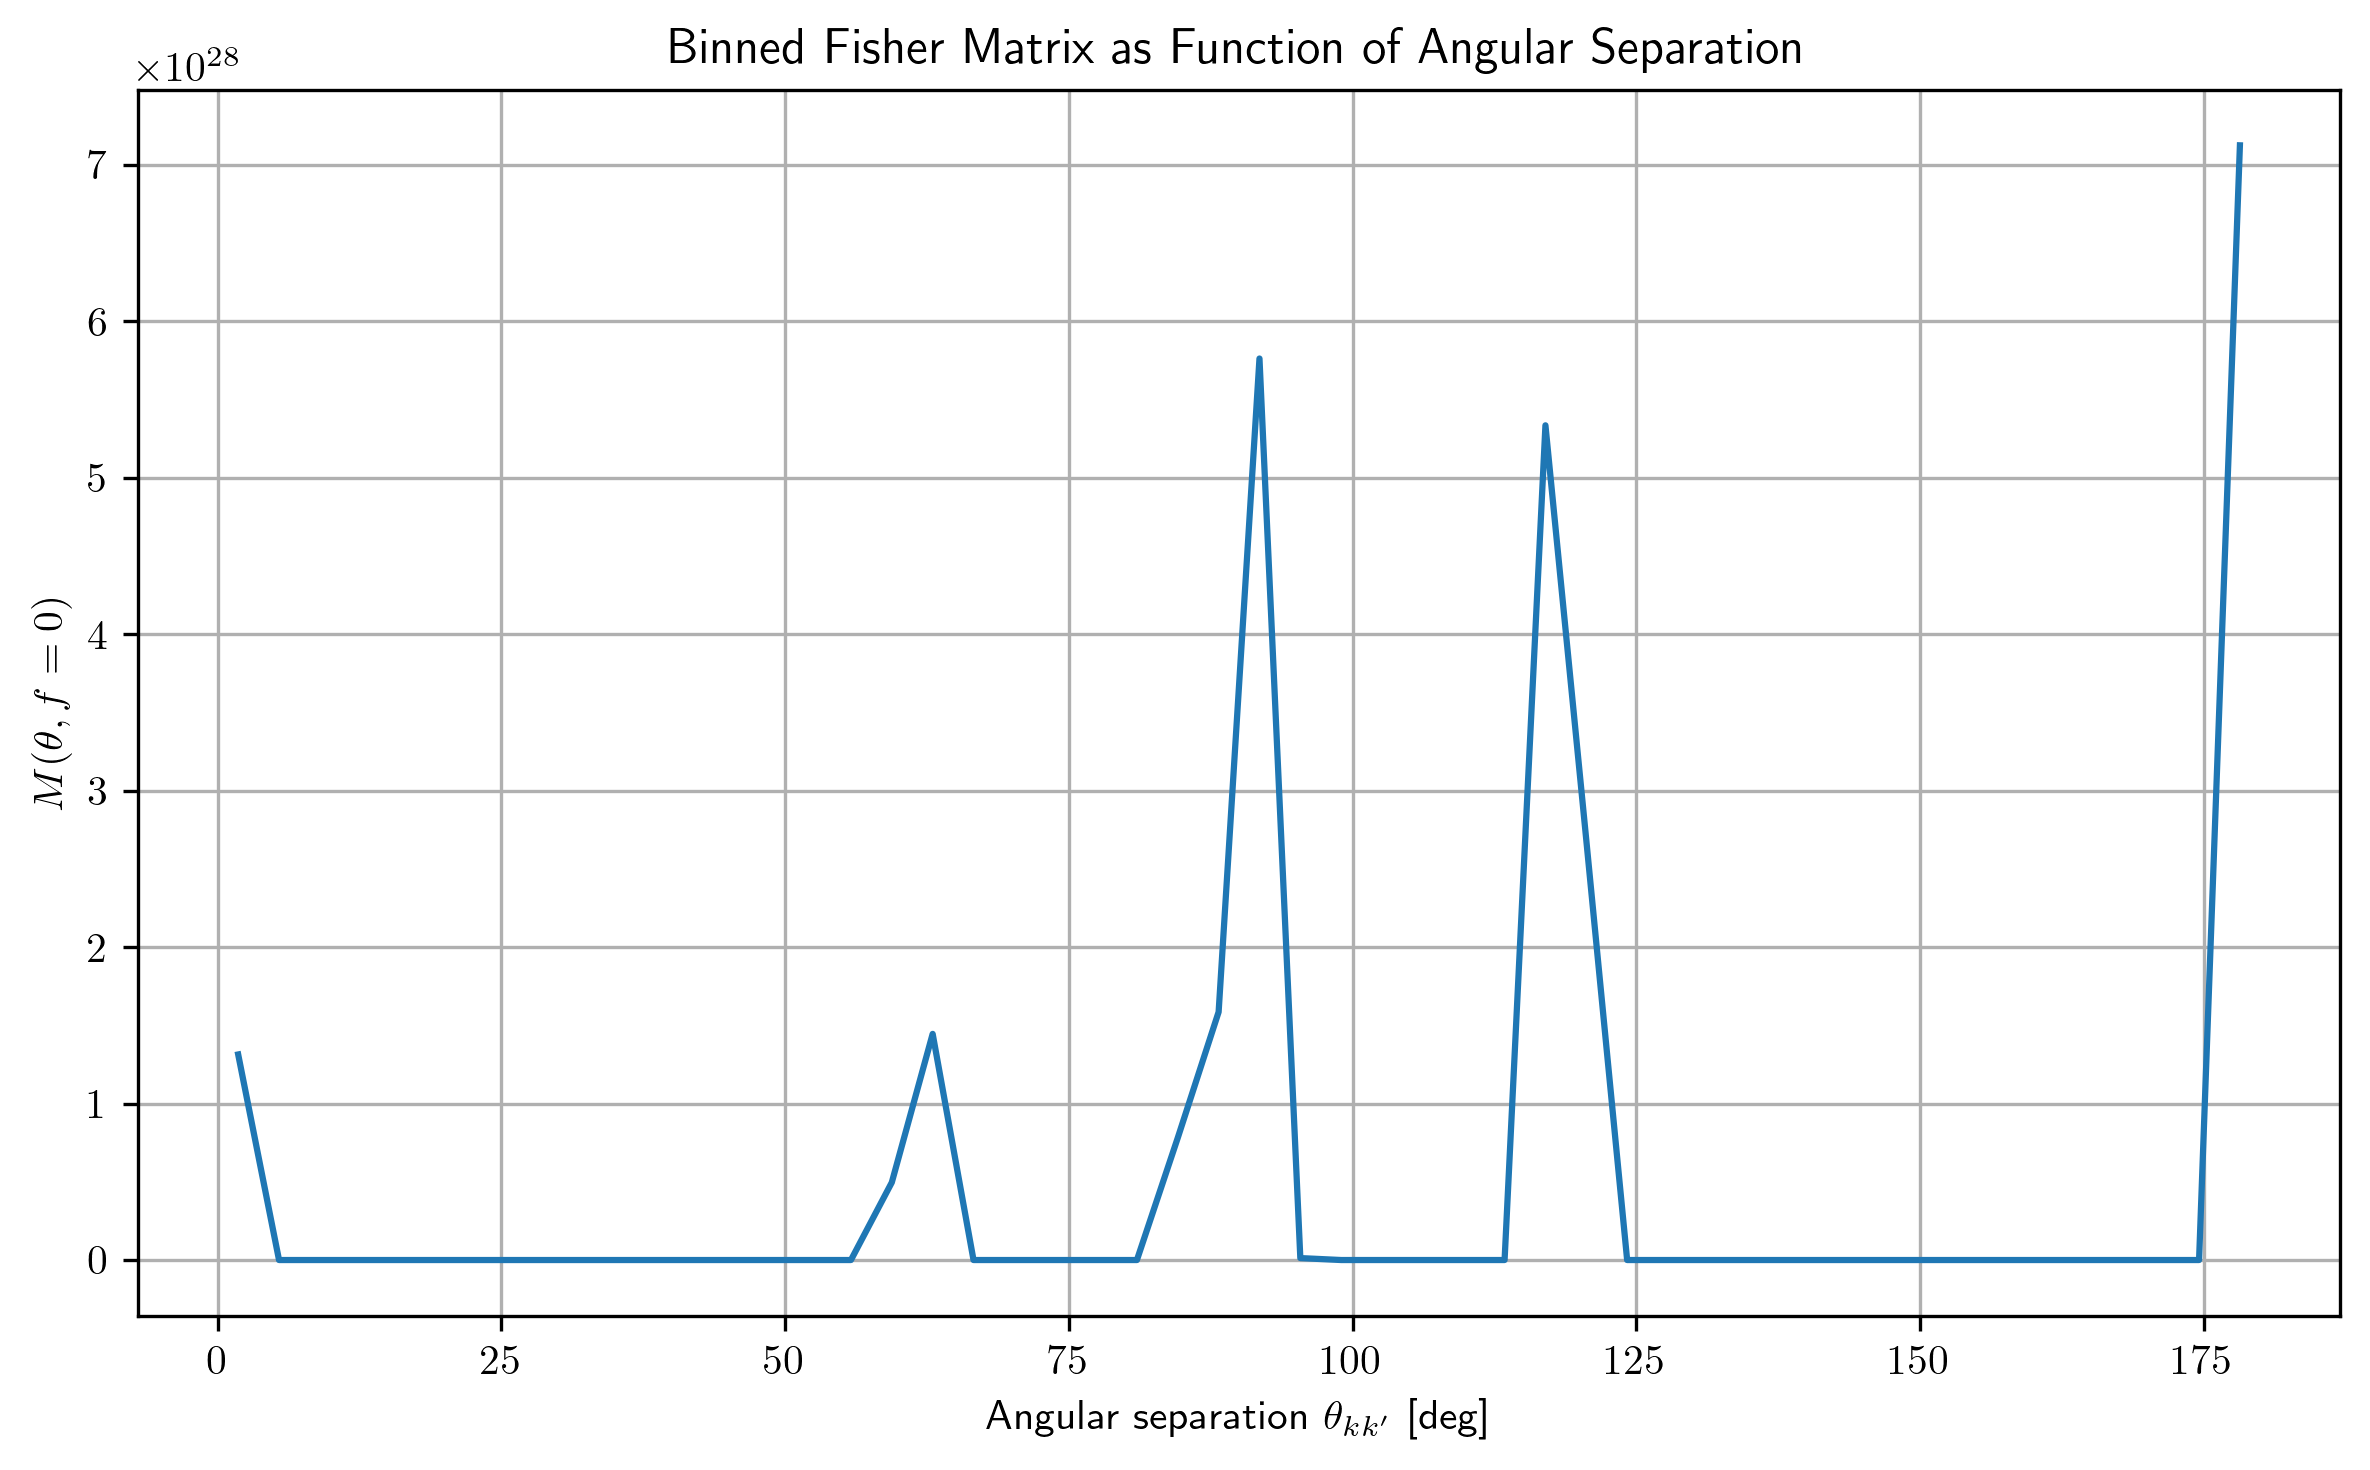

In [ ]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

# Step 1: Compute all dot products between pixel vectors
N_pix = ASM.K.shape[1]
Kdot = np.dot(ASM.K.T, ASM.K)  # Shape: (N_pix, N_pix)

# Clip to avoid numerical errors in arccos
Kdot = np.clip(Kdot, -1.0, 1.0)
theta_sep = np.arccos(Kdot)  # Shape: (N_pix, N_pix)

# Step 2: Define angular bins
nbins = 50
theta_edges = np.linspace(0, np.pi, nbins + 1)
theta_centers = 0.5 * (theta_edges[:-1] + theta_edges[1:])

# Step 3: Flatten and bin
theta_flat = theta_sep.flatten()
M_flat = ASM.M_kkp.reshape(N_pix * N_pix, -1)  # Shape: (N_pix^2, F)

# Bin indices for each pixel pair
bin_indices = np.digitize(theta_flat, theta_edges) - 1
valid = (bin_indices >= 0) & (bin_indices < nbins)

# Initialize binned result
M_binned = np.zeros((nbins, M_flat.shape[1]))
counts = np.zeros(nbins)

# Step 4: Bin the data
for b in range(nbins):
    mask = (bin_indices == b) & valid
    if np.any(mask):
        M_binned[b] = np.mean(M_flat[mask], axis=0)
        counts[b] = np.sum(mask)

# Step 5: Plot
f_idx = 0  # Choose frequency index to visualize
plt.figure(figsize=(8, 5))
plt.plot(np.degrees(theta_centers), M_binned[:, f_idx])
plt.xlabel(r'Angular separation $\theta_{kk^\prime}$ [deg]')
plt.ylabel(f'$M(\\theta, f={f_idx})$')
plt.title('Binned Fisher Matrix as Function of Angular Separation')
plt.grid(True)
plt.tight_layout()
plt.show()


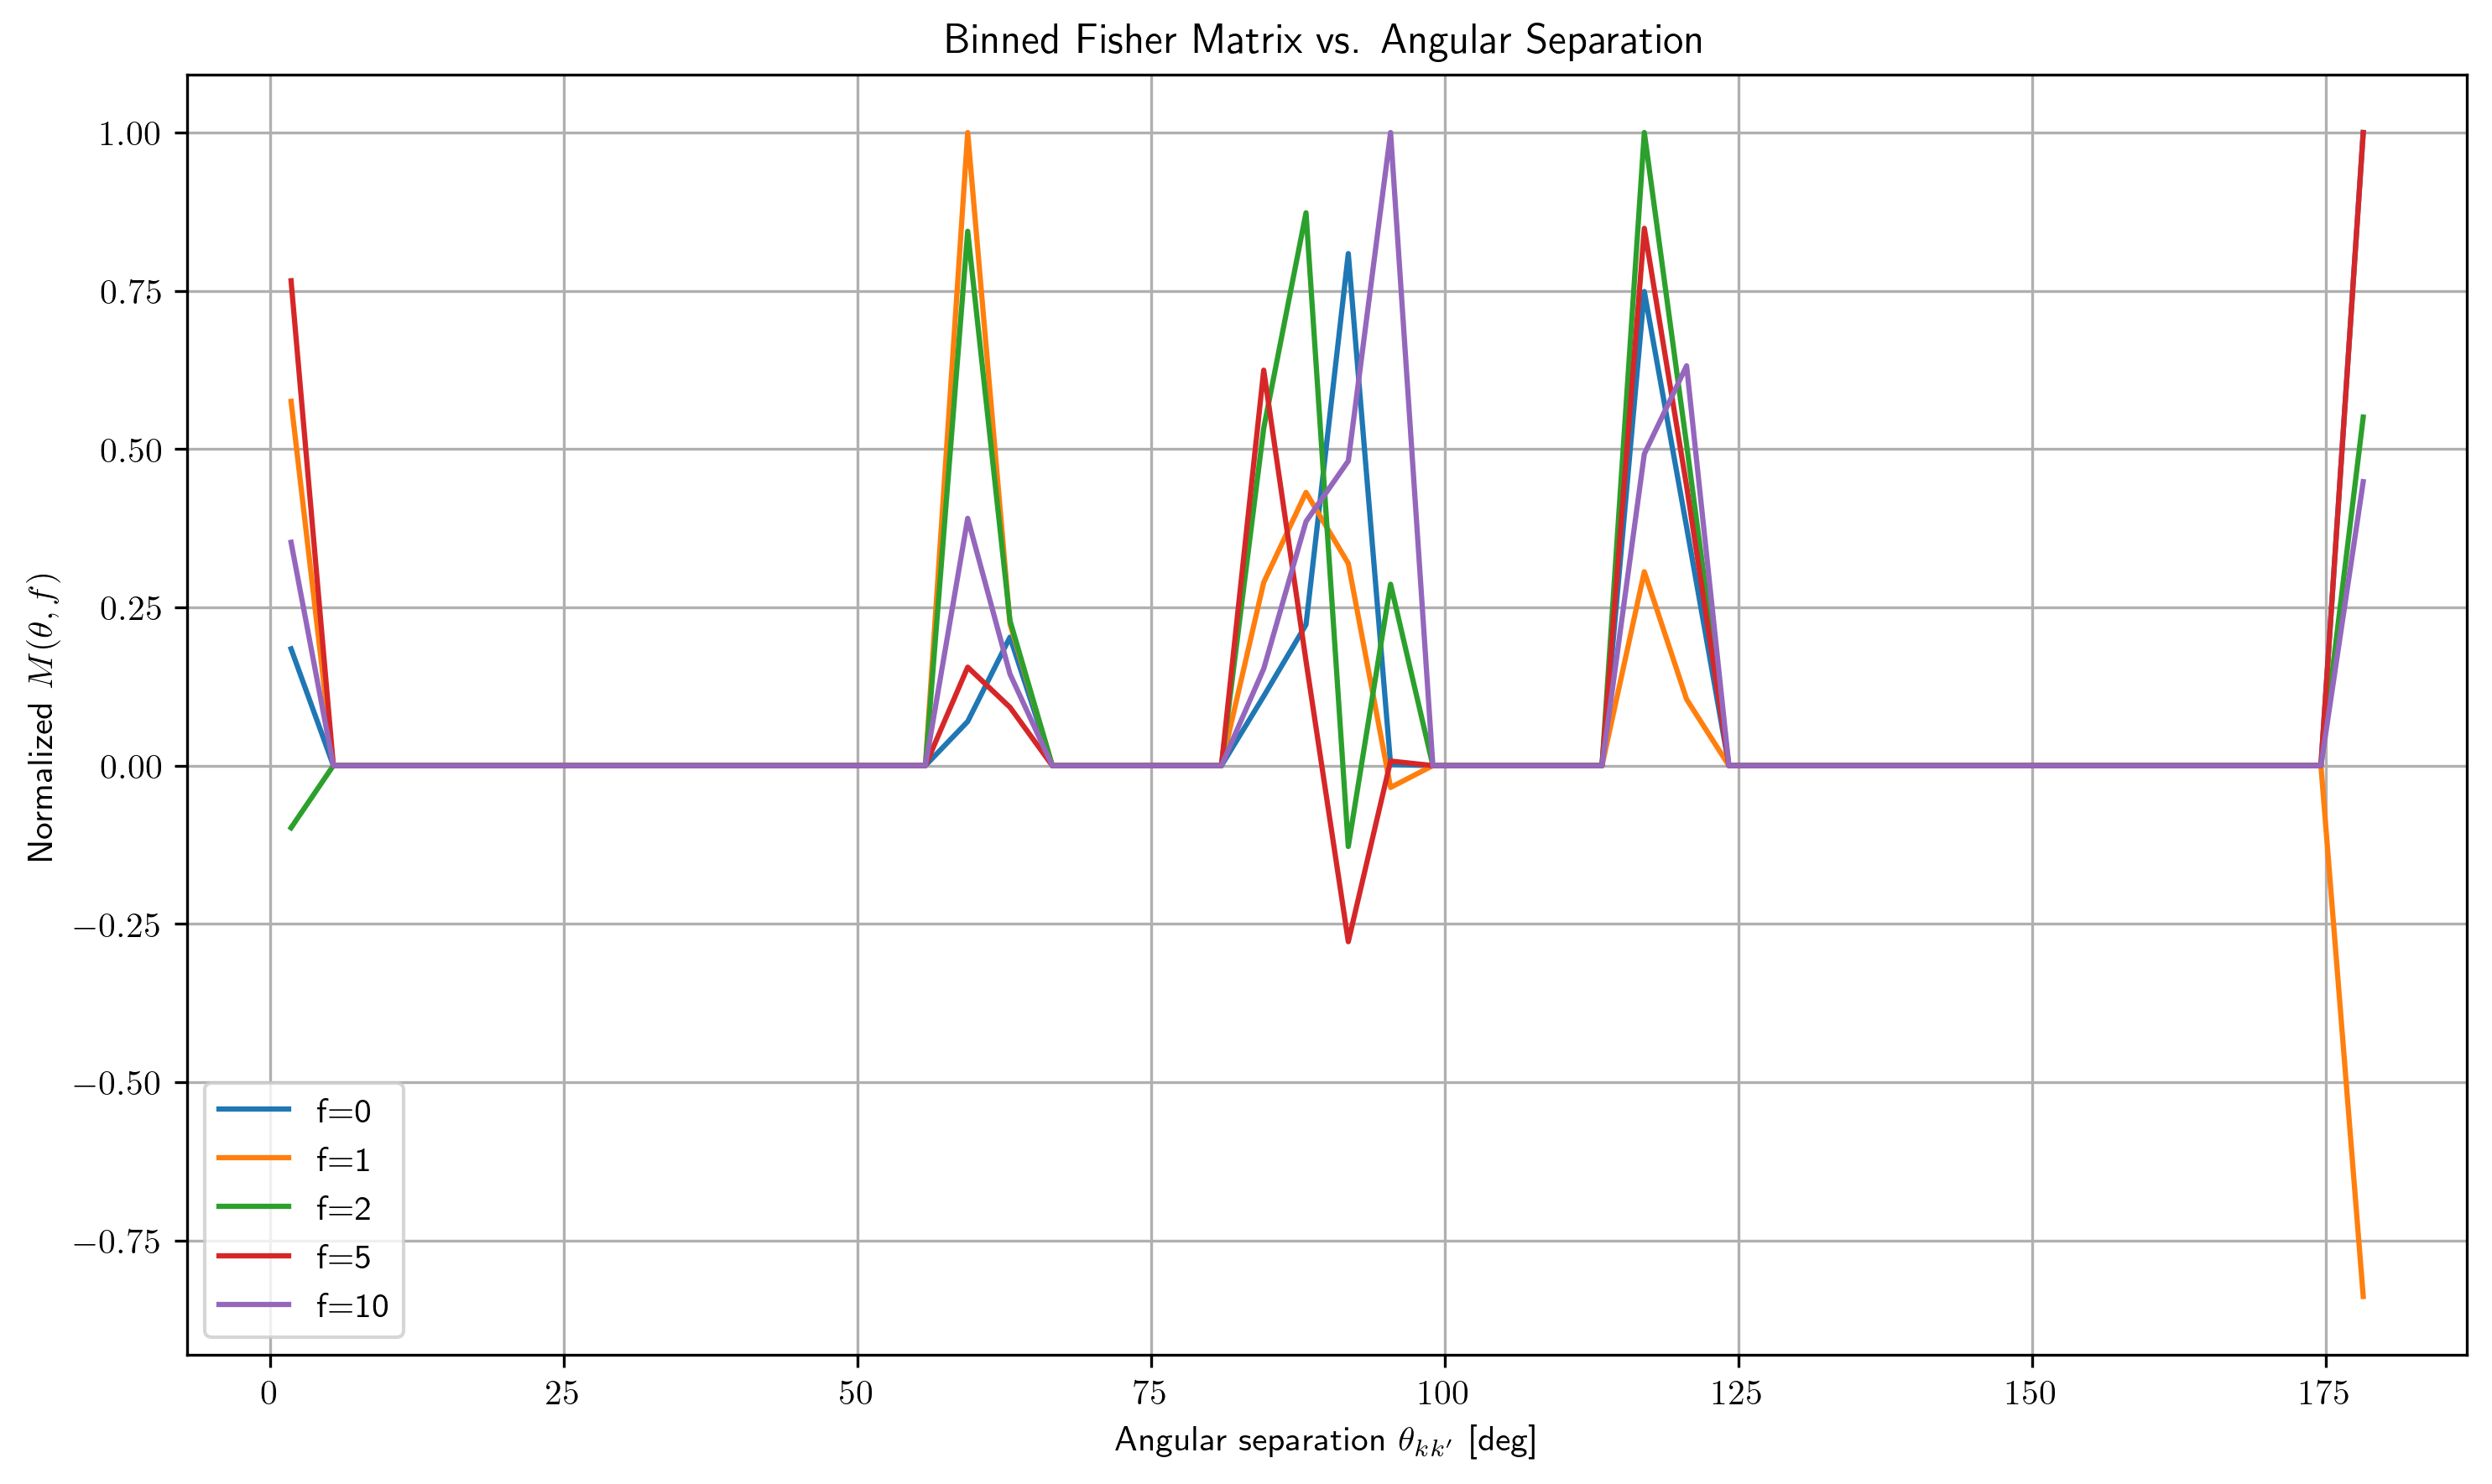

In [ ]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

N_pix = ASM.K.shape[1]
Kdot = np.dot(ASM.K.T, ASM.K)  # Shape: (N_pix, N_pix)
Kdot = np.clip(Kdot, -1.0, 1.0)
theta_sep = np.arccos(Kdot)

# Angular bins
nbins = 50
theta_edges = np.linspace(0, np.pi, nbins + 1)
theta_centers = 0.5 * (theta_edges[:-1] + theta_edges[1:])
bin_indices = np.digitize(theta_sep.flatten(), theta_edges) - 1

# Flatten M_kkp
M_flat = ASM.M_kkp.reshape(N_pix**2, -1)
valid = (bin_indices >= 0) & (bin_indices < nbins)

# Choose multiple frequency indices to compare
f_indices = [0, 1, 2, 5, 10]  # or range(ASM.M_kkp.shape[-1])[:N]
M_binned_all = {}

plt.figure(figsize=(10, 6))
for f_idx in f_indices:
    M_binned = np.zeros(nbins)
    counts = np.zeros(nbins)
    for b in range(nbins):
        mask = (bin_indices == b) & valid
        if np.any(mask):
            M_binned[b] = np.mean(M_flat[mask, f_idx])
            counts[b] = np.sum(mask)
    M_binned /= np.max(M_binned)  # normalize
    M_binned_all[f_idx] = M_binned
    plt.plot(np.degrees(theta_centers), M_binned, label=f"f={f_idx}")

plt.xlabel(r'Angular separation $\theta_{kk^\prime}$ [deg]')
plt.ylabel(r'Normalized $M(\theta, f)$')
plt.title('Binned Fisher Matrix vs. Angular Separation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Test with NG 15yr pulsars

In [ ]:
spectra_15yr = []
file_count = 0
max_files = 5  # Number of files to load

for filename in os.listdir(datadir):
    if filename.endswith('.has'):
        file_path = os.path.join(datadir, filename)
        with open(file_path, 'rb') as file:
            # print(f"Loading file: {filename}")
            spec_15yr = pickle.load(file)
            spectra_15yr.append(spec_15yr)
            # print(f"PSR: {spec_15yr.name}")
            file_count += 1    
            # Clear the loaded file from memory
            del spec_15yr   
            if file_count >= max_files:
                break  # Stop after loading the specified number of files

In [ ]:
spectra_15yr[0].__dir__()

['_H_0',
 'toas',
 'toaerrs',
 'phi',
 'theta',
 'N',
 'G',
 'designmatrix',
 'pdist',
 'tm_fit',
 'Tf_kwargs',
 'freqs',
 '_psd_prefit',
 'name',
 '_NcalInv',
 '_P_n',
 '__module__',
 '__doc__',
 '__init__',
 'psd_postfit',
 'psd_prefit',
 'Tf',
 'NcalInv',
 'P_n',
 'S_I',
 'S_R',
 'h_c',
 'Omega_gw',
 'add_white_noise_power',
 'add_red_noise_power',
 'add_noise_power',
 'spec_h5',
 '__dict__',
 '__weakref__',
 '__new__',
 '__repr__',
 '__hash__',
 '__str__',
 '__getattribute__',
 '__setattr__',
 '__delattr__',
 '__lt__',
 '__le__',
 '__eq__',
 '__ne__',
 '__gt__',
 '__ge__',
 '__reduce_ex__',
 '__reduce__',
 '__subclasshook__',
 '__init_subclass__',
 '__format__',
 '__sizeof__',
 '__dir__',
 '__class__']

In [ ]:
max_time = max(
    (np.max(spectra.toas) - np.min(spectra.toas)) / (24 * 3600 * 365.25)
    for spectra in spectra_15yr
)
print(max_time)
max_time_secs = max(
    (np.max(spectra.toas) - np.min(spectra.toas))
    for spectra in spectra_15yr
)
print(max_time_secs)
print(1/max_time_secs)
print(spectra_15yr[0].freqs[0])

Tspan = max_time_secs

8.963756103507466
282874629.6120472
3.5351349867305724e-09
2.0000000000000003e-10


In [ ]:
#Use the healpy functions to get the sky coordinates
NSIDE = 1
NPIX = hp.nside2npix(NSIDE)
IPIX = np.arange(NPIX)
theta_gw, phi_gw = hp.pix2ang(nside=NSIDE,ipix=IPIX)

In [ ]:
ASM=haniso.Anisotropy(spectra_15yr,theta_gw, phi_gw, NPIX=NPIX)

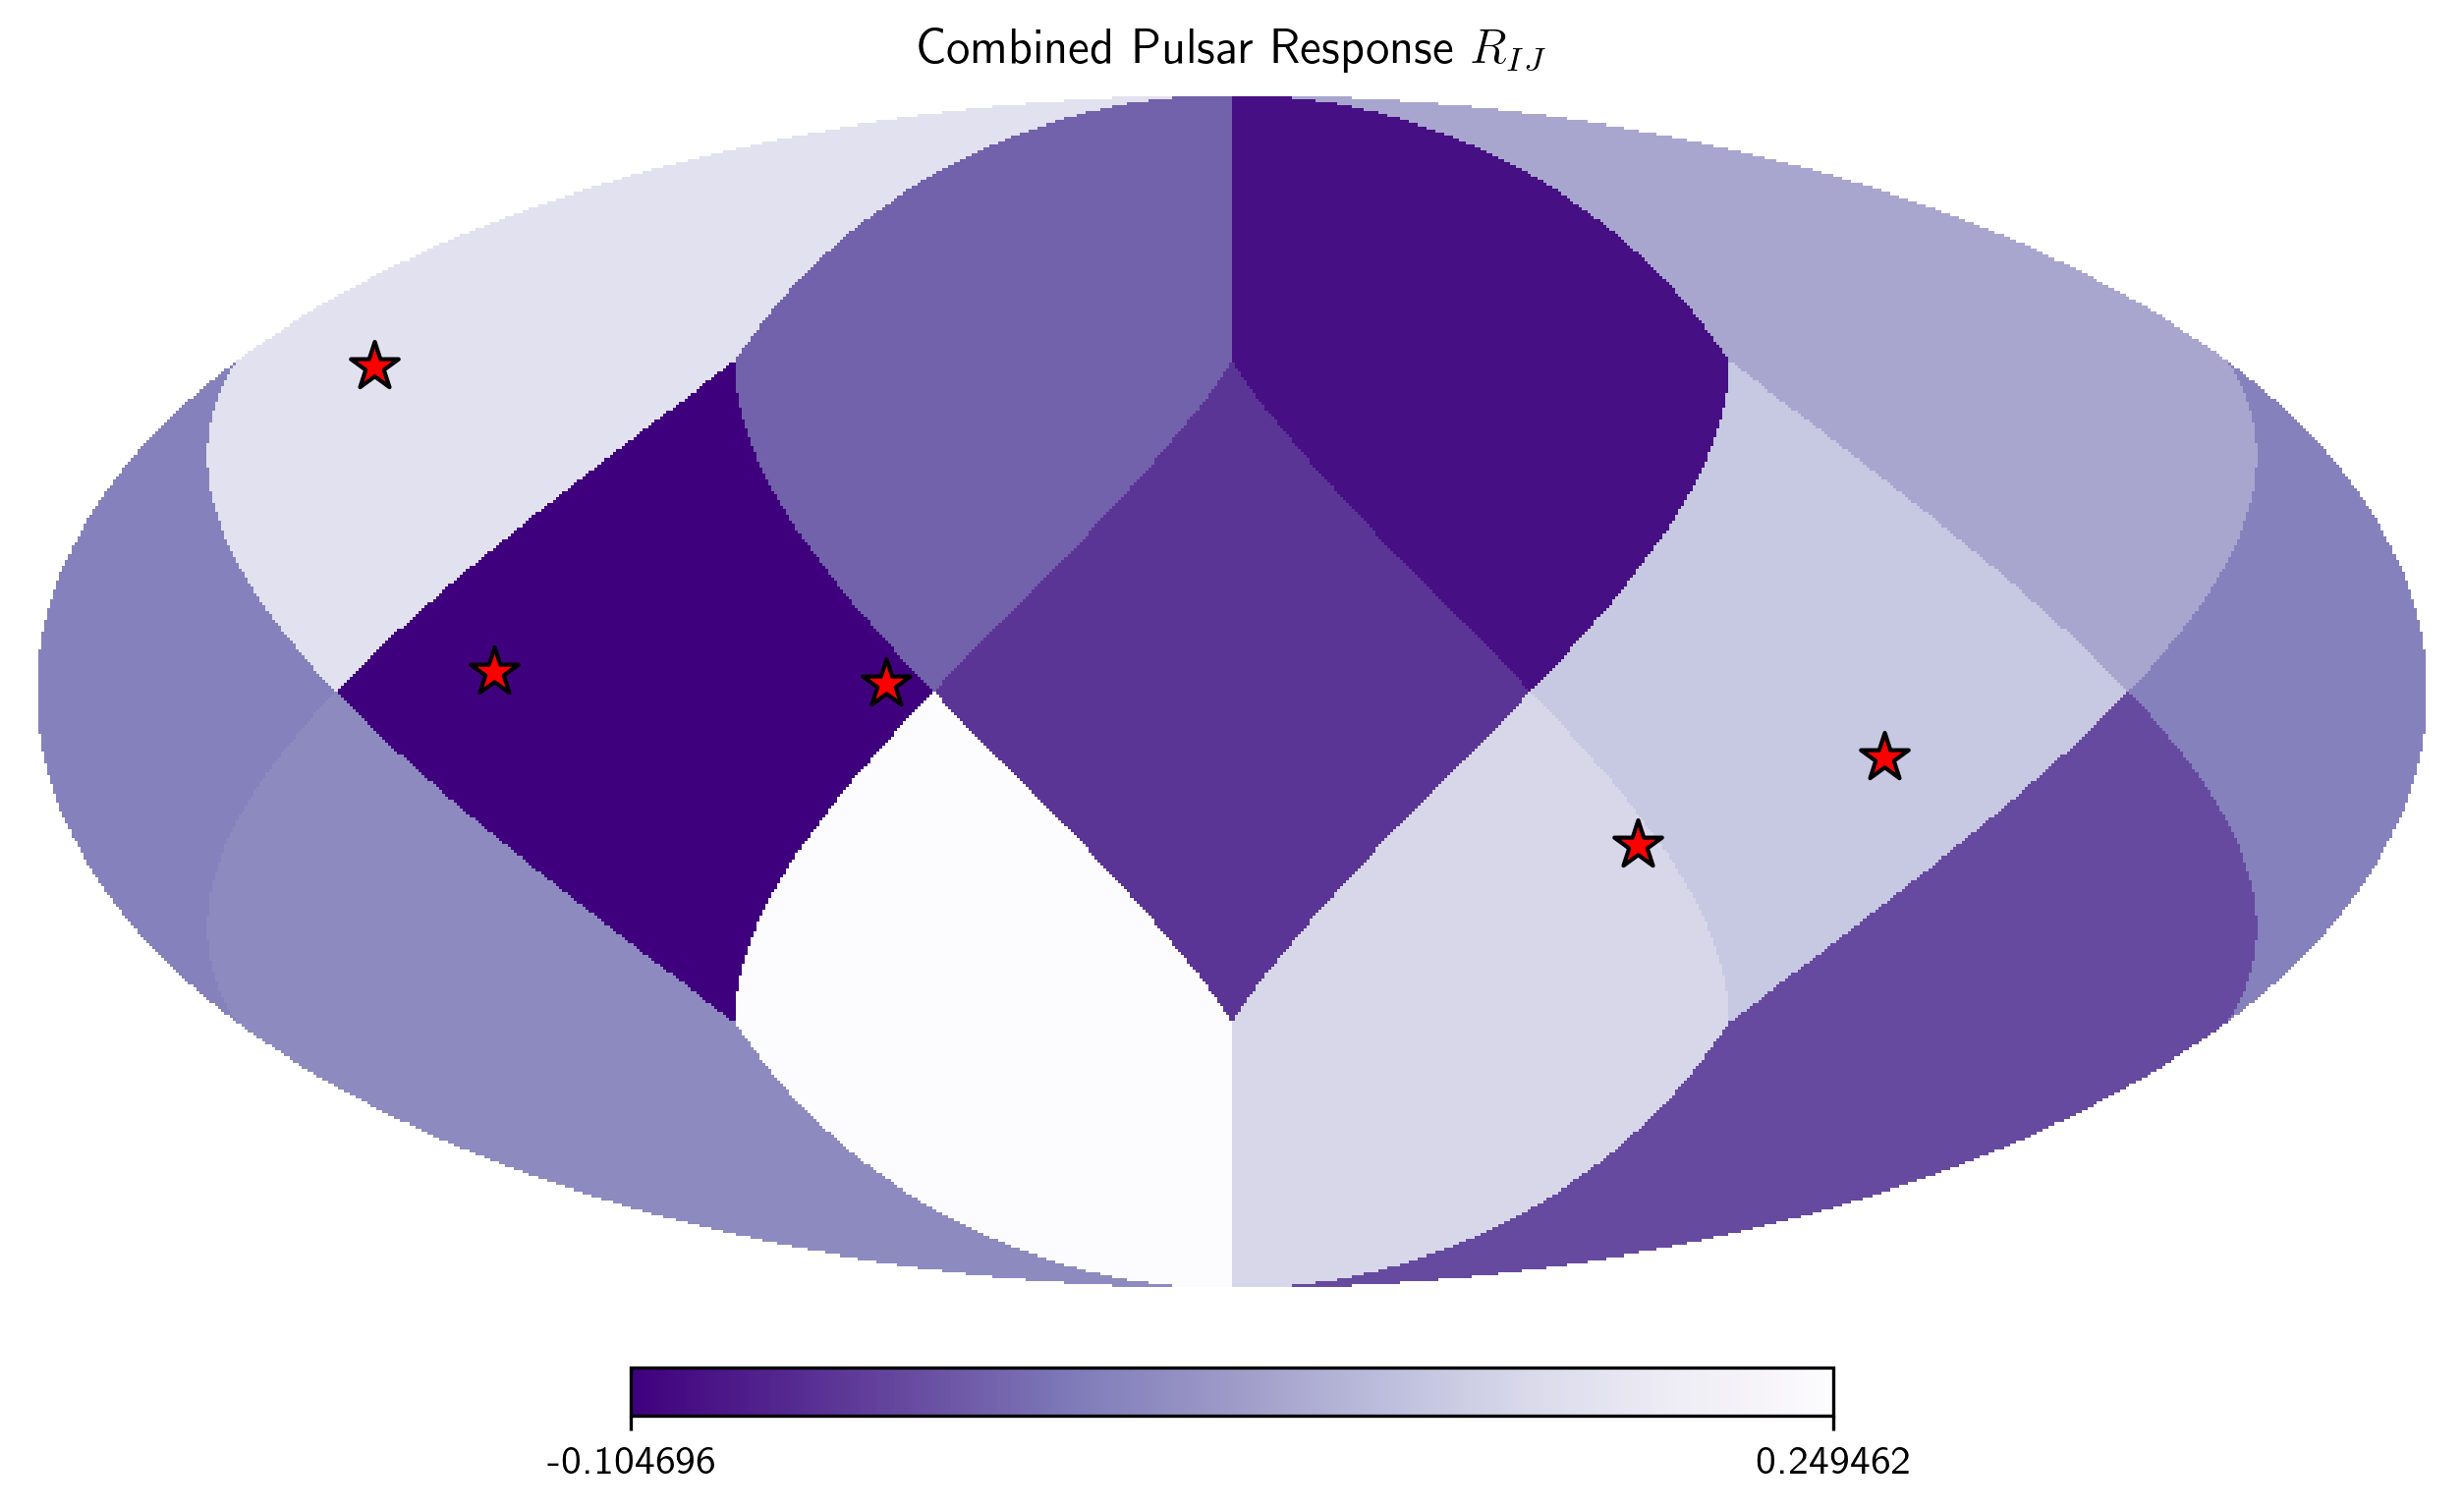

In [ ]:
# Summing all pair responses
combined_response = ASM.R_IJ.sum(axis=0)

# Plot the combined response
hp.mollview(combined_response, title="Combined Pulsar Response $R_{IJ}$", cmap='Purples_r', rot=(180,0,0))

# Highlight all pulsar positions


hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
                            edgecolors='black', s=150, rot=(180,0,0))
# plt.savefig(savedir+'combined.png')
plt.show()


In [ ]:
max_value = np.max(ASM.h_c_aniso)
max_index = np.argmax(ASM.h_c_aniso)
max_freq = spectra_15yr[0].freqs[max_index]  # Corresponding frequency
print(f"Max value: {max_value}, Index: {max_index}, Frequency: {max_freq}")

min_value = np.min(ASM.h_c_aniso)
min_index = np.argmin(ASM.h_c_aniso)
min_freq = spectra_15yr[0].freqs[min_index]  # Corresponding frequency
print(f"Min value: {min_value}, Index: {min_index}, Frequency: {min_freq}")

median_value = np.median(ASM.h_c_aniso)
median_index = (np.abs(ASM.h_c_aniso - median_value)).argmin()
median_freq = spectra_15yr[0].freqs[median_index]  # Corresponding frequency
print(f"Median value: {median_value}, Index: {median_index}, Frequency: {median_freq}")

ValueError: operands could not be broadcast together with shapes (300,12) (10,) 

In [ ]:
final_freqs = [max_freq, min_freq, median_freq]
final_freqs_idx = [max_index, min_index, median_index]

for freq, idx in zip(final_freqs, final_freqs_idx):
    # Compute the map at this frequency
    h_c_pixel = ASM.h_c_aniso_pixel(idx)
    h_c_pixel_norm = (h_c_pixel - np.min(h_c_pixel)) / (np.max(h_c_pixel) - np.min(h_c_pixel))
    
    # Plot the map
    hp.mollview(h_c_pixel_norm, title=f"f = {freq * 1e9:.2f} nHz", cmap='Purples_r', rot=(180,0,0))

    # Overlay pulsar positions
    hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
                            edgecolors='black', linewidths=0.25, s=150, alpha=1, rot=(180,0,0))
    
    plt.show()


IndexError: index 158 is out of bounds for axis 1 with size 12

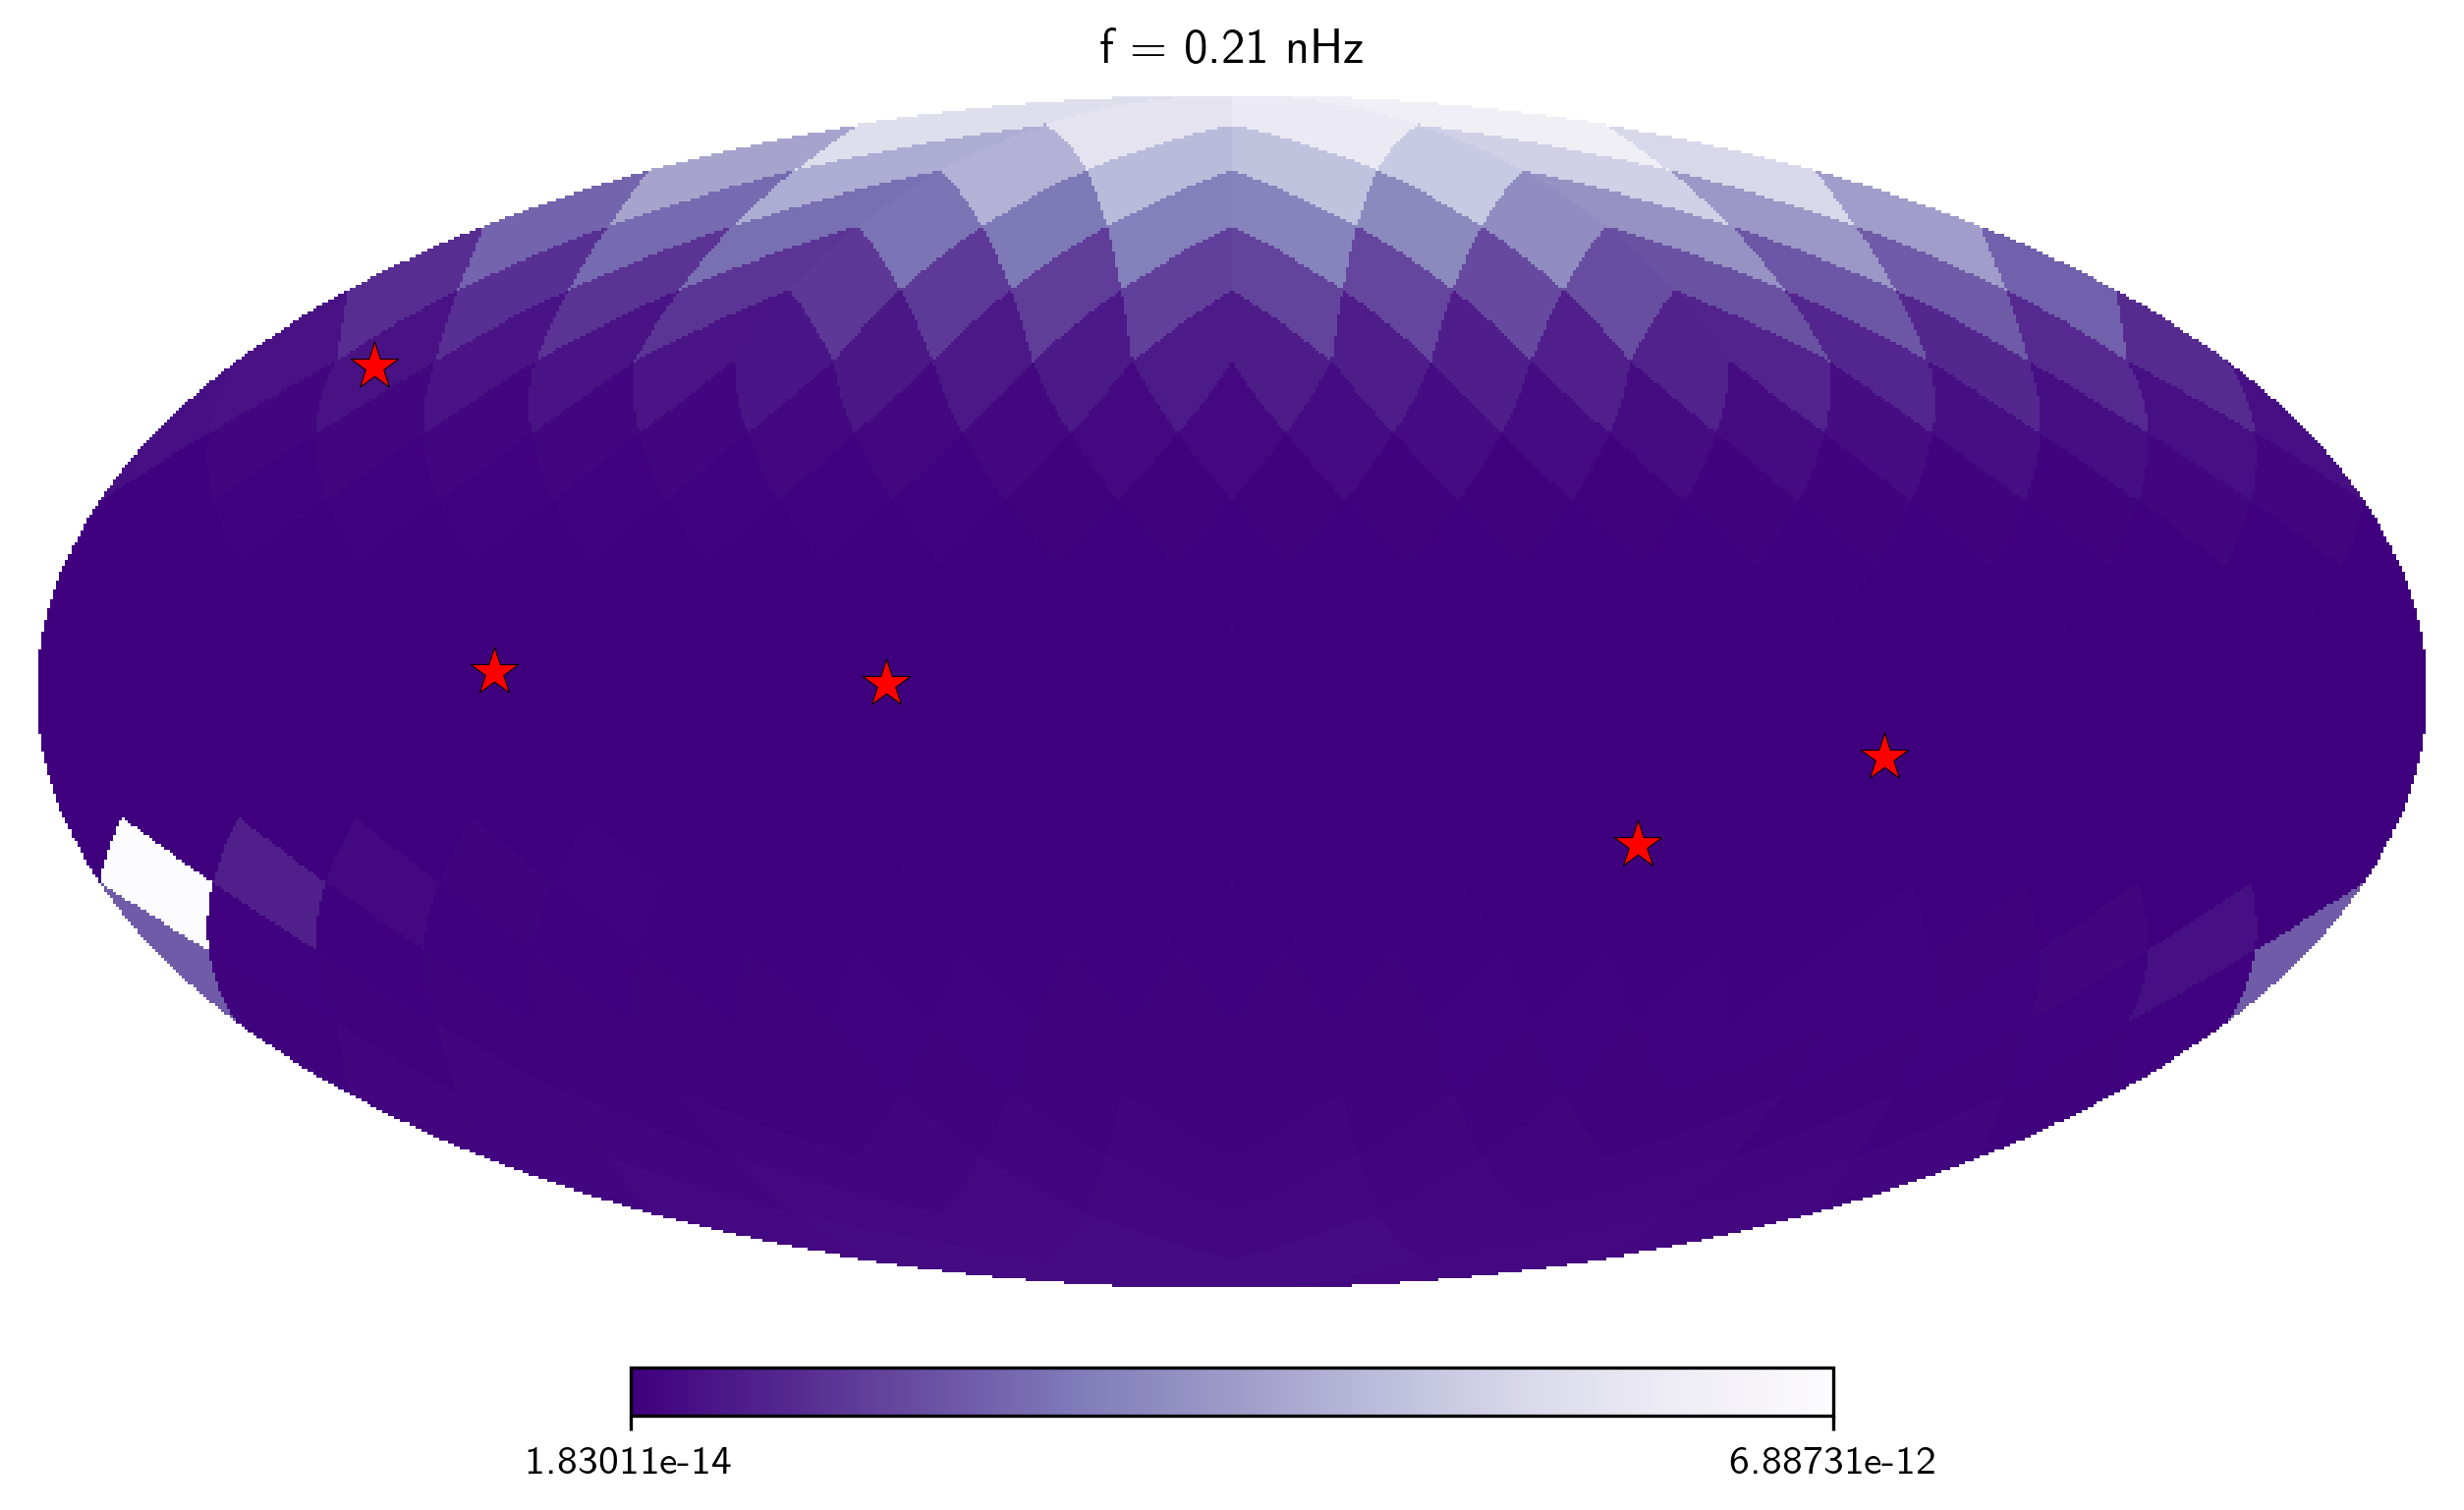

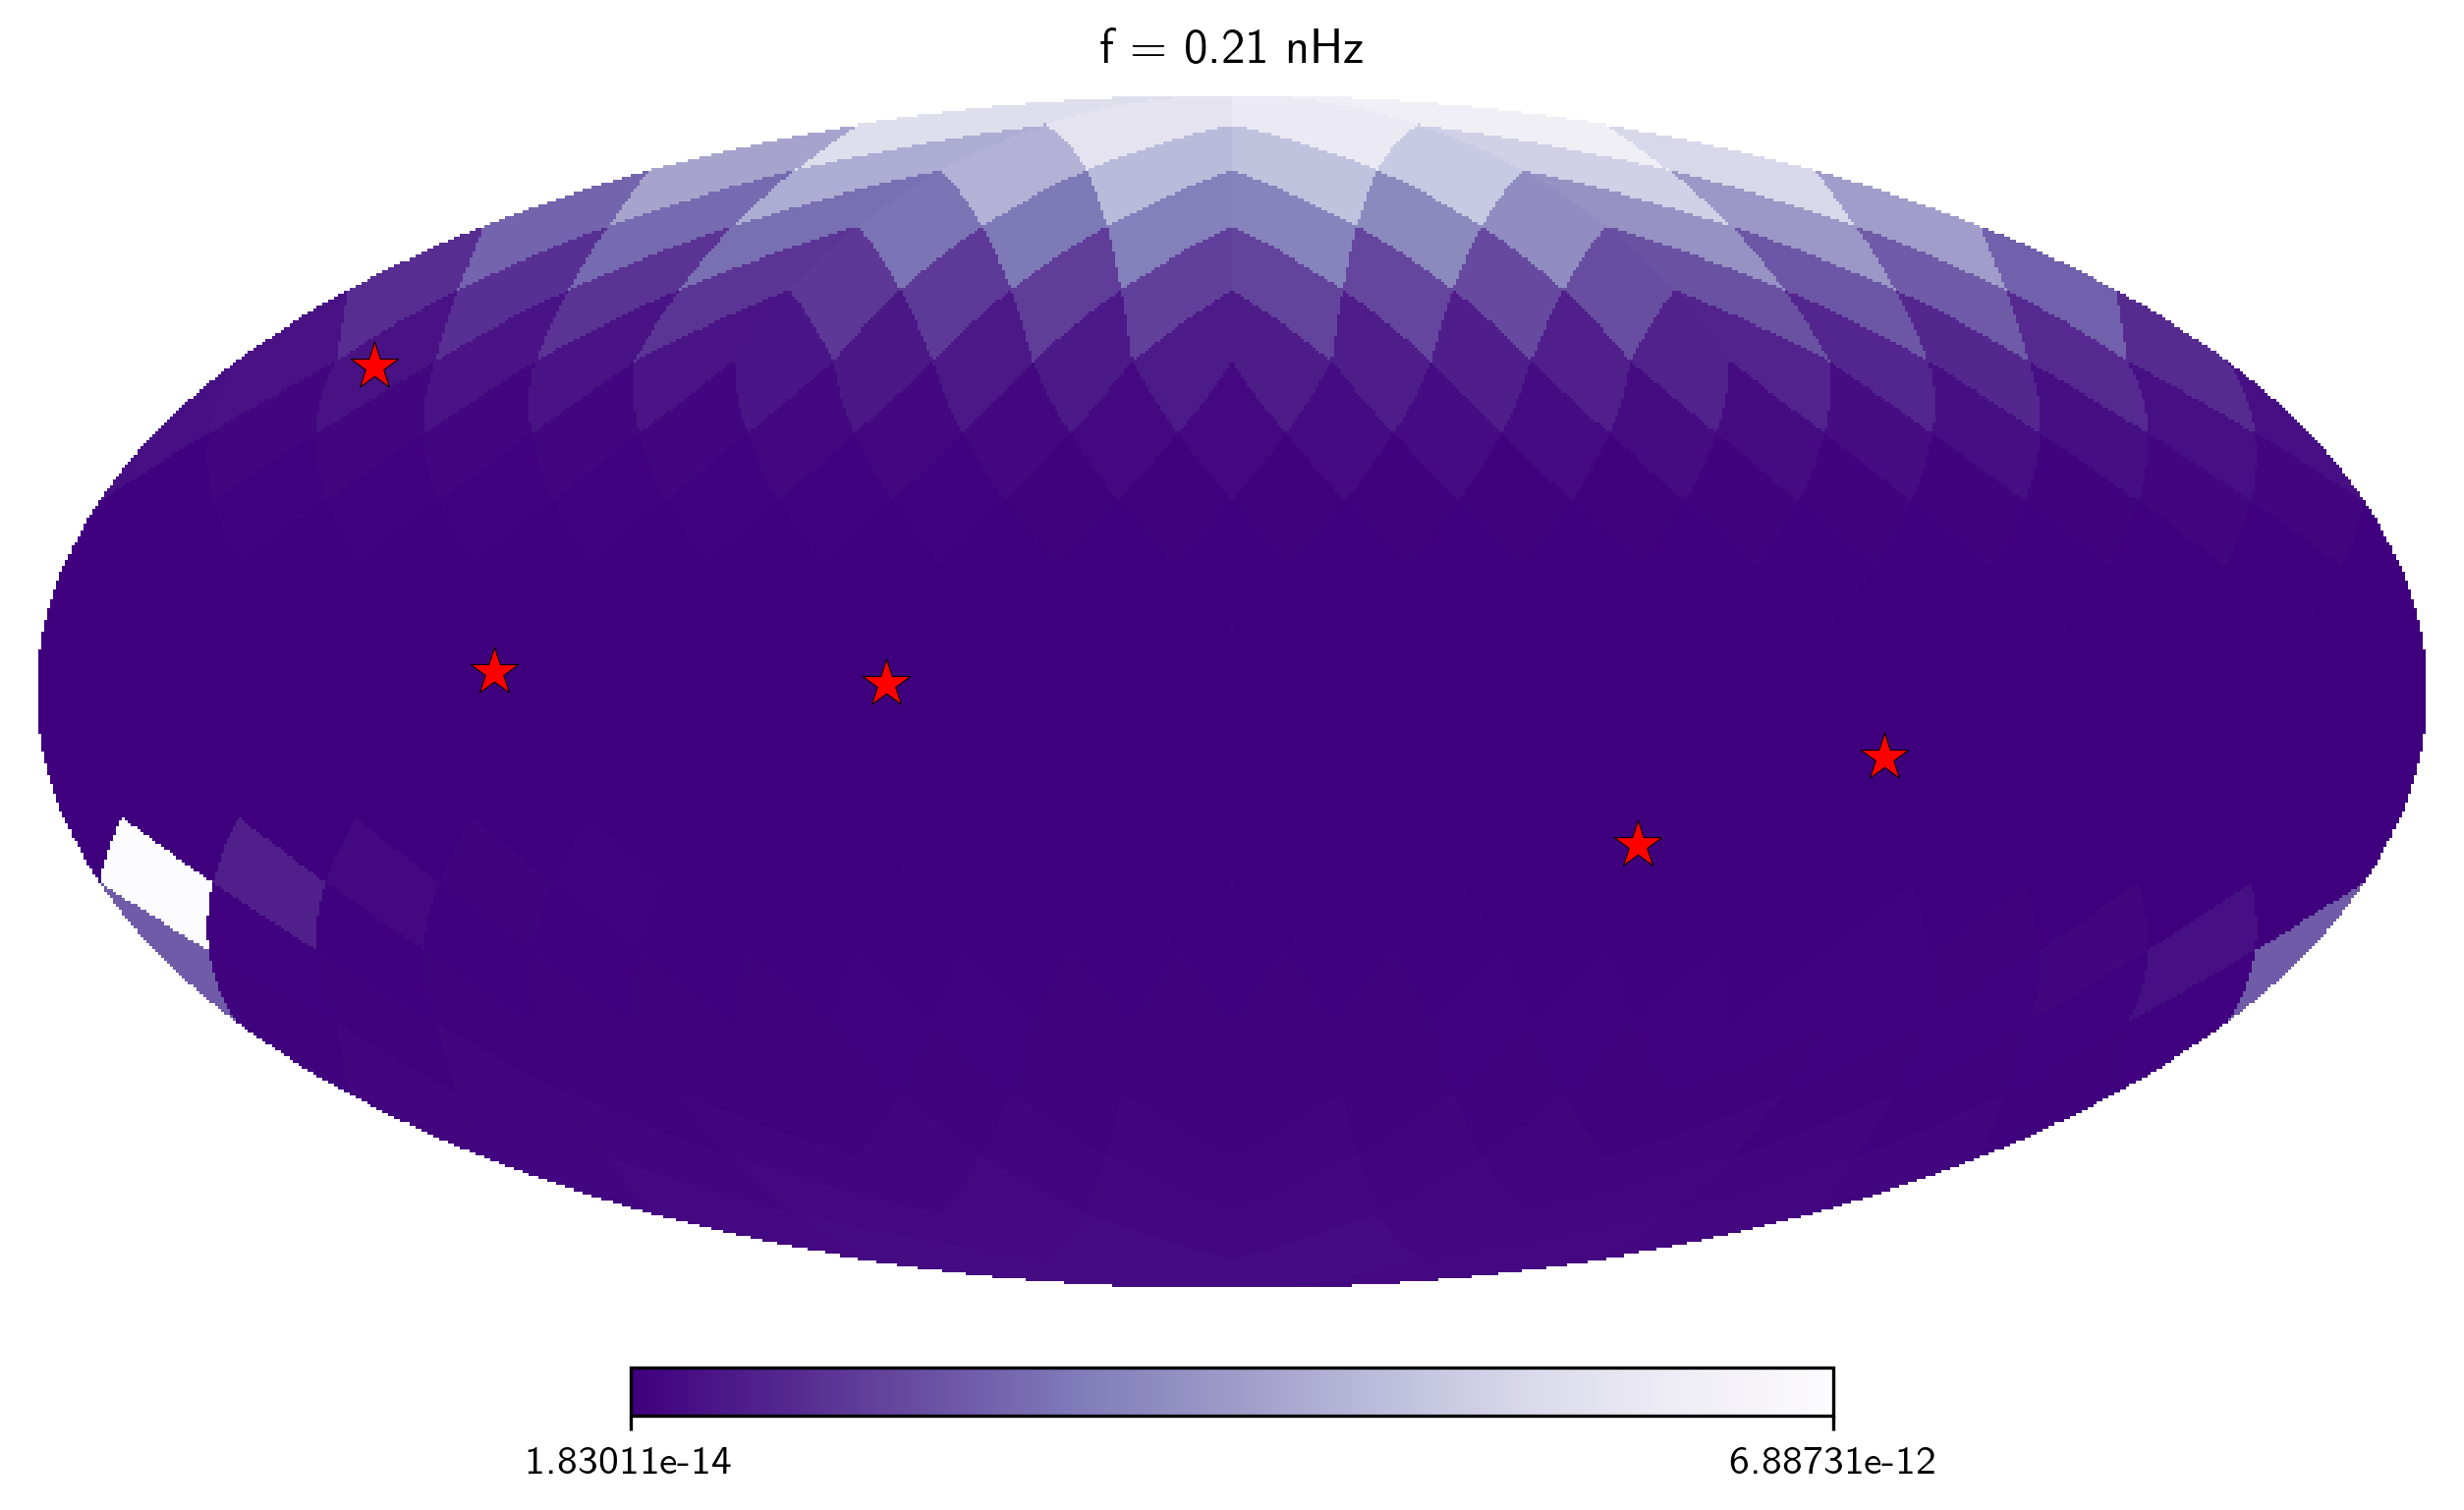

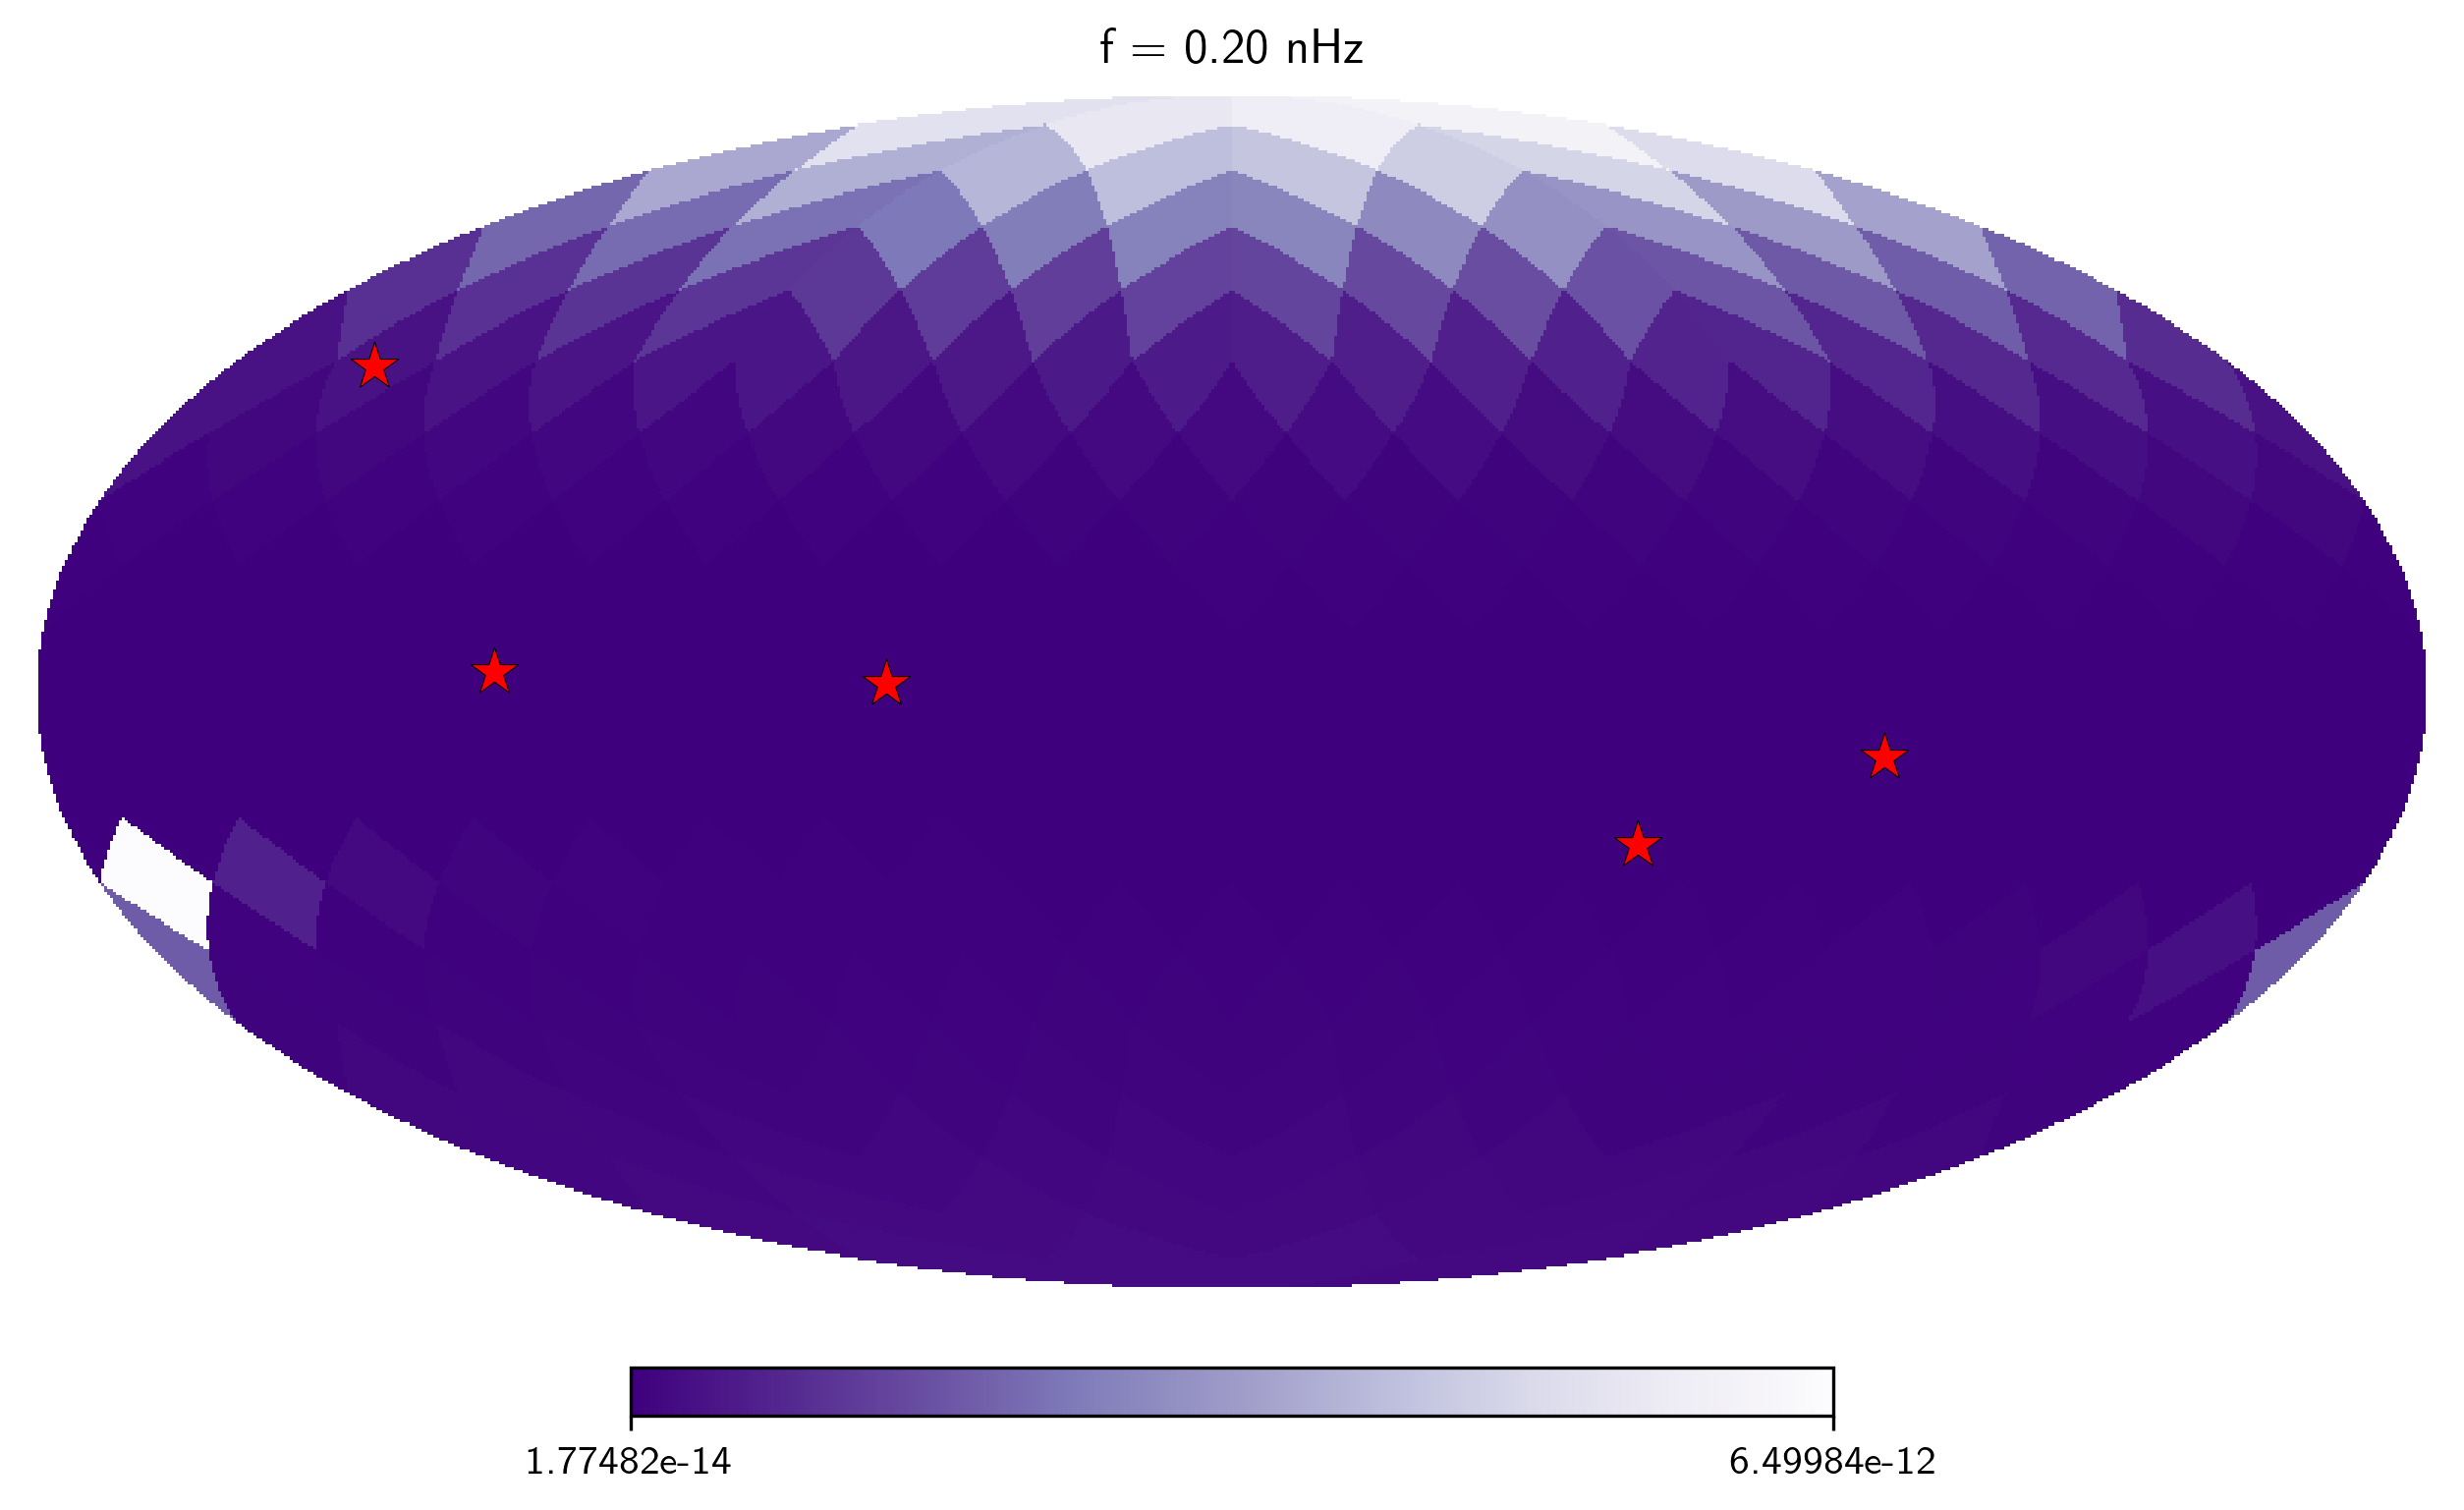

In [ ]:
final_freqs = [max_freq, min_freq, median_freq]
final_freqs_idx = [max_index, min_index, median_index]

for freq, idx in zip(final_freqs, final_freqs_idx):
    # Compute the map at this frequency
    h_c_pixel = ASM.h_c_aniso_pixel(idx)
    
    # Plot the map
    hp.mollview(h_c_pixel, title=f"f = {freq * 1e9:.2f} nHz", cmap='Purples_r', rot=(180,0,0))

    # Overlay pulsar positions
    hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
                            edgecolors='black', linewidths=0.25, s=150, alpha=1, rot=(180,0,0))
    
    plt.show()


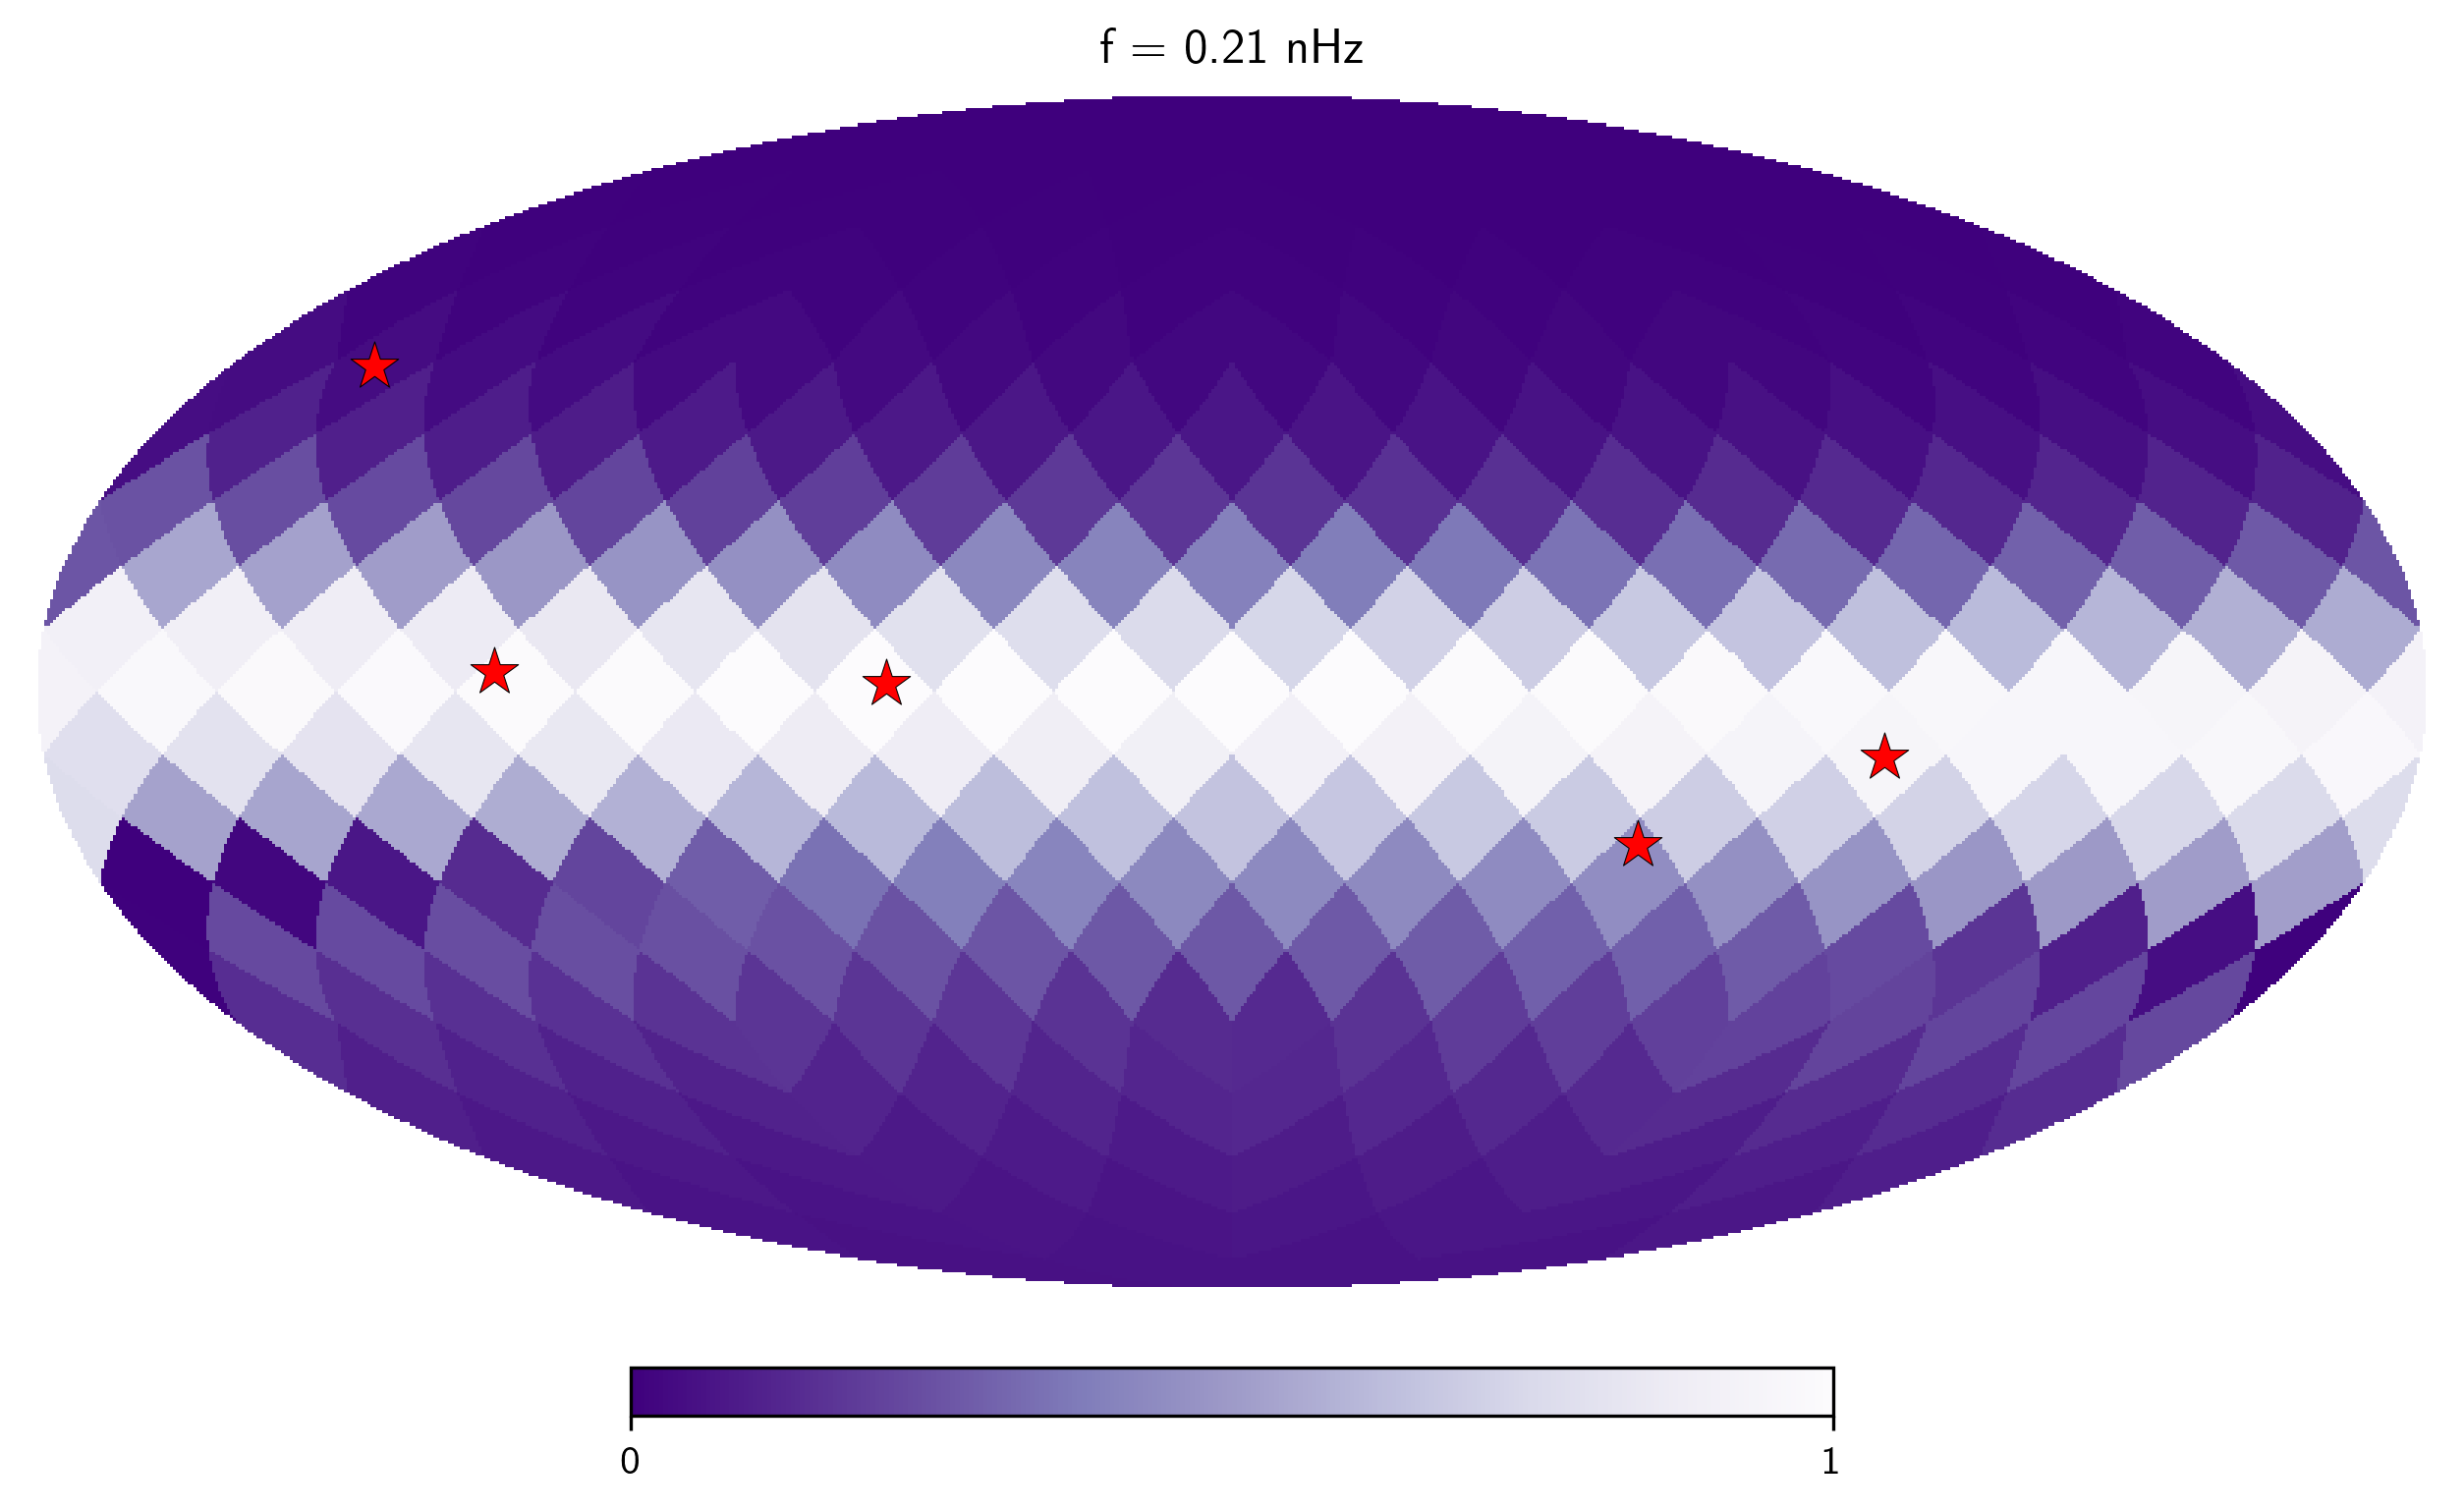

In [ ]:
M_kk_pixel = np.sqrt(ASM.M_kk[:, max_index])/Tspan

# Rescale M_kk_pixel such that min = 0 and max = 1
M_kk_pixel_norm = (M_kk_pixel - np.min(M_kk_pixel)) / (np.max(M_kk_pixel) - np.min(M_kk_pixel))

# Plot the map with the normalized values
hp.mollview(M_kk_pixel_norm, title=f"f = {max_freq * 1e9:.2f} nHz", cmap='Purples_r', rot=(180,0,0))

# Overlay pulsar positions
hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
                        edgecolors='black', linewidths=0.25, s=150, alpha=1, rot=(180,0,0))

plt.show()



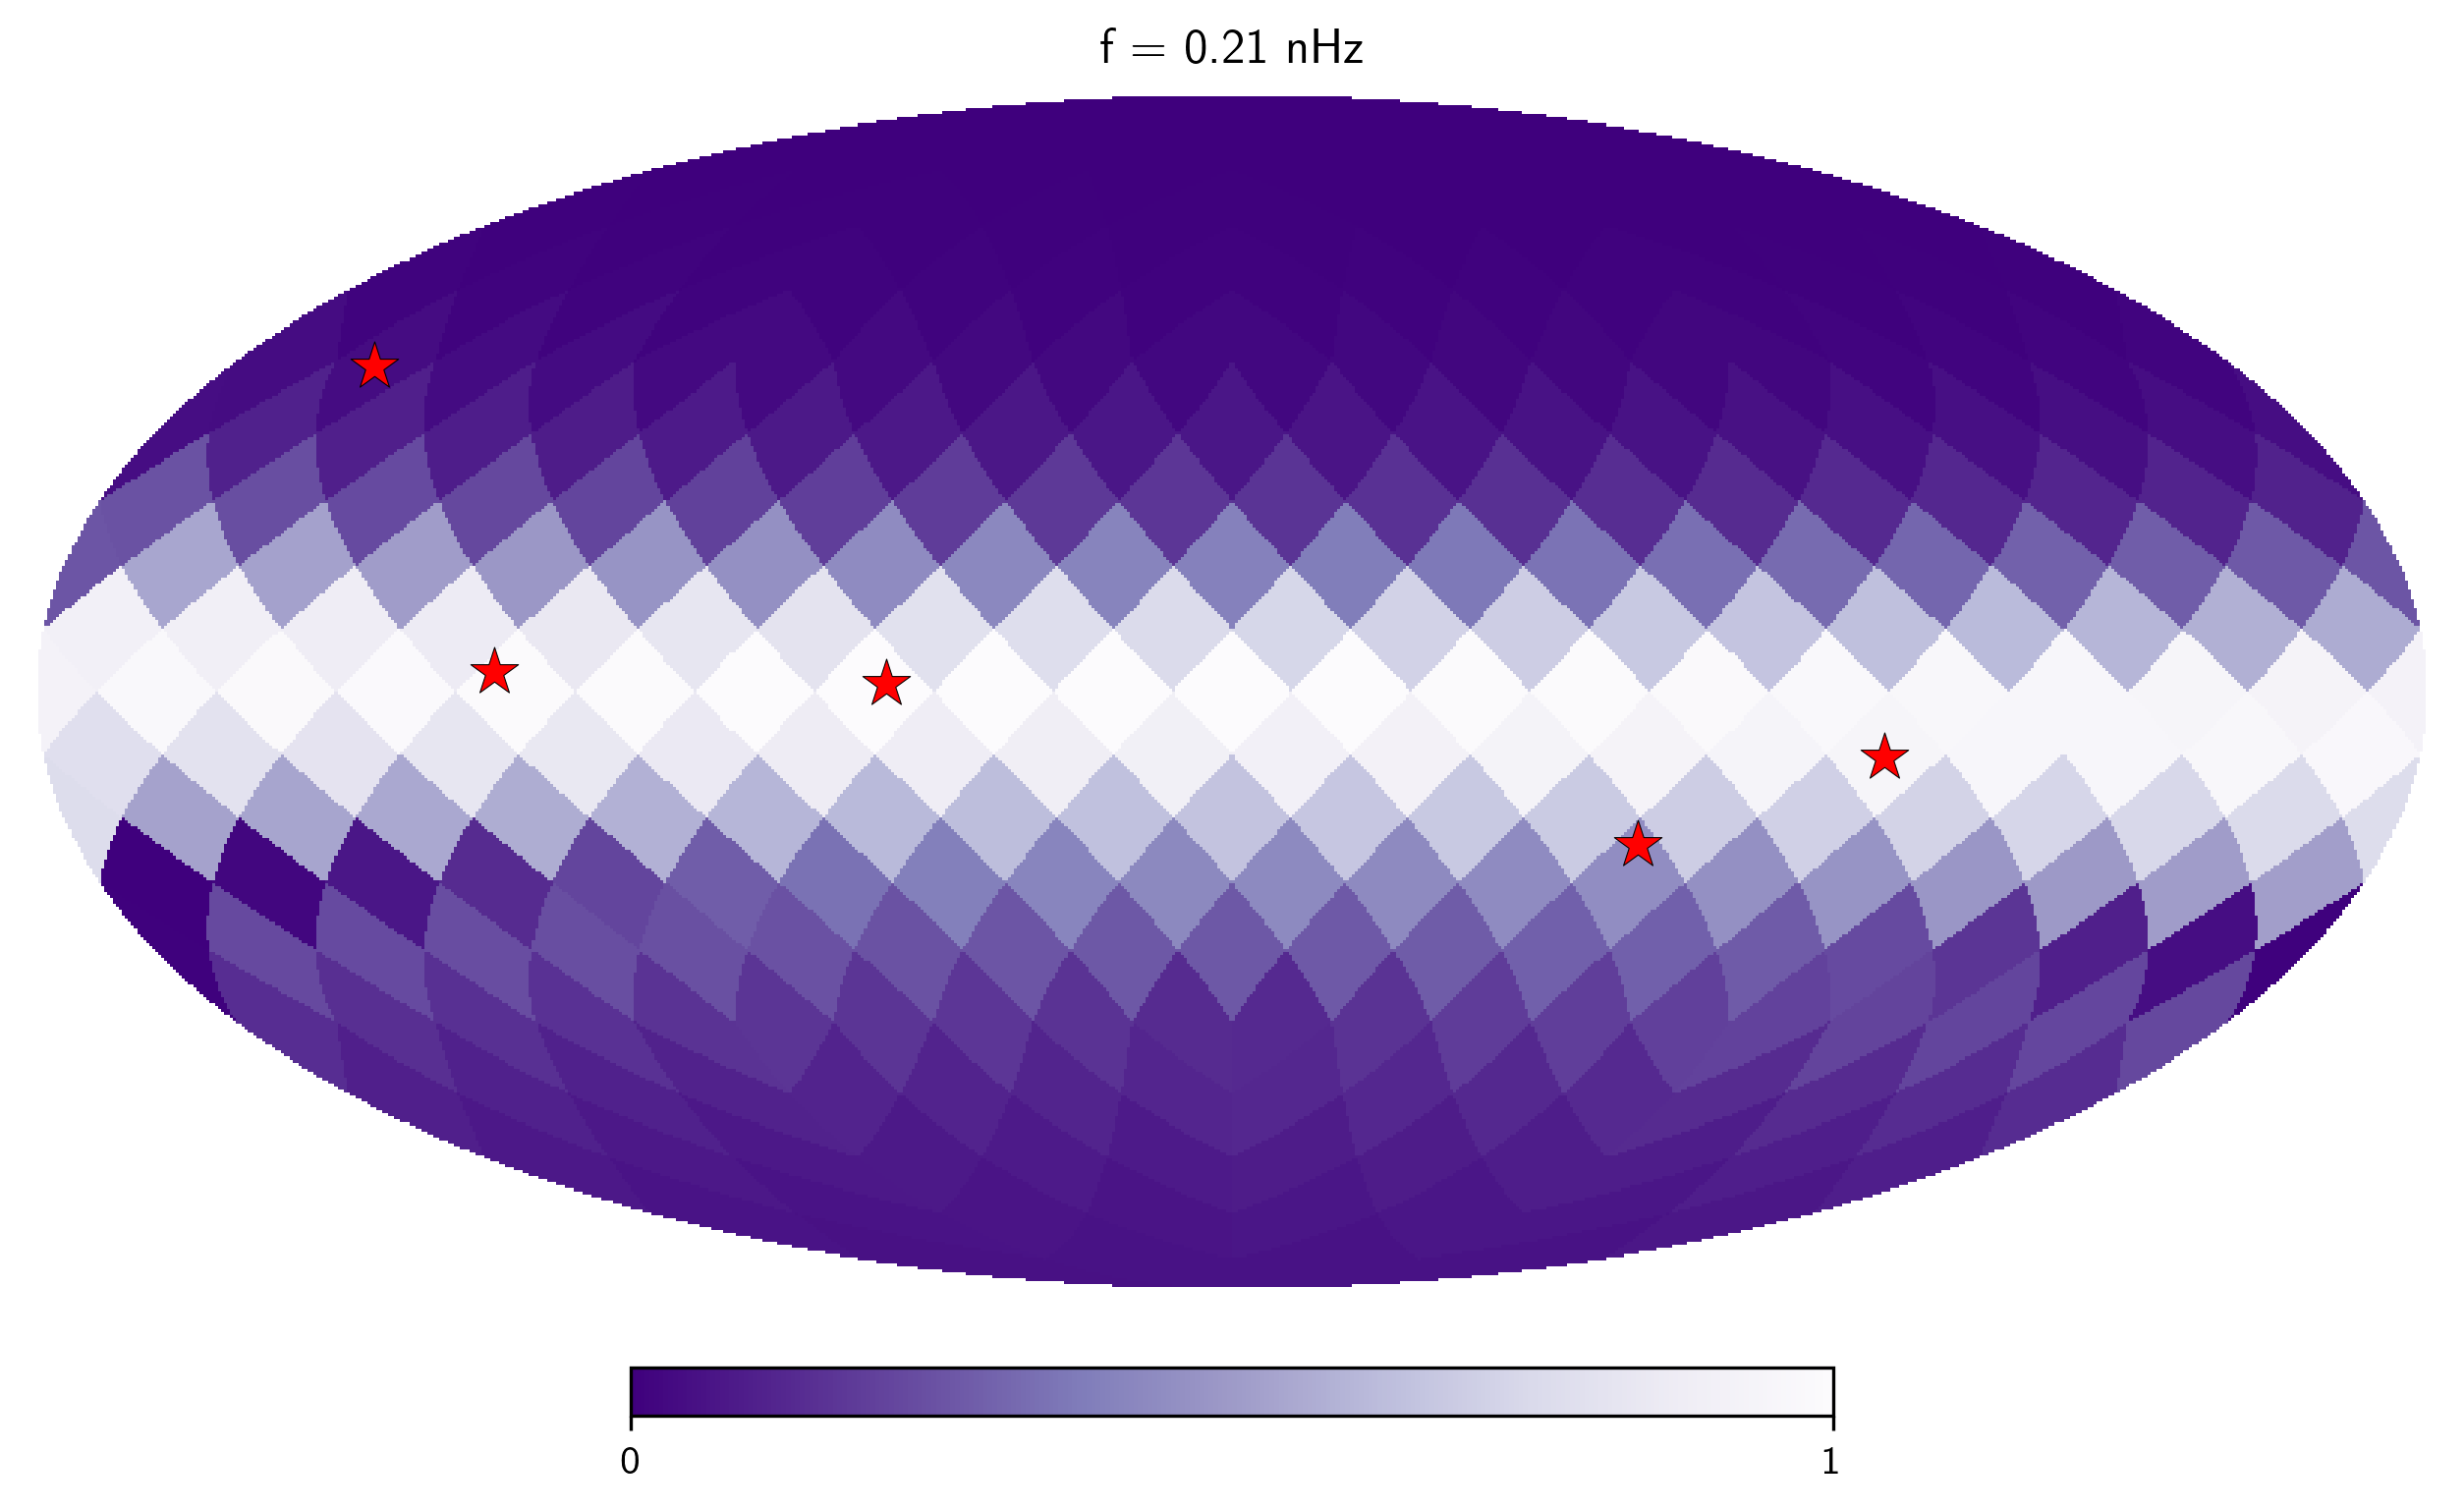

In [ ]:
M_kk_pixel = np.sqrt(ASM.M_kk[:, min_index])/Tspan

# Rescale M_kk_pixel such that min = 0 and max = 1
M_kk_pixel_norm = (M_kk_pixel - np.min(M_kk_pixel)) / (np.max(M_kk_pixel) - np.min(M_kk_pixel))

# Plot the map with the normalized values
hp.mollview(M_kk_pixel_norm, title=f"f = {min_freq * 1e9:.2f} nHz", cmap='Purples_r', rot=(180,0,0))

# Overlay pulsar positions
hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
                        edgecolors='black', linewidths=0.25, s=150, alpha=1, rot=(180,0,0))

plt.show()



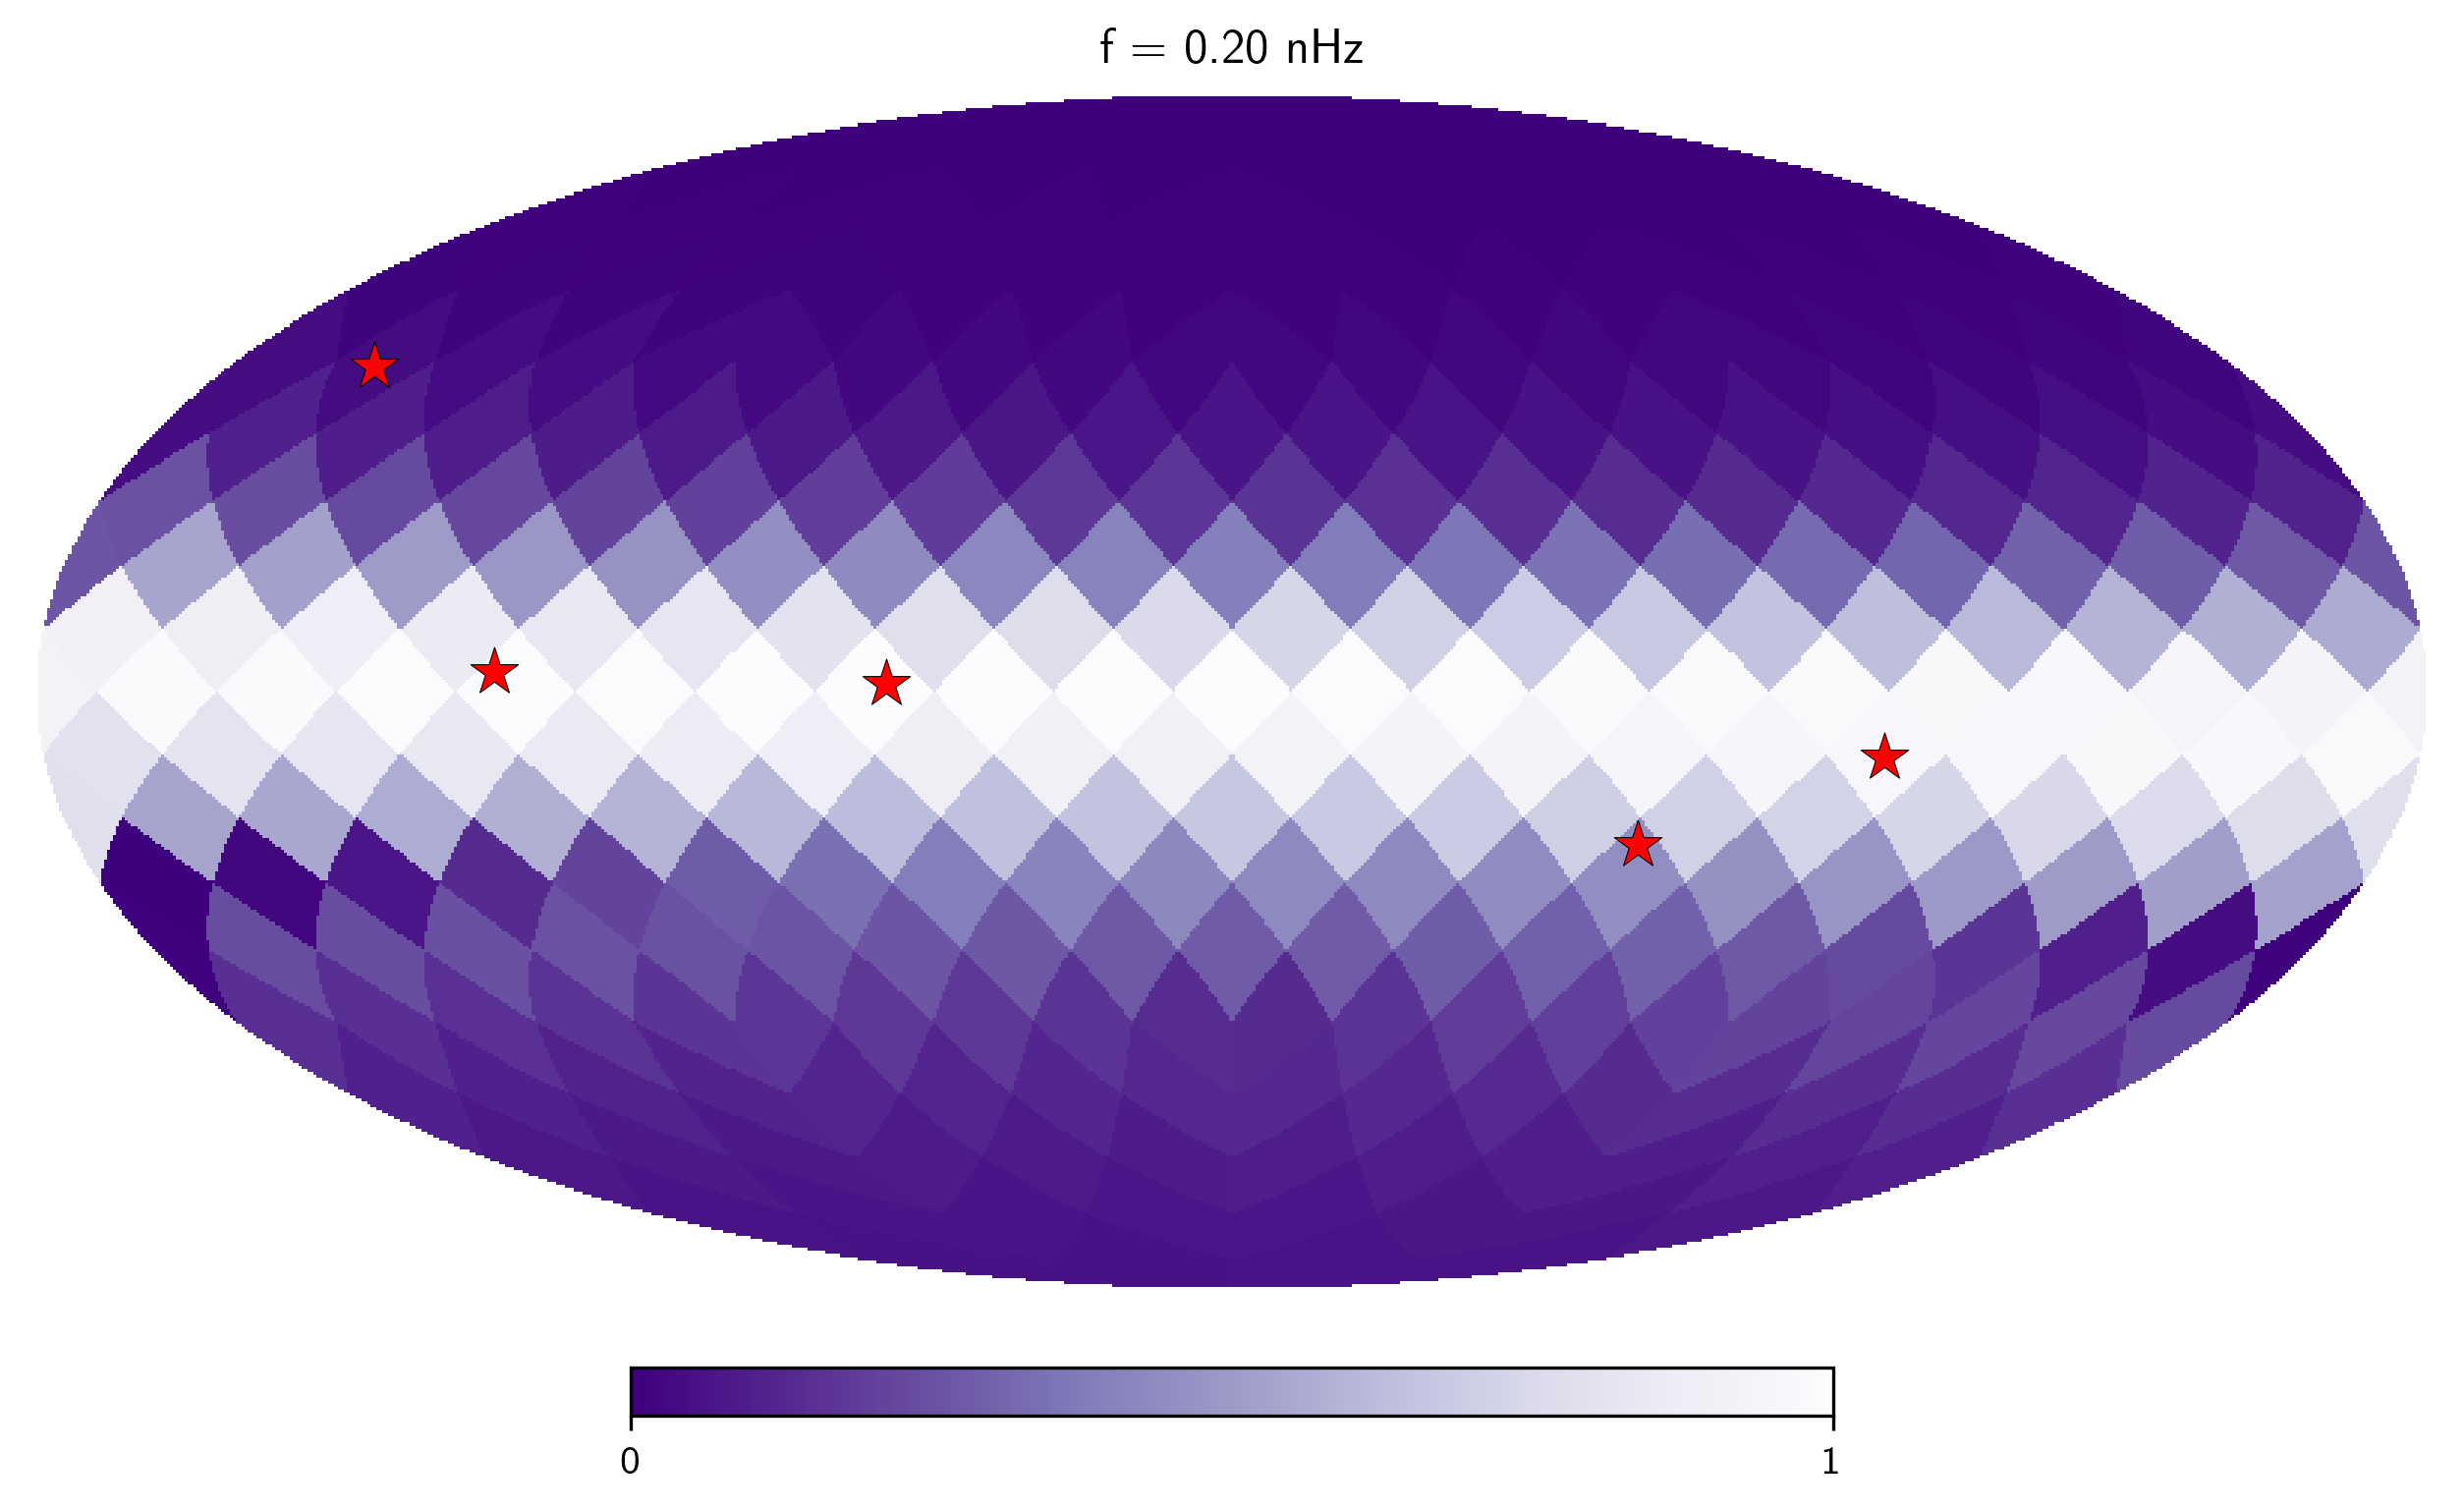

In [ ]:
M_kk_pixel = np.sqrt(ASM.M_kk[:, median_index])/Tspan

# Rescale M_kk_pixel such that min = 0 and max = 1
M_kk_pixel_norm = (M_kk_pixel - np.min(M_kk_pixel)) / (np.max(M_kk_pixel) - np.min(M_kk_pixel))

# Plot the map with the normalized values
hp.mollview(M_kk_pixel_norm, title=f"f = {median_freq * 1e9:.2f} nHz", cmap='Purples_r', rot=(180,0,0))

# Overlay pulsar positions
hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
                        edgecolors='black', linewidths=0.25, s=150, alpha=1, rot=(180,0,0))

plt.show()



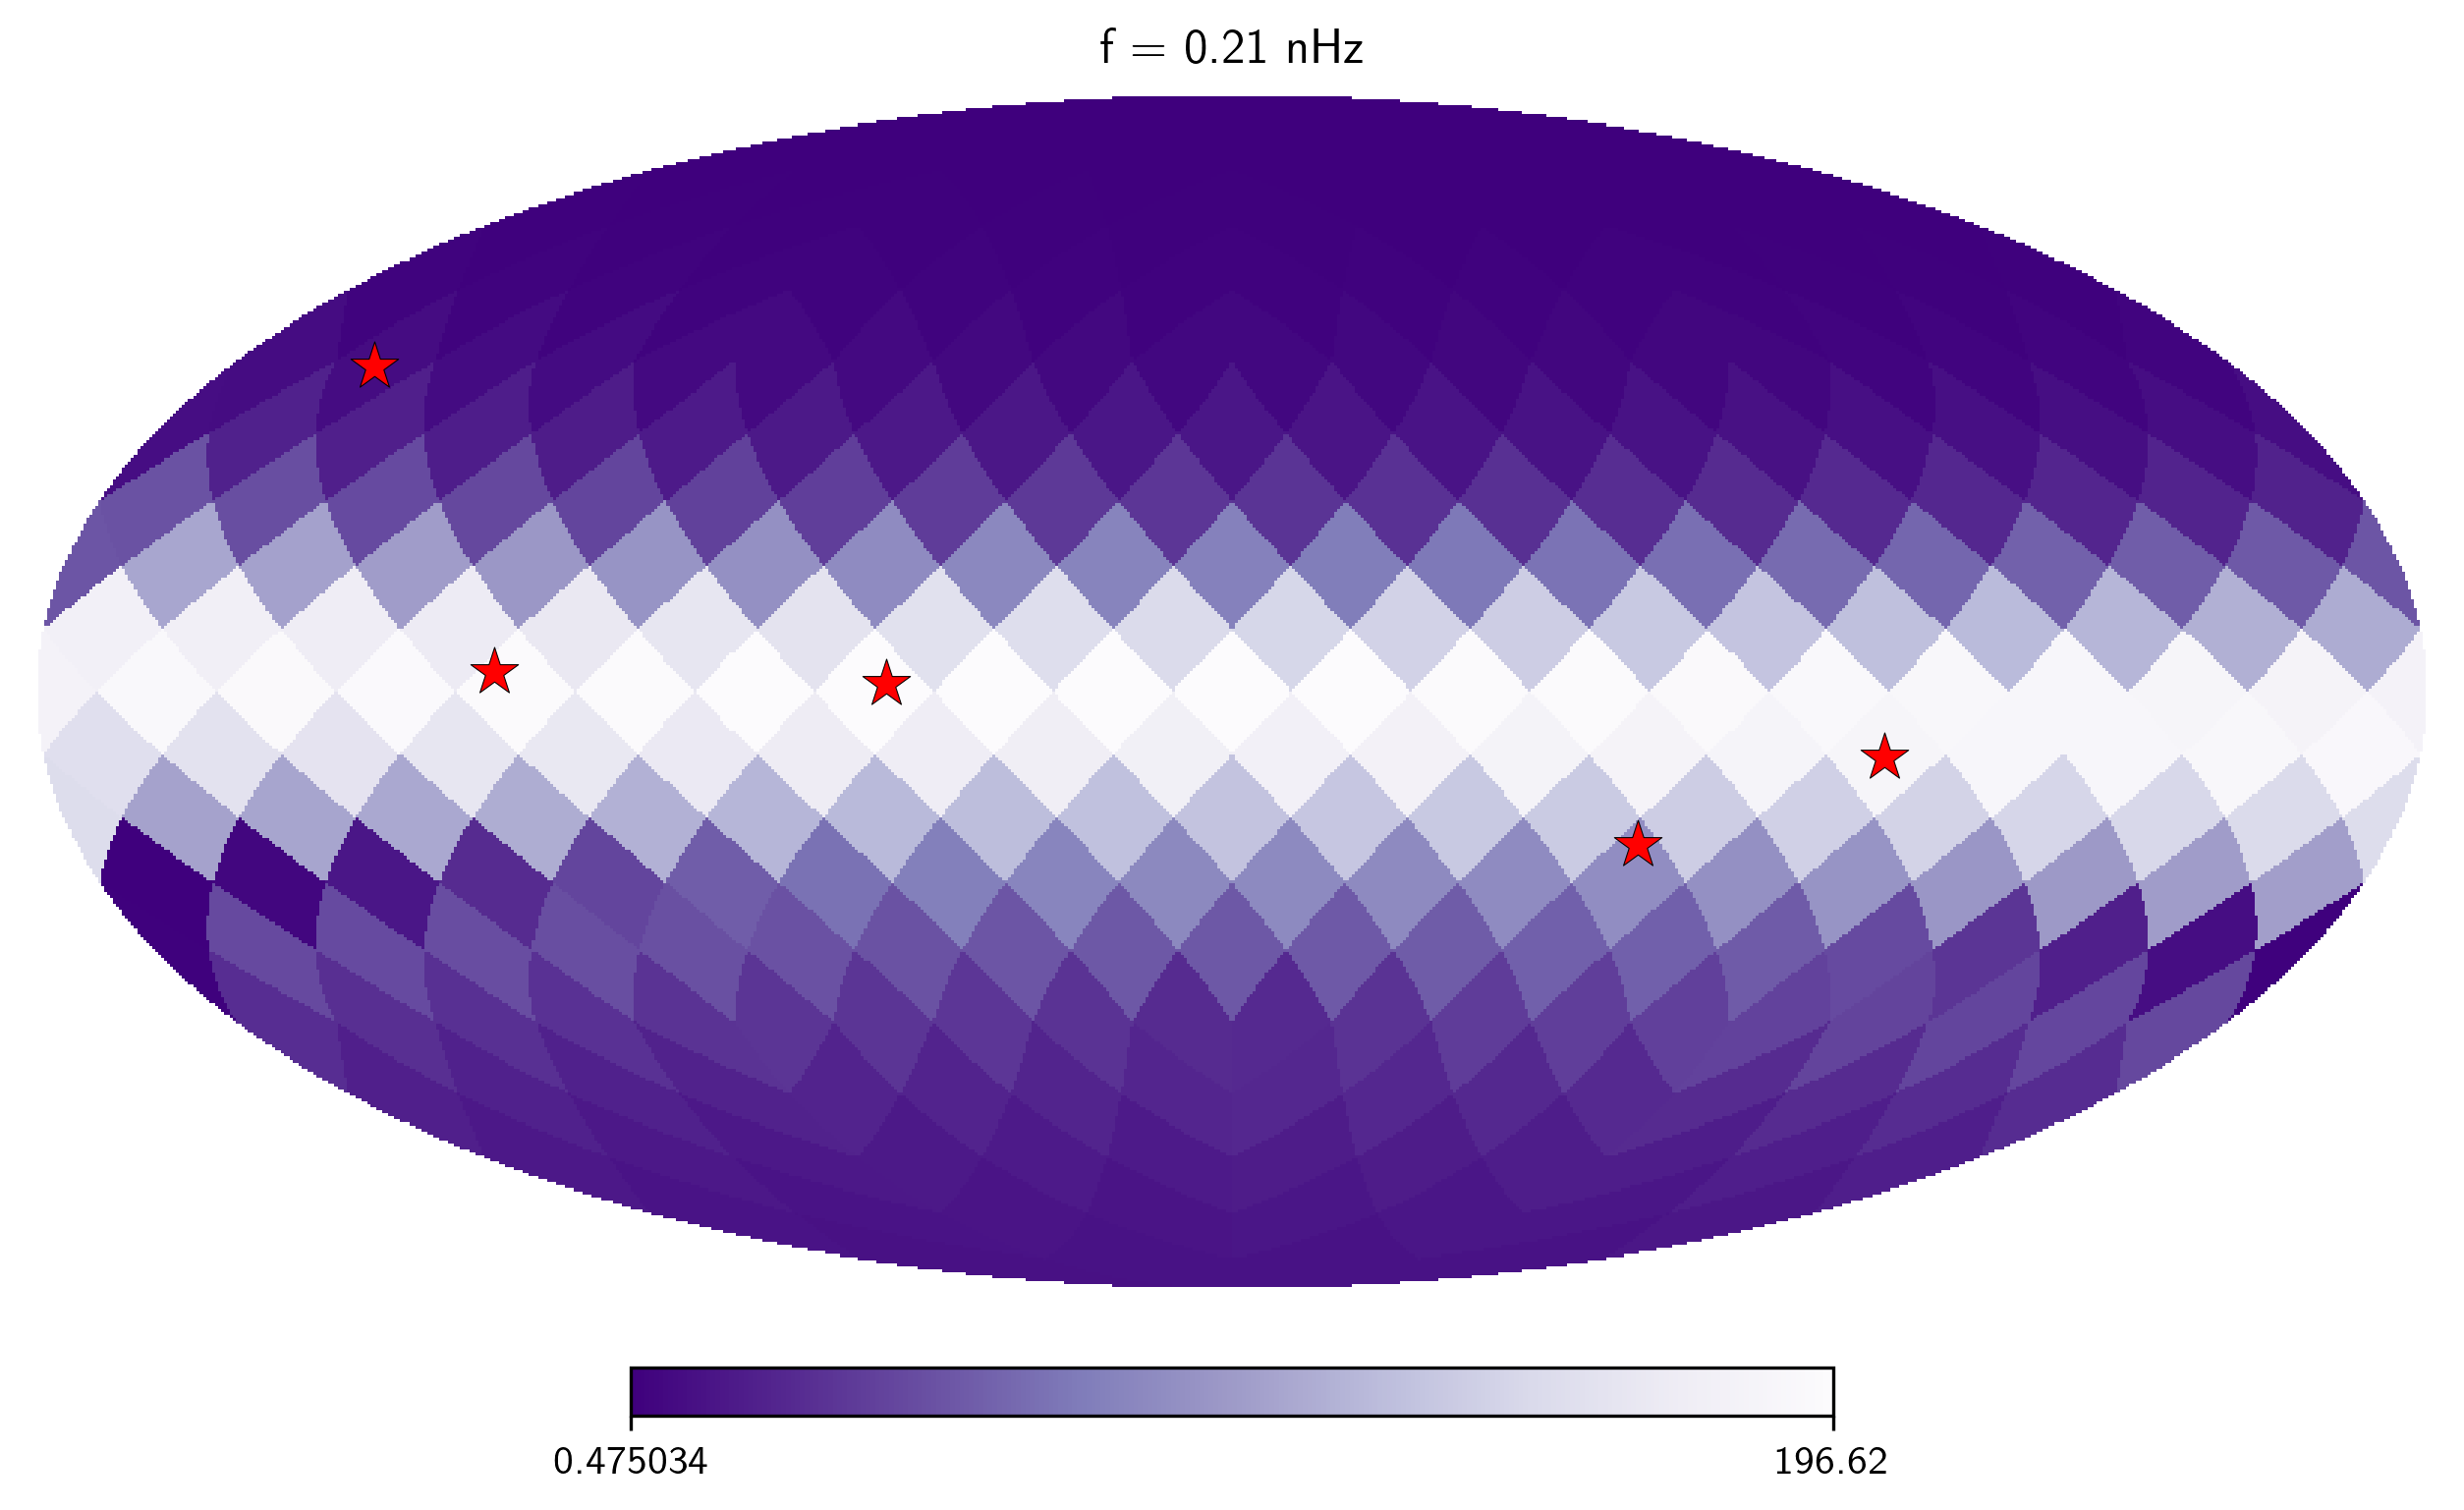

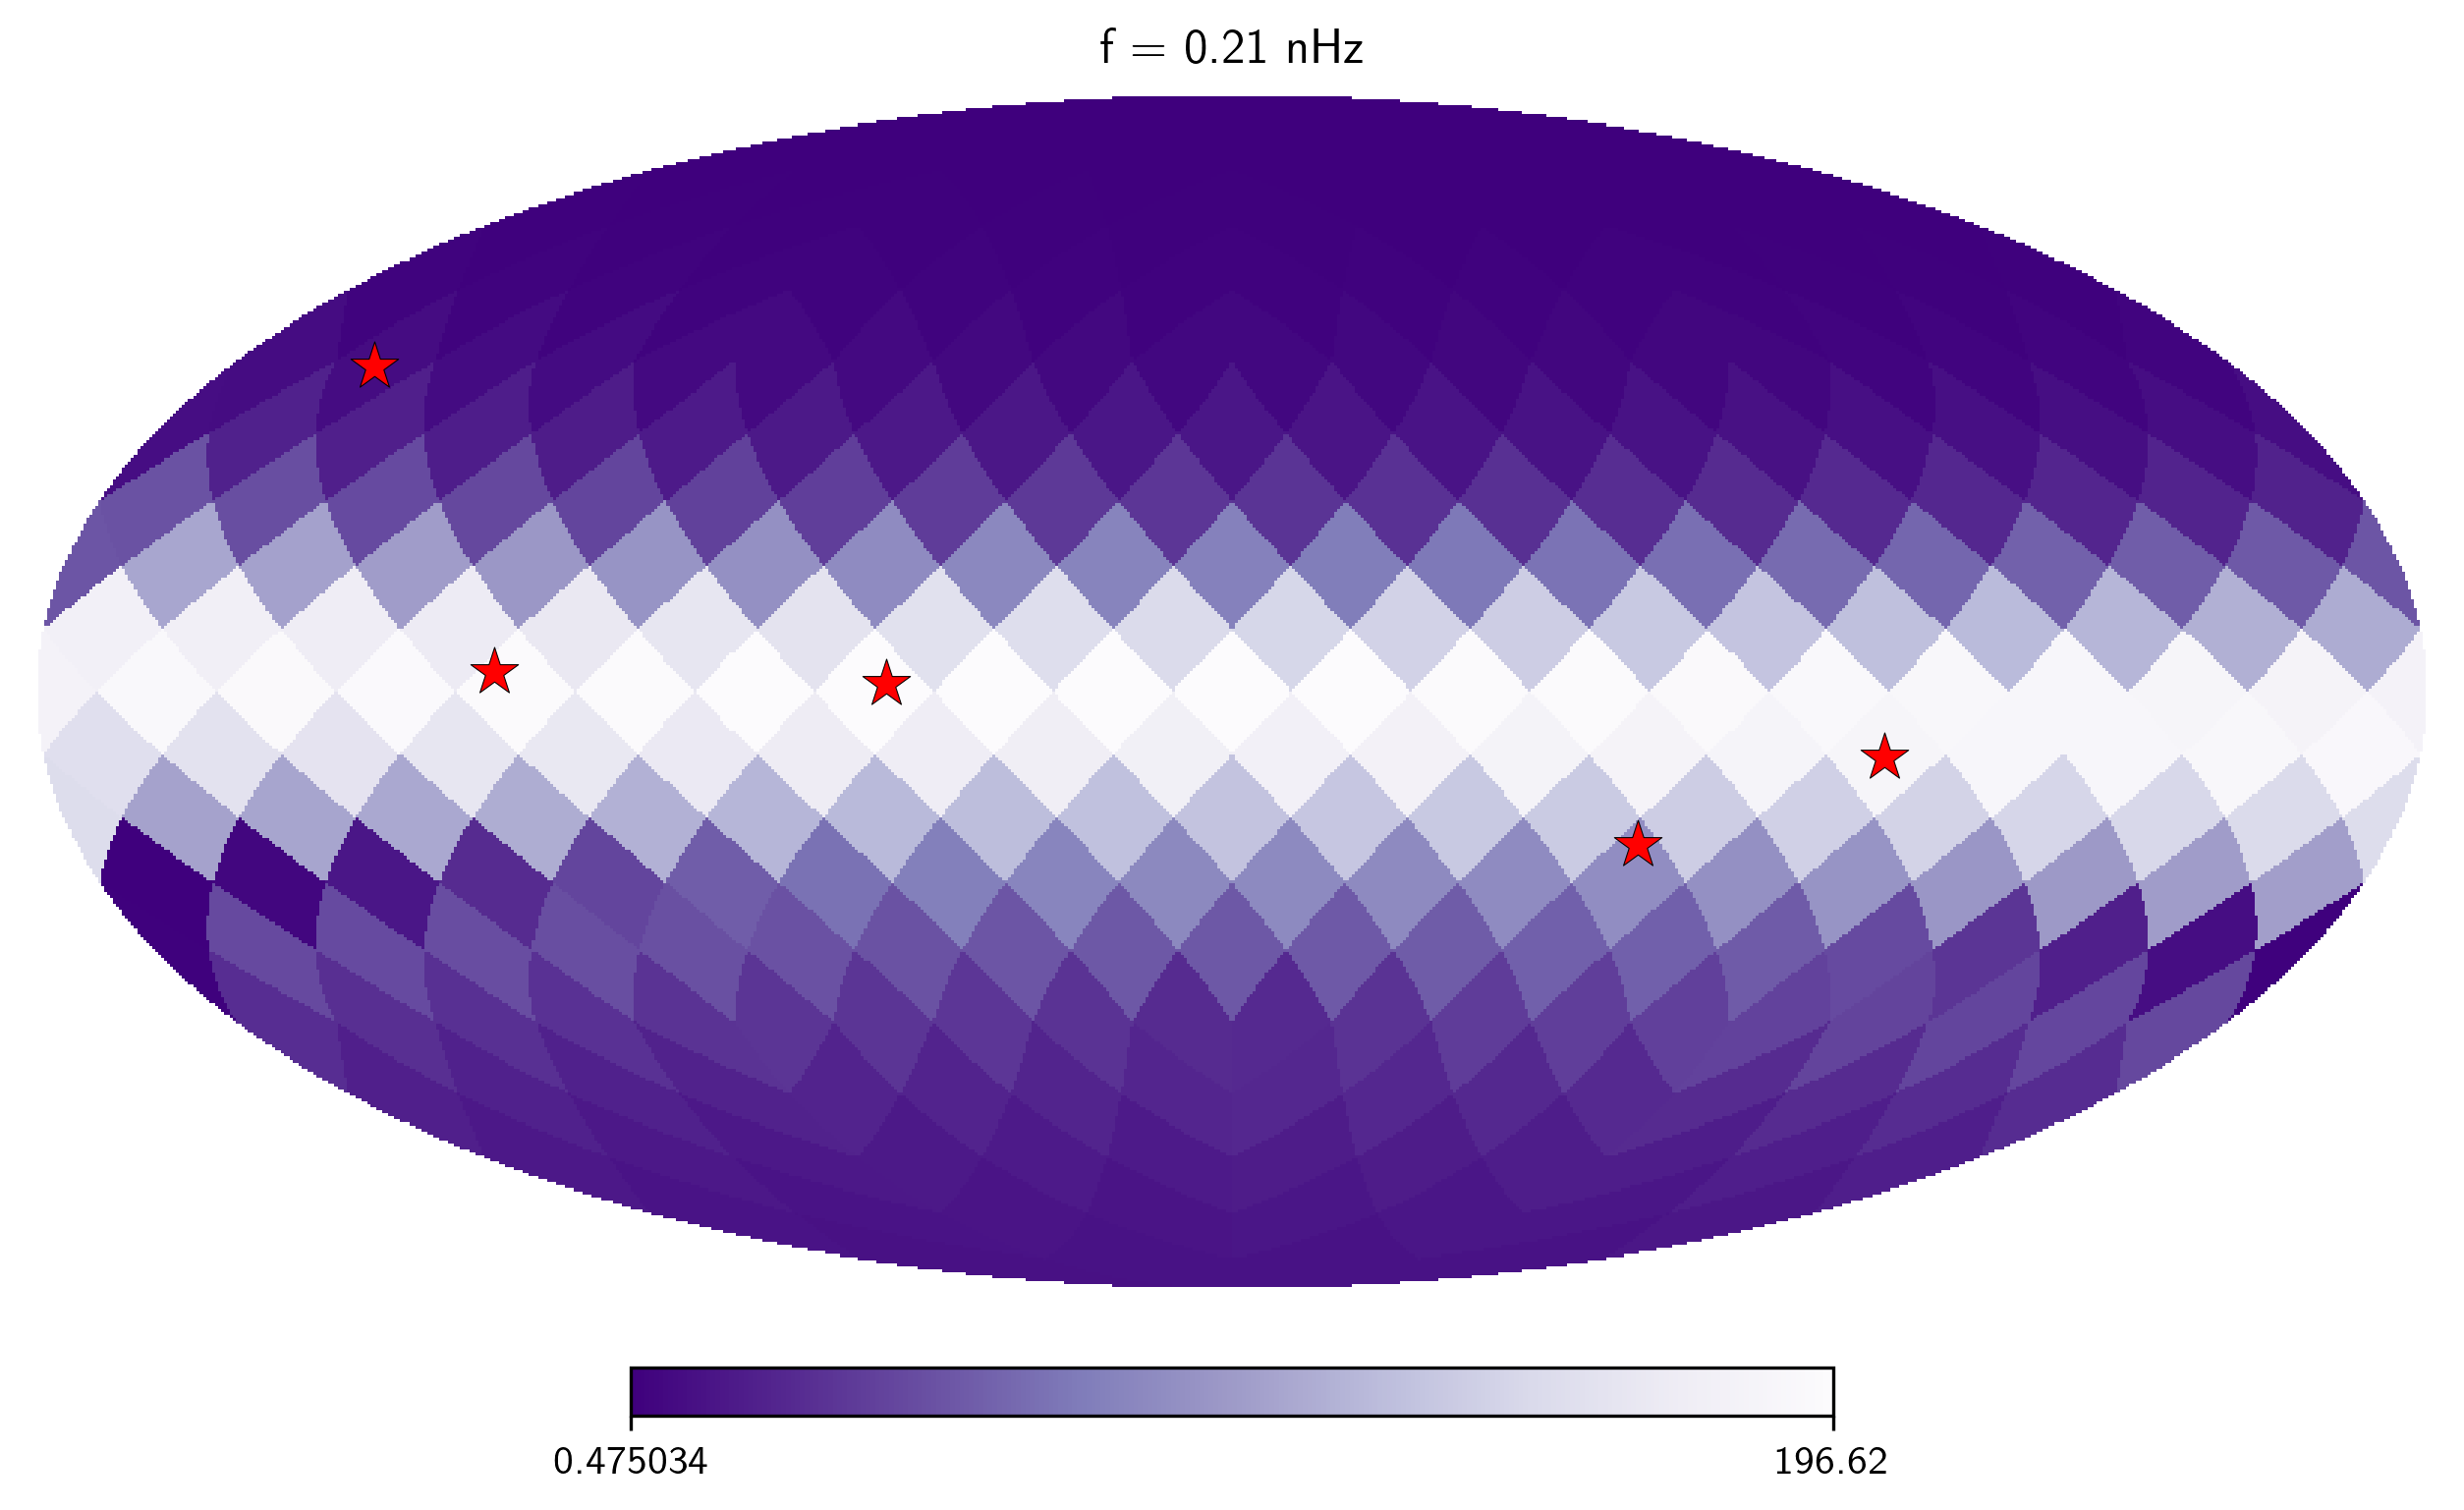

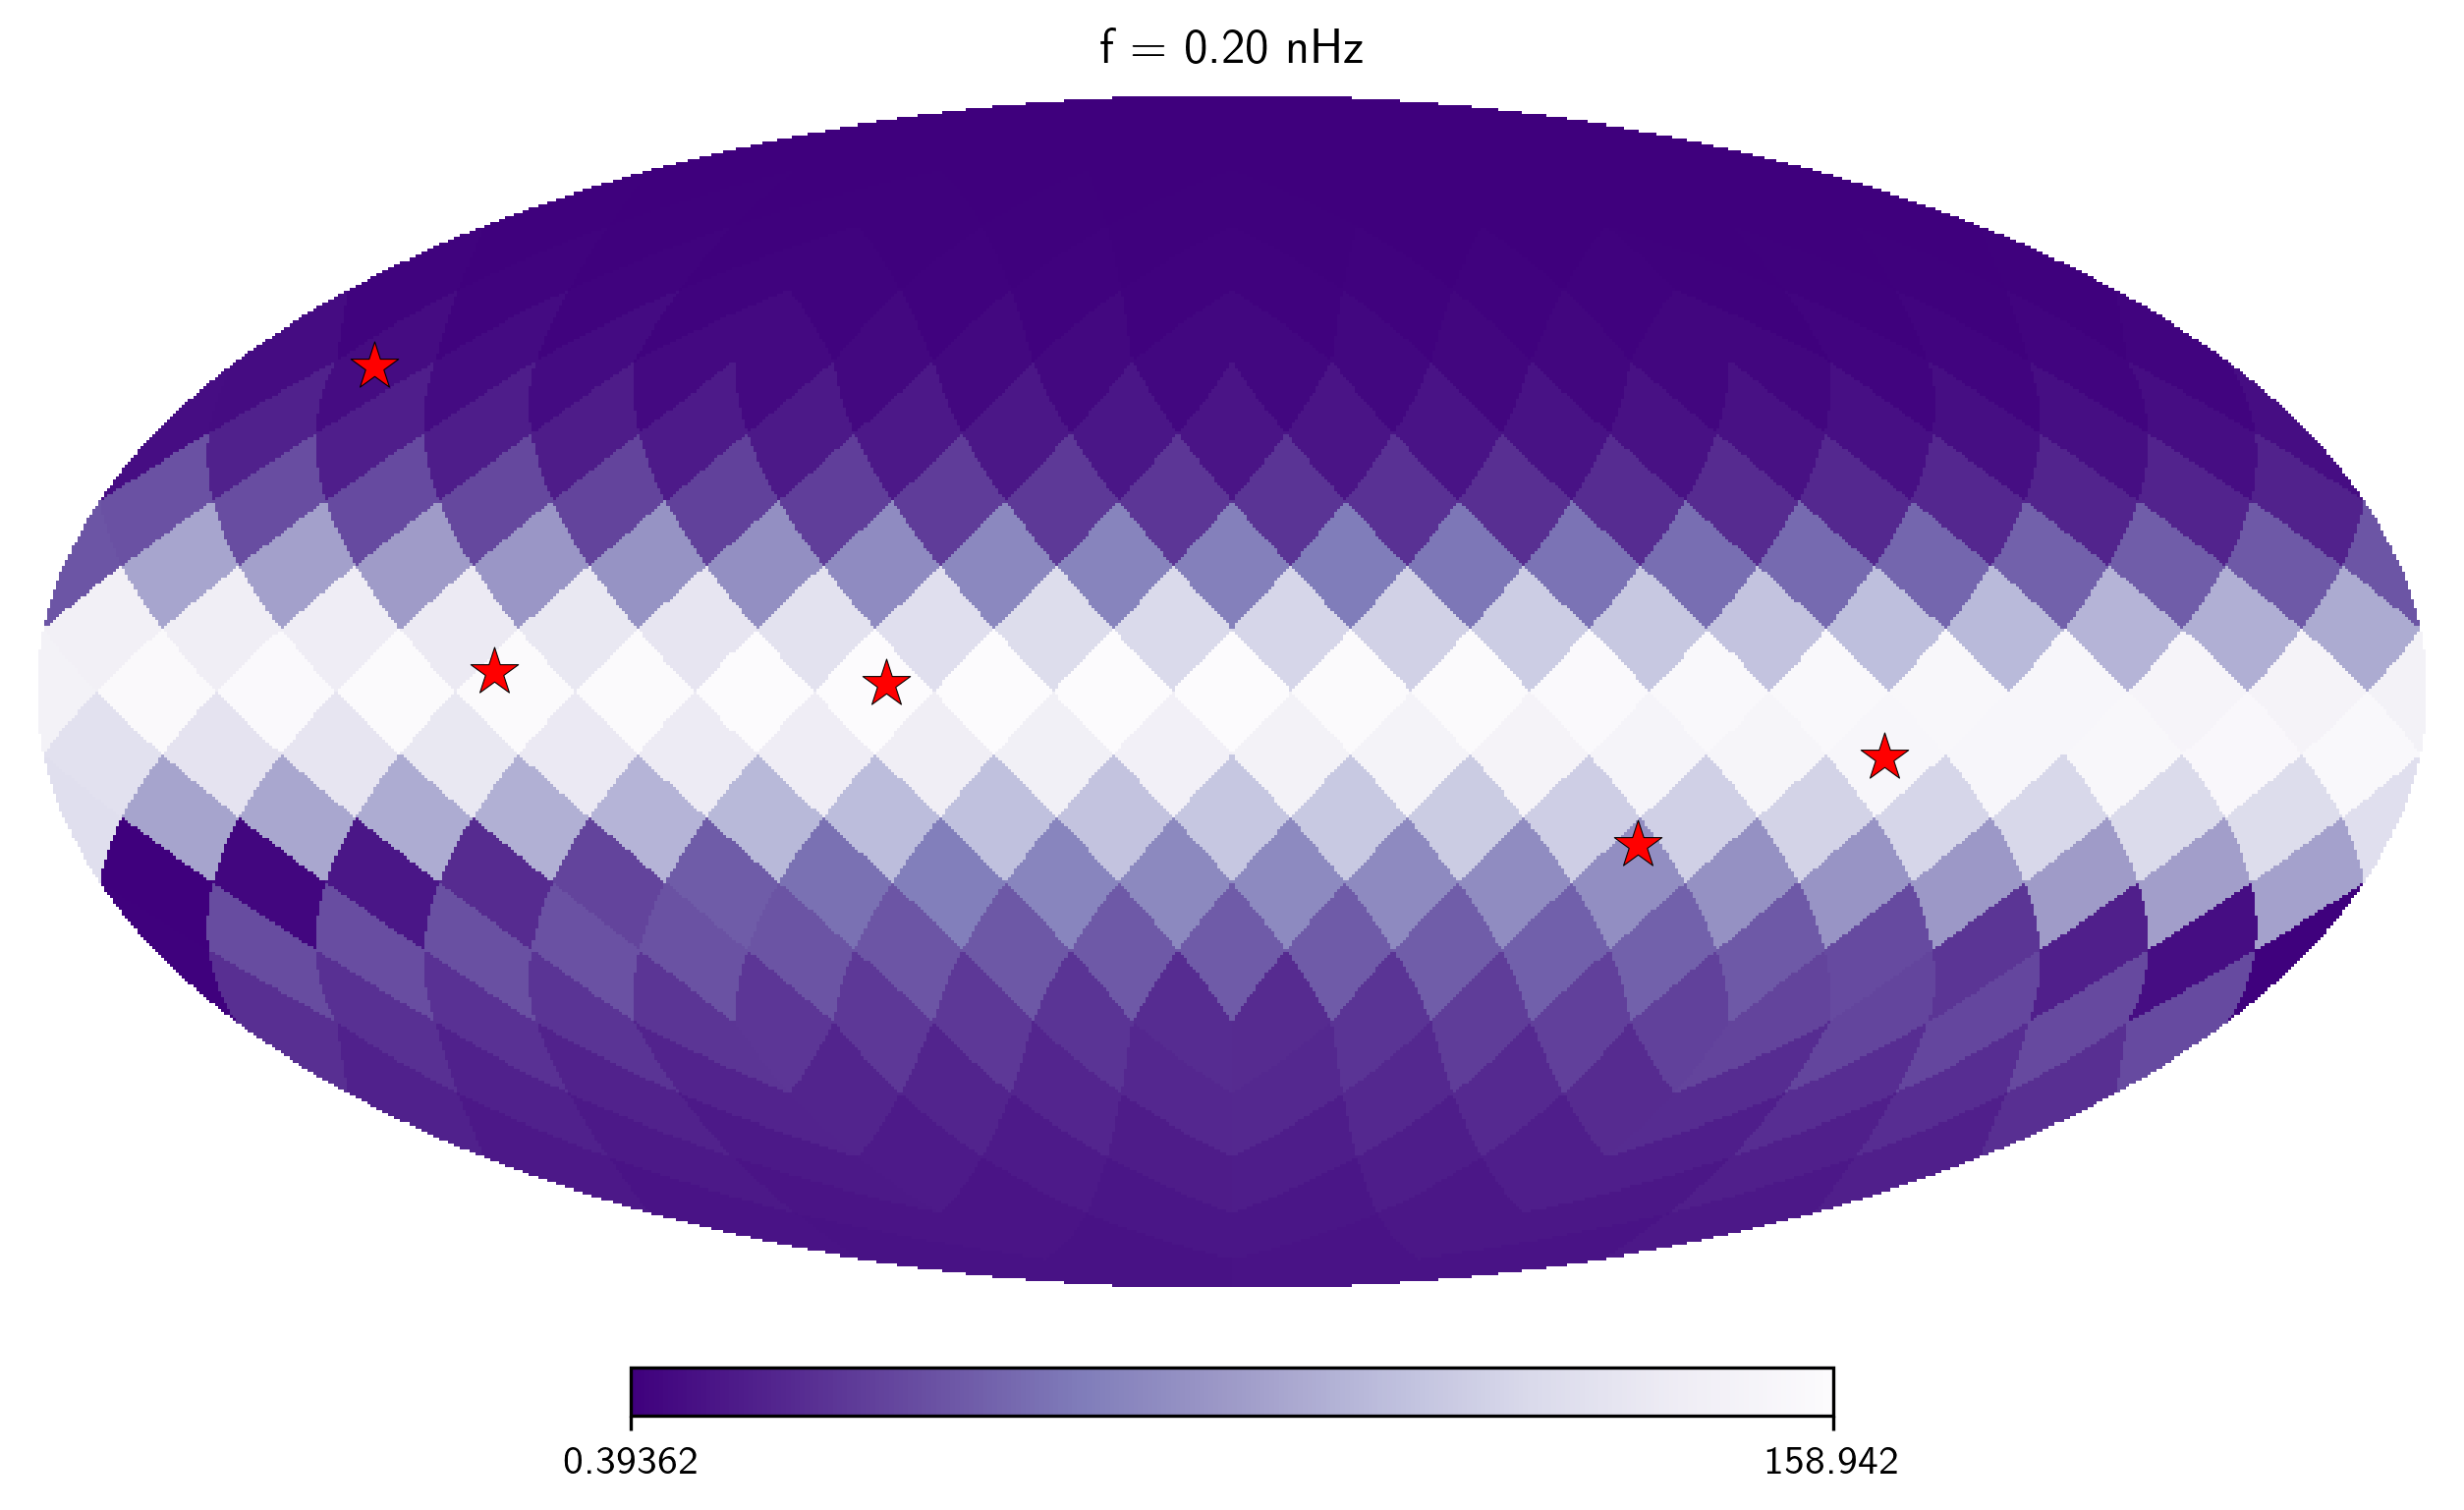

In [ ]:
final_freqs = [max_freq, min_freq, median_freq]
final_freqs_idx = [max_index, min_index, median_index]

for freq, idx in zip(final_freqs, final_freqs_idx):
    # Compute the map at this frequency
    M_kk_pixel = np.sqrt(ASM.M_kk[:, idx])/Tspan
    
    # Plot the map
    hp.mollview(M_kk_pixel, title=f"f = {freq * 1e9:.2f} nHz", cmap='Purples_r', rot=(180,0,0))

    # Overlay pulsar positions
    hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
                            edgecolors='black', linewidths=0.25, s=150, alpha=1, rot=(180,0,0))
    
    plt.show()


ValueError: x and y can be no greater than 2D, but have shapes (300,) and (300, 768, 768)

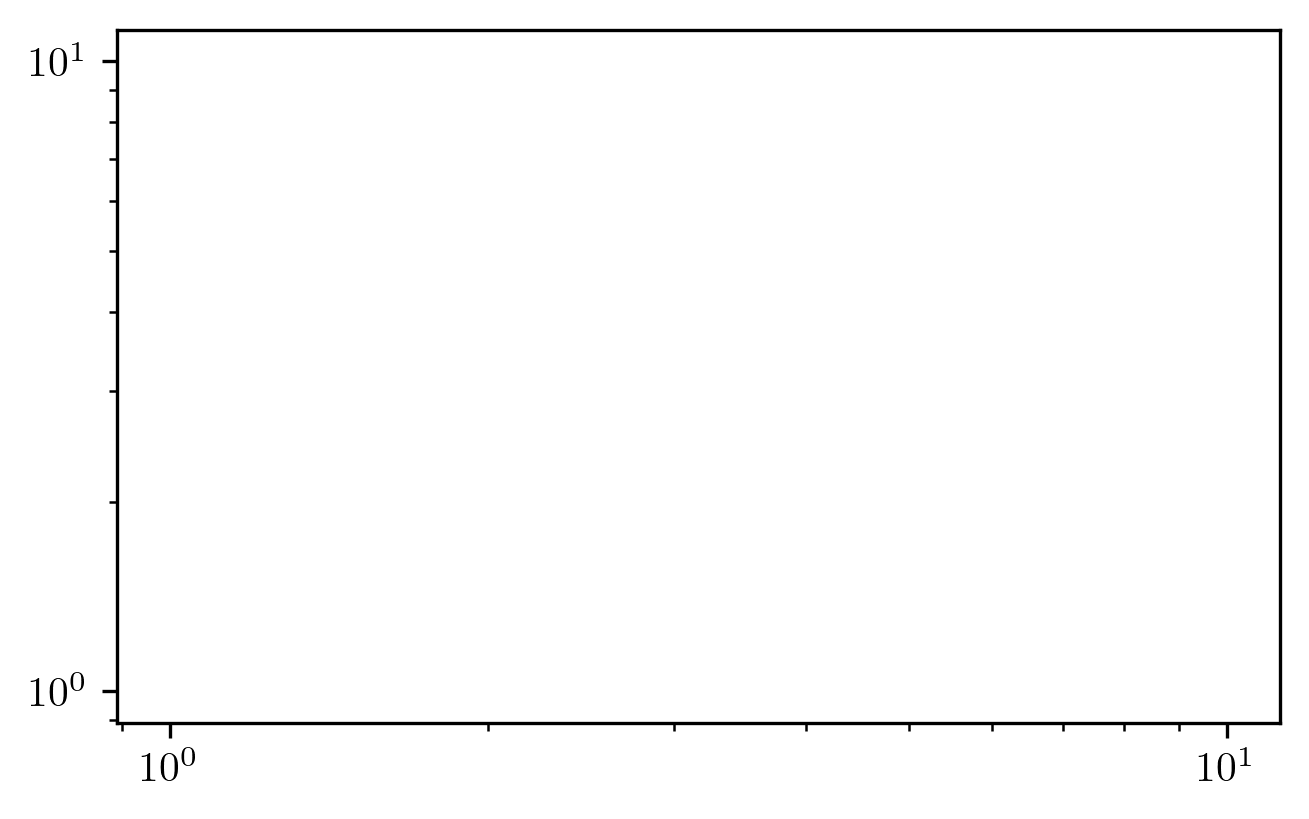

In [ ]:
plt.loglog(spectra_15yr[0].freqs,ASM.S_eff_aniso, color='purple', label='NG 15yr')
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'Effective Strain Noise PSD, $S_{\rm eff}$')
plt.show()

In [ ]:
plt.loglog(spectra_15yr[0].freqs,ASM.h_c_aniso, color='purple', label='NG 15yr')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Characteristic Strain, $h_c$')
plt.show()

## Forecasted pulsars from Jeremy

In [ ]:
datadir_forecast = '/Users/oliverda/Documents/NANOGrav/Anisotropy/gpta_psrs_40yrs_v2/'

In [ ]:
spectra_forecast = []
file_count = 0
max_files = 500  # Number of files to load

for filename in os.listdir(datadir_forecast):
    if filename.endswith('.pkl'):
        file_path = os.path.join(datadir_forecast, filename)
        with open(file_path, 'rb') as file:
            # print(f"Loading file: {filename}")
            spec_forecast = pickle.load(file)
            spectra_forecast.append(spec_forecast)
            # print(f"PSR: {spec_forecast.name}")
            file_count += 1    
            # Clear the loaded file from memory
            del spec_forecast   
            if file_count >= max_files:
                break  # Stop after loading the specified number of files

In [ ]:
spectra_forecast[0].__dir__()

['toas',
 'toaerrs',
 'phi',
 'theta',
 'name',
 'pdist',
 'A_rn',
 'alpha',
 'N',
 'designmatrix',
 '_G',
 '__module__',
 '__doc__',
 '__init__',
 'filter_data',
 'change_cadence',
 'change_sigma',
 'psr_h5',
 'G',
 'K_inv',
 '__dict__',
 '__weakref__',
 '__new__',
 '__repr__',
 '__hash__',
 '__str__',
 '__getattribute__',
 '__setattr__',
 '__delattr__',
 '__lt__',
 '__le__',
 '__eq__',
 '__ne__',
 '__gt__',
 '__ge__',
 '__reduce_ex__',
 '__reduce__',
 '__subclasshook__',
 '__init_subclass__',
 '__format__',
 '__sizeof__',
 '__dir__',
 '__class__']

In [ ]:
max_time = max(
    (np.max(spectra.toas) - np.min(spectra.toas)) / (24 * 3600 * 365.25)
    for spectra in spectra_forecast
)
print(max_time)
max_time_secs = max(
    (np.max(spectra.toas) - np.min(spectra.toas))
    for spectra in spectra_forecast
)
print(max_time_secs)
print(1/max_time_secs)

40.00998050872093
1262618960.9020116
7.920045801352473e-10


In [ ]:
#Use the healpy functions to get the sky coordinates
NSIDE = 8
NPIX = hp.nside2npix(NSIDE)
IPIX = np.arange(NPIX)
theta_gw, phi_gw = hp.pix2ang(nside=NSIDE,ipix=IPIX)

In [ ]:
freqs = np.logspace(np.log10(spectra_15yr[0].freqs[0]),np.log10(spectra_15yr[0].freqs[-1]),300)
spectra = []
for p in spectra_forecast:
    sp = hsen.Spectrum(p, freqs=freqs)
    sp.NcalInv
    spectra.append(sp)

In [ ]:
ASM=haniso.Anisotropy(spectra,theta_gw, phi_gw, NPIX=NPIX)

In [ ]:
freq_idx_forecast = int(np.argmin(np.abs(freqs - 5.08e-9)))
print(f'frequency index for 5.08e-9 Hz: {freq_idx_forecast}')
print(f'frequency for 5.08e-9 Hz: {freqs[freq_idx_forecast]}')

frequency index for 5.08e-9 Hz: 140
frequency for 5.08e-9 Hz: 5.078228867360695e-09


In [ ]:
final_freqs_idx = [freq_idx_forecast]
final_freqs = [float(freqs[freq_idx_forecast])]
labels = ['min']
print(f'Final Frequencies: {final_freqs}')
print(f'Final frequency type: {type(final_freqs)}')
print(f'Final Frequency Indices: {final_freqs_idx}')
print(f'Final Frequency Indices type: {type(final_freqs_idx)}')
print(f'Labels: {labels}')
print(f'Labels type: {type(labels)}')

Final Frequencies: [5.078228867360695e-09]
Final frequency type: <class 'list'>
Final Frequency Indices: [140]
Final Frequency Indices type: <class 'list'>
Labels: ['min']
Labels type: <class 'list'>


In [ ]:
def plot_mollview(data, title, filename, cbar_label):
    hp.mollview(data, title=title, cmap='Purples', rot=(180, 0, 0), cbar=None)
    hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red',
                            edgecolors='black', linewidths=0.25, s=150, alpha=1)
    hp.graticule()

    fig = plt.gcf()
    ax = plt.gca()
    
    # Get the image and add a colorbar
    image = ax.get_images()[0]
    cbar = fig.colorbar(image, ax=ax, orientation='horizontal', shrink=0.8, pad=0.05)
    cbar.set_label(cbar_label, labelpad=10)
    
    plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='w')
    plt.close()

# Iterate through the frequency, index, and label simultaneously
for freq, idx, label in zip(final_freqs, final_freqs_idx, labels):
    # Plot M_kk_pixel without normalization
    M_kk_pixel = np.sqrt(ASM.M_kk[idx, :]) / max_time_secs
    plot_mollview(M_kk_pixel, title=f"f = {freq * 1e9:.2f} nHz", filename=f'ng15yr_Mkk_{label}.pdf', cbar_label=r'$\sqrt{\mathcal{M}}$')

    # Plot M_kk_pixel with normalization
    M_kk_pixel_norm = (M_kk_pixel - np.min(M_kk_pixel)) / (np.max(M_kk_pixel) - np.min(M_kk_pixel))
    plot_mollview(M_kk_pixel_norm, title=f"f = {freq * 1e9:.2f} nHz", filename=f'ng15yr_Mkk_{label}_scale.pdf', cbar_label=r'$\sqrt{\mathcal{M}}$')
    

In [ ]:
#Use the healpy functions to get the sky coordinates
NSIDE = 8
NPIX = hp.nside2npix(NSIDE)
IPIX = np.arange(NPIX)
theta_gw, phi_gw = hp.pix2ang(nside=NSIDE,ipix=IPIX)

In [ ]:
freqs = np.logspace(np.log10(spectra_15yr[0].freqs[0]),np.log10(spectra_15yr[0].freqs[-1]),300)
spectra = []
for p in spectra_forecast:
    sp = hsen.Spectrum(p, freqs=freqs)
    sp.NcalInv
    spectra.append(sp)

NameError: name 'spectra_15yr' is not defined

In [ ]:
ASM=haniso.Anisotropy(spectra_forecast,theta_gw, phi_gw, NPIX=NPIX)

Mkkp = ASM.M_kkp 

import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

# Assume these are already defined or passed earlier
# ASM = haniso.Anisotropy(spectra, theta_gw, phi_gw, NPIX=NPIX)
# Mkkp = ASM.M_kkp  # Shape: (N_freqs, N_pix, N_pix)

fi = min_index  # Frequency index
fixed_kp = np.random.randint(0, Mkkp.shape[2])  # Fixed pixel k'
fixed_k = np.random.randint(0, Mkkp.shape[1])   # Fixed pixel k

# Angular coordinates of fixed pixels
theta_kp, phi_kp = hp.pix2ang(ASM.NPIX, fixed_kp)
theta_k, phi_k = hp.pix2ang(ASM.NPIX, fixed_k)

# Map slices
map_k  = Mkkp[fi, :, fixed_kp]   # M(f, k, k'=fixed)
map_kp = Mkkp[fi, fixed_k, :]    # M(f, k=fixed, k')

# First plot: fixed k'
hp.mollview(map_k, title=f"M(f, k, k'={fixed_kp})", cmap='Purples_r',
            rot=(180, 0, 0))

# Highlight fixed_kp with red outline
hp.visufunc.projscatter([theta_kp], [phi_kp],
                        marker='o', color='none', edgecolors='red',
                        linewidths=2, s=200, rot=(180, 0, 0))

# Optional: overlay GW sources
hp.visufunc.projscatter(ASM.thetas, ASM.phis,
                        marker='*', color='red', edgecolors='black',
                        s=150, rot=(180, 0, 0))

# plt.savefig('40yr_Mkkp_fixed_kp.pdf', dpi=300, bbox_inches='tight', facecolor='w')
plt.close()

# Second plot: fixed k
hp.mollview(map_kp, title=f"M(f, k={fixed_k}, k')", cmap='Purples_r',
            rot=(180, 0, 0))

# Highlight fixed_k with red outline
hp.visufunc.projscatter([theta_k], [phi_k],
                        marker='o', color='none', edgecolors='red',
                        linewidths=2, s=200, rot=(180, 0, 0))

hp.visufunc.projscatter(ASM.thetas, ASM.phis,
                        marker='*', color='red', edgecolors='black',
                        s=150, rot=(180, 0, 0))

# plt.savefig('40yr_Mkkp_fixed_k.pdf', dpi=300, bbox_inches='tight', facecolor='w')
plt.close()

# Normalize and scale
Tspan = ...  # Make sure this is defined

M_kk_scale = np.sqrt(Mkkp[fi, :, fixed_kp]) / Tspan
M_kkp_scale = np.sqrt(Mkkp[fi, fixed_k, :]) / Tspan

M_kk_norm = (M_kk_scale - np.min(M_kk_scale)) / (np.max(M_kk_scale) - np.min(M_kk_scale))
M_kkp_norm = (M_kkp_scale - np.min(M_kkp_scale)) / (np.max(M_kkp_scale) - np.min(M_kkp_scale))

# Scaled plot: fixed k'
hp.mollview(M_kk_norm, title=f"Scaled M(f, k, k'={fixed_kp})", cmap='Purples_r',
            rot=(180, 0, 0))

hp.visufunc.projscatter([theta_kp], [phi_kp],
                        marker='o', color='none', edgecolors='red',
                        linewidths=2, s=200, rot=(180, 0, 0))

hp.visufunc.projscatter(ASM.thetas, ASM.phis,
                        marker='*', color='red', edgecolors='black',
                        s=150, rot=(180, 0, 0))

# plt.savefig('40yr_Mkkp_scaled_fixed_kp.pdf', dpi=300, bbox_inches='tight', facecolor='w')
plt.close()

# Scaled plot: fixed k
hp.mollview(M_kkp_norm, title=f"Scaled M(f, k={fixed_k}, k')", cmap='Purples_r',
            rot=(180, 0, 0))

hp.visufunc.projscatter([theta_k], [phi_k],
                        marker='o', color='none', edgecolors='red',
                        linewidths=2, s=200, rot=(180, 0, 0))

hp.visufunc.projscatter(ASM.thetas, ASM.phis,
                        marker='*', color='red', edgecolors='black',
                        s=150, rot=(180, 0, 0))

# plt.savefig('40yr_Mkkp_scaled_fixed_k.pdf', dpi=300, bbox_inches='tight', facecolor='w')
plt.close()


AttributeError: 'Pulsar' object has no attribute 'freqs'

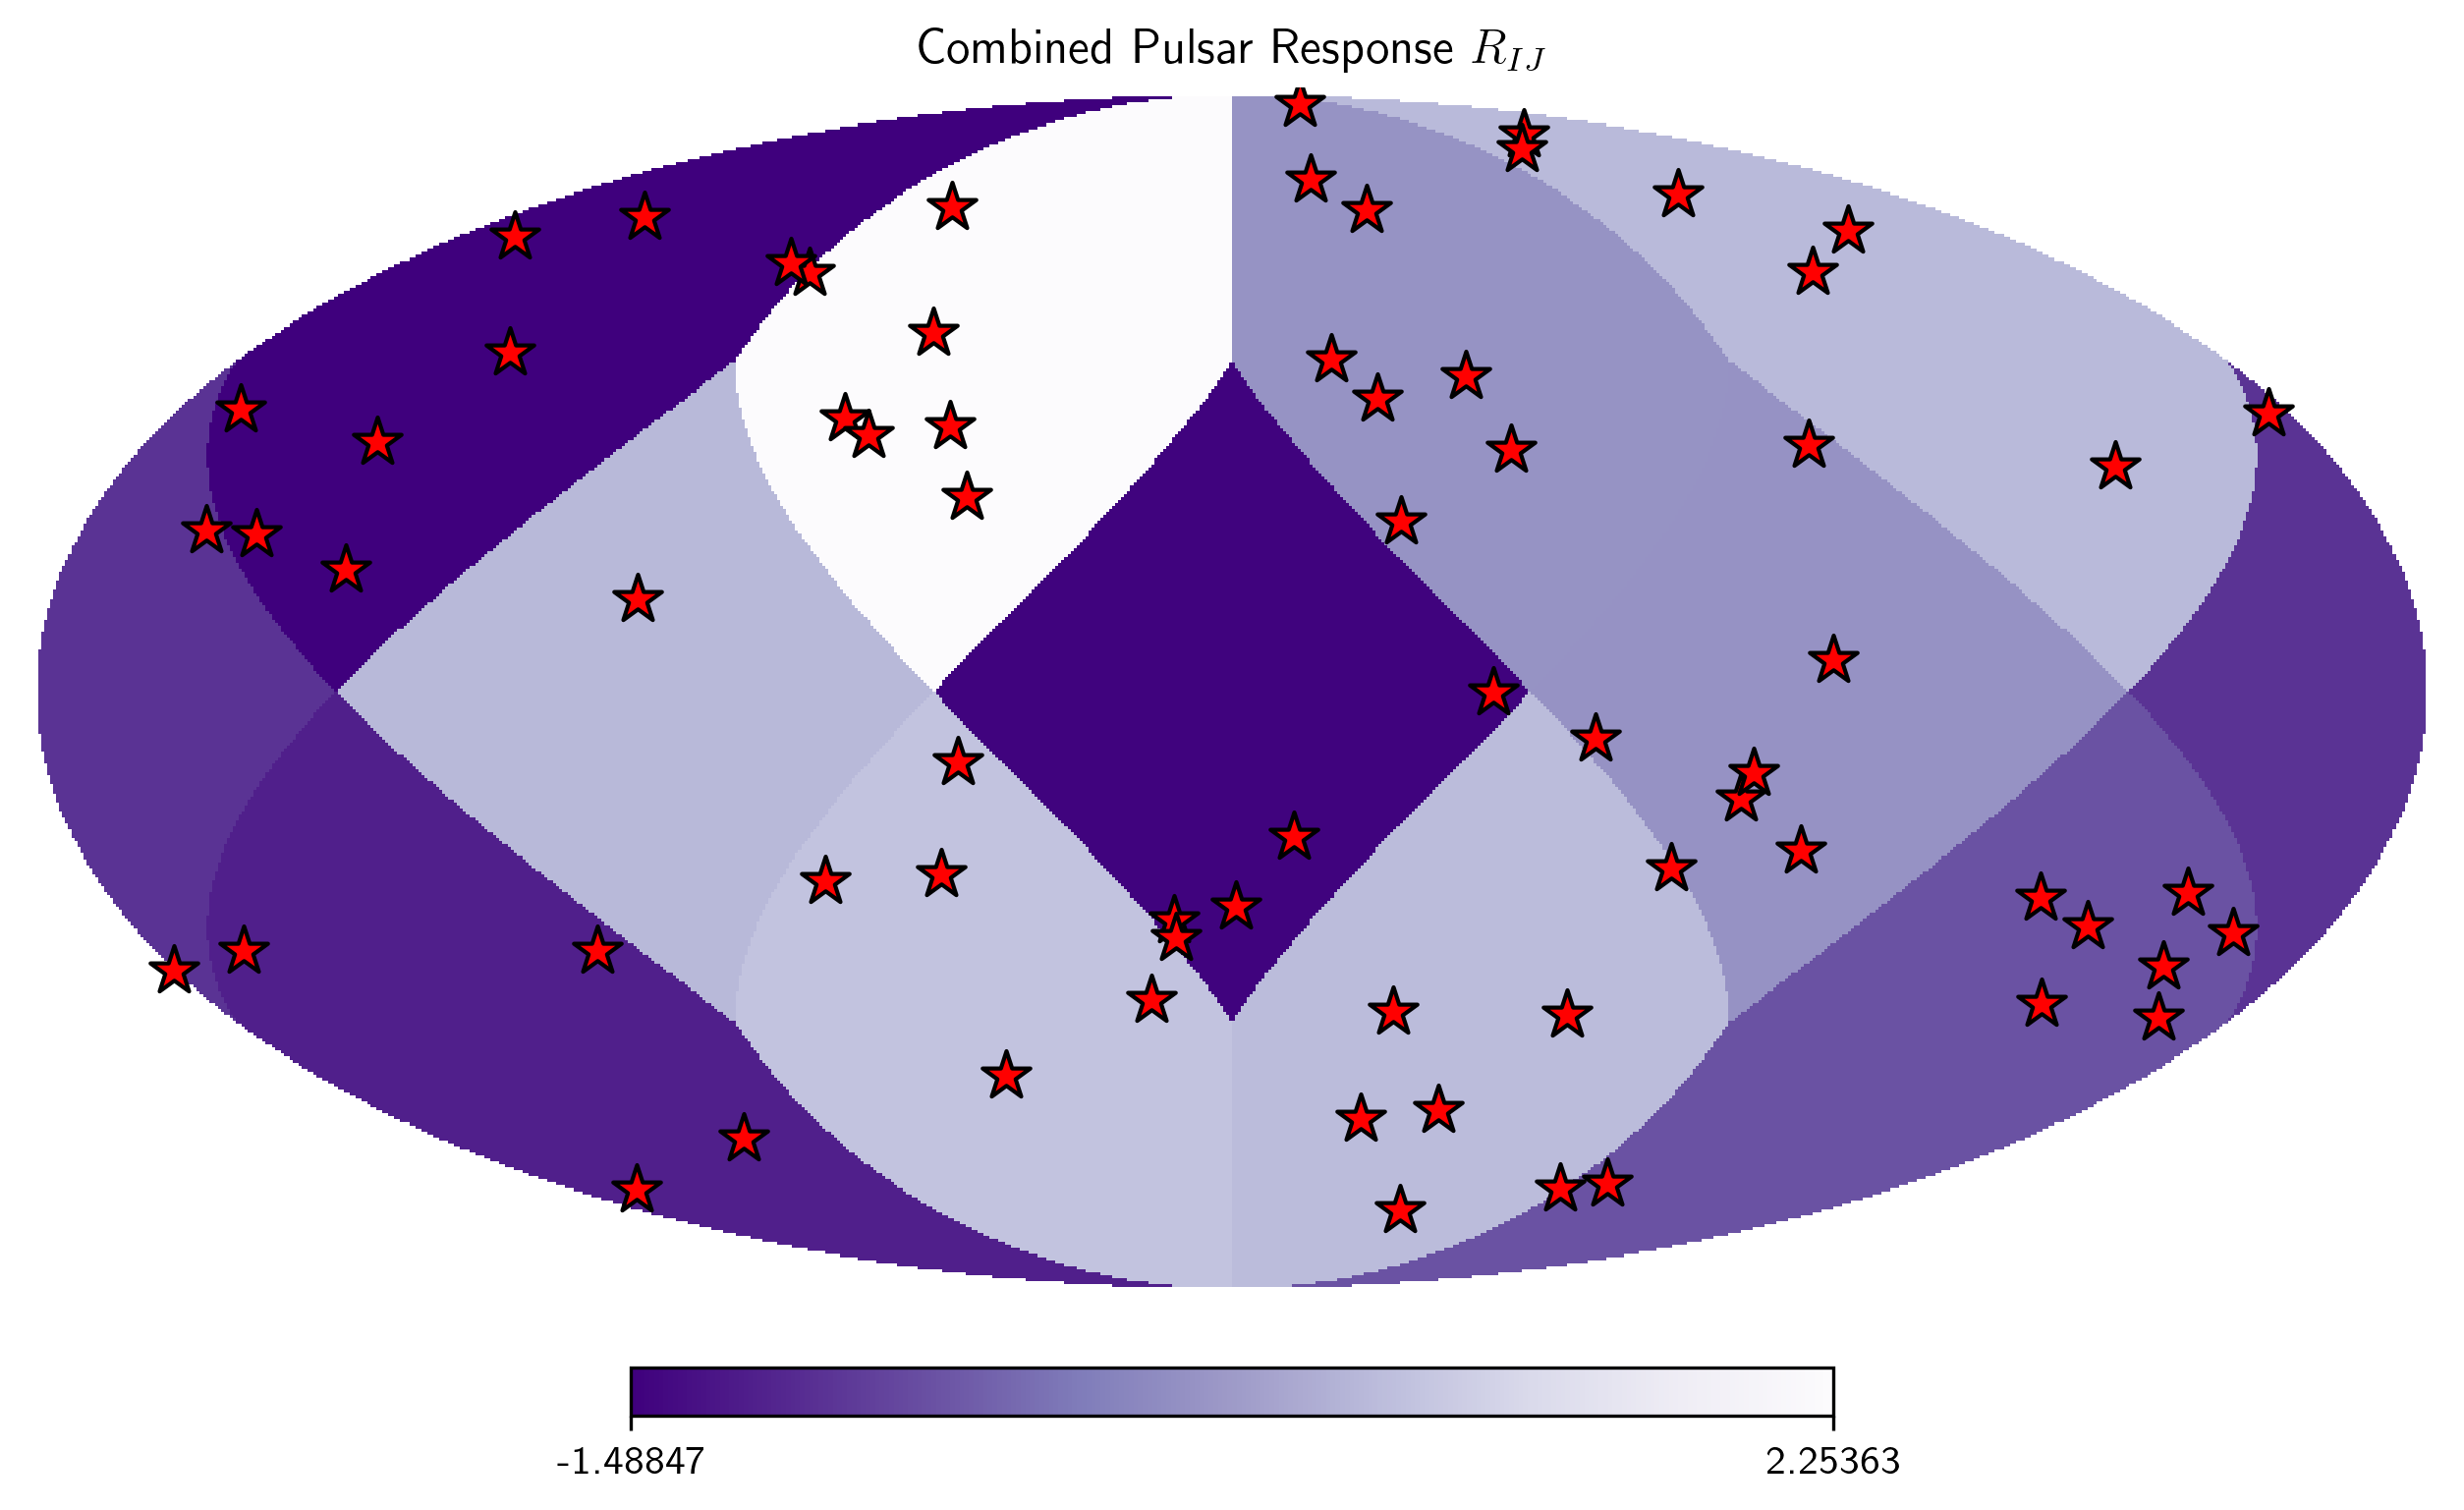

In [ ]:
# Summing all pair responses
combined_response = ASM.R_IJ.sum(axis=0)

vmin, vmax = np.min(combined_response), np.max(combined_response)
hp.mollview(combined_response, title="Combined Pulsar Response $R_{IJ}$", 
            cmap='Purples_r', hold=False, rot=(180,0,0))

# Highlight all pulsar positions

hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
                            edgecolors='black', s=150, rot=(180,0,0))
plt.savefig(savedir+'combined_forecast.png')
plt.show()


In [ ]:
Tspan = max(
    (np.max(spectra.toas) - np.min(spectra.toas))
    for spectra in spectra_forecast
)

In [ ]:
max_value = np.max(ASM.h_c_aniso)
max_index = np.argmax(ASM.h_c_aniso)
max_freq = freqs[max_index]  # Corresponding frequency
print(f"Max value: {max_value}, Index: {max_index}, Frequency: {max_freq}")

min_value = np.min(ASM.h_c_aniso)
min_index = np.argmin(ASM.h_c_aniso)
min_freq = freqs[min_index]  # Corresponding frequency
print(f"Min value: {min_value}, Index: {min_index}, Frequency: {min_freq}")

median_value = np.median(ASM.h_c_aniso)
median_index = (np.abs(ASM.h_c_aniso - median_value)).argmin()
median_freq = freqs[median_index]  # Corresponding frequency
print(f"Median value: {median_value}, Index: {median_index}, Frequency: {median_freq}")

In [ ]:
final_freqs = [max_freq, min_freq, median_freq]
final_freqs_idx = [max_index, min_index, median_index]

for freq, idx in zip(final_freqs, final_freqs_idx):
    # Compute the map at this frequency
    h_c_pixel = ASM.h_c_aniso_pixel(idx)
    
    # Plot the map
    hp.mollview(h_c_pixel, title=f"f = {freq * 1e9:.2f} nHz", cmap='Purples_r', rot=(180,0,0))

    # Overlay pulsar positions
    hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
                            edgecolors='black', linewidths=0.25, s=150, alpha=1, rot=(180,0,0))
    
    plt.show()


In [ ]:
M_kk_pixel = np.sqrt(ASM.M_kk[:, max_index])/Tspan

# Rescale M_kk_pixel such that min = 0 and max = 1
M_kk_pixel_norm = (M_kk_pixel - np.min(M_kk_pixel)) / (np.max(M_kk_pixel) - np.min(M_kk_pixel))

# Plot the map with the normalized values
hp.mollview(M_kk_pixel_norm, title=f"f = {max_freq * 1e9:.2f} nHz", cmap='Purples_r', rot=(180,0,0))

# Overlay pulsar positions
hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
                        edgecolors='black', linewidths=0.25, s=150, alpha=1, rot=(180,0,0))

plt.show()



In [ ]:
M_kk_pixel = np.sqrt(ASM.M_kk[:, min_index])/Tspan

# Rescale M_kk_pixel such that min = 0 and max = 1
M_kk_pixel_norm = (M_kk_pixel - np.min(M_kk_pixel)) / (np.max(M_kk_pixel) - np.min(M_kk_pixel))

# Plot the map with the normalized values
hp.mollview(M_kk_pixel_norm, title=f"f = {min_freq * 1e9:.2f} nHz", cmap='Purples_r', rot=(180,0,0))

# Overlay pulsar positions
hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
                        edgecolors='black', linewidths=0.25, s=150, alpha=1, rot=(180,0,0))

plt.show()



In [ ]:
# plt.rc('text', usetex=True)
# hp.mollview(M_kk_pixel_norm, title=f"f = {median_freq * 1e9:.2f} nHz", 
#             cmap='Purples_r', rot=(180,0,0), cbar=None)
# hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
#                         edgecolors='black', linewidths=0.25, s=150, alpha=1)
# hp.graticule()
# fig = plt.gcf()
# ax = plt.gca()
# image = ax.get_images()[0]
# cbar = fig.colorbar(image, ax=ax, orientation='horizontal', shrink=0.8, pad=0.05)
# cbar.set_label(r'$\sqrt{\mathcal{M}}$', labelpad=10)
# plt.rcParams.update({'font.size':22,'text.usetex':True})
# plt.show()


In [ ]:
M_kk_pixel = np.sqrt(ASM.M_kk[:, median_index])/Tspan

# Rescale M_kk_pixel such that min = 0 and max = 1
M_kk_pixel_norm = (M_kk_pixel - np.min(M_kk_pixel)) / (np.max(M_kk_pixel) - np.min(M_kk_pixel))

# Plot the map with the normalized values
hp.mollview(M_kk_pixel_norm, title=f"f = {median_freq * 1e9:.2f} nHz", cmap='Purples_r', rot=(180,0,0))

# Overlay pulsar positions
hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
                        edgecolors='black', linewidths=0.25, s=150, alpha=1, rot=(180,0,0))

plt.show()



In [ ]:
final_freqs = [max_freq, min_freq, median_freq]
final_freqs_idx = [max_index, min_index, median_index]

for freq, idx in zip(final_freqs, final_freqs_idx):
    # Compute the map at this frequency
    M_kk_pixel = np.sqrt(ASM.M_kk[:, idx])/Tspan
    
    # Plot the map
    hp.mollview(M_kk_pixel, title=f"f = {freq * 1e9:.2f} nHz", cmap='Purples_r', rot=(180,0,0))

    # Overlay pulsar positions
    hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
                            edgecolors='black', linewidths=0.25, s=150, alpha=1, rot=(180,0,0))
    
    plt.show()


In [ ]:
plt.loglog(freqs,ASM.S_eff_aniso, color='black', label='40yr PTA (Simulated)')
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'Effective Strain Noise PSD, $S_{\rm eff}$')
plt.show()

In [ ]:
plt.loglog(freqs,ASM.h_c_aniso, color='black', label='40yr PTA (Simulated)')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Characteristic Strain, $h_c$')
plt.gca().set_yticklabels([])
plt.show()

In [ ]:
sc1a = hsen.GWBSensitivityCurve(spectra)

In [ ]:
plt.loglog(freqs,ASM.S_effIJ[1], color='black', linestyle=':', label='40yr PTA (Simulated)')
plt.loglog(sc1a.freqs,sc1a.S_effIJ[1],label='GWBSensitivityCurve')
plt.loglog(freqs,ASM.S_eff_aniso, color='purple', label='40yr PTA (Simulated) aniso')
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'Effective Strain Noise PSD, $S_{\rm eff}$')
# plt.legend()
plt.show()

In [ ]:
# plt.loglog(freqs,np.sqrt(freqs*ASM.S_eff_aniso), color='black', label='np.sqrt(freqs*ASM.S_eff_aniso)')
plt.loglog(freqs,ASM.h_c_aniso*30, color='purple', label='ASM.h_c_aniso*30')
plt.loglog(freqs,ASM.h_c_aniso, color='black', label='ASM.h_c_aniso')
plt.loglog(freqs,sc1a.h_c, label='sc1a.h_c')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Characteristic Strain, $h_c$')
plt.legend(fontsize='small')
plt.show()

In [ ]:
plt.loglog(freqs,ASM.S_effIJ[1], color='black', label='40yr PTA (Simulated)')
plt.loglog(freqs,ASM.S_eff_aniso, color='purple', label='40yr PTA (Simulated) aniso')
plt.loglog(sc1a.freqs,sc1a.S_effIJ[1], label='GWBSensitivityCurve')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Characteristic Strain, $h_c$')
plt.show()

In [ ]:
plt.loglog(freqs,np.sqrt(freqs*ASM.S_effIJ[1]), color='black', label='40yr PTA (Simulated)')
plt.loglog(freqs,np.sqrt(freqs*ASM.S_eff_aniso), color='purple', label='40yr PTA (Simulated) aniso')
plt.loglog(freqs,ASM.h_c_aniso, color='pink', label='40yr PTA (Simulated) aniso')
plt.loglog(sc1a.freqs,np.sqrt(sc1a.freqs*sc1a.S_effIJ[1]), label='GWBSensitivityCurve')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Characteristic Strain, $h_c$')
plt.show()

In [ ]:
# # Placeholder for computed values
# averages = []

# # Iterate over frequency indices
# for freq_idx in range(len(freqs)):  # Use range(len(freqs)) to iterate properly
#     sqrt_values = np.sqrt(ASM.M_kk[:, freq_idx])  
#     avg_value = np.mean(sqrt_values)  # Compute average
#     averages.append(avg_value)  # Append to list

# # Compute statistics for frequencies
# max_freq_idx = np.argmax(averages)  # Index of the max average value
# min_freq_idx = np.argmin(averages)  # Index of the min average value
# avg_freq_idx = np.argmin(np.abs(averages - np.mean(averages)))  # Closest to mean

# max_freq = freqs[max_freq_idx]
# min_freq = freqs[min_freq_idx]
# avg_freq = freqs[avg_freq_idx]
# # Plot for max frequency
# max_mkk = np.sqrt(ASM.M_kk[:, max_freq_idx])


# vmin, vmax = np.min(max_mkk), np.max(max_mkk)
# hp.mollview(max_mkk, title=f"Max f = {max_freq * 1e9:.2f} nHz", 
#             min=0, max=1, cmap='Purples_r', hold=False, rot=(180,0,0))  # Consistent scale & better contrast

# # Highlight all pulsar positions

# hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
#                         edgecolors='black', linewidths=0.25, s=150, alpha=1, rot=(180,0,0))  # Transparency for clarity

# plt.savefig(savedir+'mkk_max_forecast.png')

# plt.show()

# # Plot for min frequency
# min_mkk = np.sqrt(ASM.M_kk[:, min_freq_idx])


# vmin, vmax = np.min(min_mkk), np.max(min_mkk)
# hp.mollview(min_mkk, title=f"Min f = {min_freq * 1e9:.2f} nHz", 
#             min=0, max=1, cmap='Purples_r', hold=False, rot=(180,0,0))  # Consistent scale & better contrast

# # Highlight all pulsar positions

# hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
#                         edgecolors='black', linewidths=0.25, s=150, alpha=1, rot=(180,0,0))  # Transparency for clarity

# plt.savefig(savedir+'mkk_min_forecast.png')

# plt.show()

# # Plot for average frequency
# avg_mkk = np.sqrt(ASM.M_kk[:, avg_freq_idx])

# vmin, vmax = np.min(avg_mkk), np.max(avg_mkk)
# hp.mollview(avg_mkk, title=f"Avg f = {avg_freq * 1e9:.2f} nHz", 
#             min=0, max=1, cmap='Purples_r', hold=False, rot=(180,0,0))  # Consistent scale & better contrast

# # Highlight all pulsar positions

# hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
#                         edgecolors='black', linewidths=0.25, s=150, alpha=1, rot=(180,0,0))  # Transparency for clarity

# plt.savefig(savedir+'mkk_avg_forecast.png')

# plt.show()